# Frenet on Carla

In [1]:
import glob
import os
import sys

try:
    sys.path.append(glob.glob('../carla/dist/carla-*%d.%d-%s.egg' % (
        sys.version_info.major,
        sys.version_info.minor,
        'win-amd64' if os.name == 'nt' else 'linux-x86_64'))[0])
except IndexError:
    pass

import carla

In [2]:
from util.carla_util import carla_vec_to_np_array, carla_img_to_array, CarlaSyncMode, find_weather_presets, get_font, should_quit #draw_image
from util.geometry_util import dist_point_linestring

pygame 2.0.1 (SDL 2.0.14, Python 3.8.8)
Hello from the pygame community. https://www.pygame.org/contribute.html


In [3]:
import random
import cv2
from pathlib import Path
import numpy as np
import pygame
import math
import weakref
import pickle
import copy

import matplotlib
import numpy as np
import matplotlib.pyplot as plt

# from util.carla_util import carla_vec_to_np_array, carla_img_to_array, CarlaSyncMode, find_weather_presets, get_font, should_quit #draw_image
# from util.geometry_util import dist_point_linestring


In [4]:
from quintic_polynomials_planner import QuinticPolynomial
import cubic_spline_planner

In [5]:

from frenet_optimal_trajectory import FrenetPlanner as MotionPlanner

import imageio
from copy import deepcopy

In [6]:
optimalDistance = 8
followDrivenPath = True
evaluateChasingCar = True
record = False
chaseMode = True
followMode = False

drivesDir = './drives'
drivesFileNames = os.listdir(drivesDir)
drivesFileNames.sort()

drivesFileNames = ['ride5.p']  #   ['ride8.p']  ['ride10.p']  for testing advance angle turns # turnel ['ride15.p']  


In [7]:
def send_control(vehicle, throttle, steer, brake,
                 hand_brake=False, reverse=False):
    throttle = np.clip(throttle, 0.0, 1.0)
    steer = np.clip(steer, -1.0, 1.0)
    brake = np.clip(brake, 0.0, 1.0)
    control = carla.VehicleControl(throttle, steer, brake, hand_brake, reverse)
    vehicle.apply_control(control)


def get_speed(vehicle):
    """
    Compute speed of a vehicle in Kmh
    :param vehicle: the vehicle for which speed is calculated
    :return: speed as a float in Kmh
    """
    vel = vehicle.get_velocity()
    # return 3.6 * math.sqrt(vel.x ** 2 + vel.y ** 2 + vel.z ** 2)        # 3.6 * meter per seconds = kmh
    return math.sqrt(vel.x ** 2 + vel.y ** 2 + vel.z ** 2)        # meter per seconds



In [8]:

# New Classes
class Evaluation():
    def __init__(self):
        self.sumMAE = 0
        self.sumRMSE = 0
        self.n_of_frames = 0
        self.n_of_collisions = 0
        self.history = []

    def AddError(self, distance, goalDistance):
        self.n_of_frames += 1
        self.sumMAE += abs(goalDistance-distance)
        self.sumRMSE += abs(goalDistance-distance)*abs(goalDistance-distance)

    def WriteIntoFileFinal(self, filename, driveName):
        if self.n_of_frames > 0:
            self.sumMAE = self.sumMAE / float(self.n_of_frames)
            self.sumRMSE = self.sumRMSE / float(self.n_of_frames)

        with open(filename,'a') as f:
            f.write(str(driveName)+', '+str(self.sumMAE)+', '+str(self.sumRMSE)+', '+str(self.n_of_collisions)+'\n')

    def LoadHistoryFromFile(self, fileName):
        self.history = pickle.load( open(fileName, "rb"))

    def CollisionHandler(self,event):
        self.n_of_collisions += 1


class LineOfSightSensor(object):
    def __init__(self, parent_actor):
        self.sensor = None
        self.distance = None
        self.vehicle_ahead = None
        self._parent = parent_actor
        # self.sensor_transform = carla.Transform(carla.Location(x=4, z=1.7), carla.Rotation(yaw=0)) # Put this sensor on the windshield of the car.
        world = self._parent.get_world()
        bp = world.get_blueprint_library().find('sensor.other.obstacle')
        bp.set_attribute('distance', '200')
        bp.set_attribute('hit_radius', '0.5')
        bp.set_attribute('only_dynamics', 'True')
        bp.set_attribute('debug_linetrace', 'True')
        bp.set_attribute('sensor_tick', '0.0')
        self.sensor = world.spawn_actor(bp, carla.Transform(), attach_to=self._parent)
        weak_self = weakref.ref(self)
        self.sensor.listen(lambda event: LineOfSightSensor._on_los(weak_self, event))

    def reset(self):
        self.vehicle_ahead = None
        self.distance = None

    def destroy(self):
        self.sensor.destroy()

    def get_vehicle_ahead(self):
        return self.vehicle_ahead

    # Only works for CARLA 9.6 and above!
    def get_los_distance(self):
        return self.distance

    @staticmethod
    def _on_los(weak_self, event):
        self = weak_self()
        if not self:
            return
        self.vehicle_ahead = event.other_actor
        self.distance = event.distance



In [9]:
class QuarticPolynomial:

    def __init__(self, xs, vxs, axs, vxe, axe, time):
        # calc coefficient of quartic polynomial

        self.a0 = xs
        self.a1 = vxs
        self.a2 = axs / 2.0

        A = np.array([[3 * time ** 2, 4 * time ** 3],
                      [6 * time, 12 * time ** 2]])
        b = np.array([vxe - self.a1 - 2 * self.a2 * time,
                      axe - 2 * self.a2])
        x = np.linalg.solve(A, b)

        self.a3 = x[0]
        self.a4 = x[1]

    def calc_point(self, t):
        xt = self.a0 + self.a1 * t + self.a2 * t ** 2 + \
             self.a3 * t ** 3 + self.a4 * t ** 4

        return xt

    def calc_first_derivative(self, t):
        xt = self.a1 + 2 * self.a2 * t + \
             3 * self.a3 * t ** 2 + 4 * self.a4 * t ** 3

        return xt

    def calc_second_derivative(self, t):
        xt = 2 * self.a2 + 6 * self.a3 * t + 12 * self.a4 * t ** 2

        return xt

    def calc_third_derivative(self, t):
        xt = 6 * self.a3 + 24 * self.a4 * t

        return xt

In [10]:
def calc_frenet_paths(c_speed, c_d, c_d_d, c_d_dd, s0):
    frenet_paths = []

    # generate path to each offset goal
    for di in np.arange(-MAX_ROAD_WIDTH, MAX_ROAD_WIDTH, D_ROAD_W):

        # Lateral motion planning
        for Ti in np.arange(MIN_T, MAX_T, DT):
            fp = FrenetPath()

            lat_qp = QuinticPolynomial(c_d, c_d_d, c_d_dd, di, 0.0, 0.0, Ti)

            fp.t = [t for t in np.arange(0.0, Ti, DT)]
            fp.d = [lat_qp.calc_point(t) for t in fp.t]
            fp.d_d = [lat_qp.calc_first_derivative(t) for t in fp.t]
            fp.d_dd = [lat_qp.calc_second_derivative(t) for t in fp.t]
            fp.d_ddd = [lat_qp.calc_third_derivative(t) for t in fp.t]

            # Longitudinal motion planning (Velocity keeping)
            for tv in np.arange(TARGET_SPEED - D_T_S * N_S_SAMPLE,
                                TARGET_SPEED + D_T_S * N_S_SAMPLE, D_T_S):
                tfp = copy.deepcopy(fp)
                lon_qp = QuarticPolynomial(s0, c_speed, 0.0, tv, 0.0, Ti)

                tfp.s = [lon_qp.calc_point(t) for t in fp.t]
                tfp.s_d = [lon_qp.calc_first_derivative(t) for t in fp.t]
                tfp.s_dd = [lon_qp.calc_second_derivative(t) for t in fp.t]
                tfp.s_ddd = [lon_qp.calc_third_derivative(t) for t in fp.t]

                Jp = sum(np.power(tfp.d_ddd, 2))  # square of jerk
                Js = sum(np.power(tfp.s_ddd, 2))  # square of jerk

                # square of diff from target speed
                ds = (TARGET_SPEED - tfp.s_d[-1]) ** 2

                tfp.cd = K_J * Jp + K_T * Ti + K_D * tfp.d[-1] ** 2
                tfp.cv = K_J * Js + K_T * Ti + K_D * ds
                tfp.cf = K_LAT * tfp.cd + K_LON * tfp.cv

                frenet_paths.append(tfp)

    return frenet_paths



def calc_global_paths(fplist, csp):
    for fp in fplist:

        # calc global positions
        for i in range(len(fp.s)):
            ix, iy, iz = csp.calc_position(fp.s[i])
            if ix is None:
                break
            i_yaw = csp.calc_yaw(fp.s[i])
            di = fp.d[i]
            fx = ix + di * math.cos(i_yaw + math.pi / 2.0)
            fy = iy + di * math.sin(i_yaw + math.pi / 2.0)
            fz = iz
            fp.x.append(fx)
            fp.y.append(fy)
            fp.z.append(fz)
            

        # calc yaw and ds
        for i in range(len(fp.x) - 1):
            dx = fp.x[i + 1] - fp.x[i]
            dy = fp.y[i + 1] - fp.y[i]
            fp.yaw.append(math.atan2(dy, dx))
            fp.ds.append(math.hypot(dx, dy))

        fp.yaw.append(fp.yaw[-1])
        fp.ds.append(fp.ds[-1])

        # calc curvature
        for i in range(len(fp.yaw) - 1):
            fp.c.append((fp.yaw[i + 1] - fp.yaw[i]) / fp.ds[i])

    return fplist


In [11]:
def check_paths(fplist, ob):
    ok_ind = []
    for i, _ in enumerate(fplist):
        if any([v > MAX_SPEED for v in fplist[i].s_d]):  # Max speed check
            continue
        elif any([abs(a) > MAX_ACCEL for a in
                  fplist[i].s_dd]):  # Max accel check
            continue
        elif any([abs(c) > MAX_CURVATURE for c in
                  fplist[i].c]):  # Max curvature check
            continue
        elif not check_collision(fplist[i], ob):
            continue

        ok_ind.append(i)

    return [fplist[i] for i in ok_ind]

In [12]:
def check_collision(fp, ob):
    for i in range(len(ob[:, 0])):
        d = [((ix - ob[i, 0]) ** 2 + (iy - ob[i, 1]) ** 2)
             for (ix, iy) in zip(fp.x, fp.y)]

        collision = any([di <= ROBOT_RADIUS ** 2 for di in d])

        if collision:
            return False

    return True


In [13]:
# Frenet imports

from cubic_spline_planner import *

def generate_target_course(x, y, z):
    csp = Spline3D(x, y, z)
    s = np.arange(0, csp.s[-1], 0.1)

    rx, ry, rz, ryaw, rk = [], [], [], [], []
    for i_s in s:
        ix, iy, iz = csp.calc_position(i_s)
        rx.append(ix)
        ry.append(iy)
        rz.append(iz)
        ryaw.append(csp.calc_yaw(i_s))
        rk.append(csp.calc_curvature(i_s))

    return rx, ry, ryaw, rk, csp

In [14]:
def frenet_optimal_planning(csp, s0, c_speed, c_d, c_d_d, c_d_dd, ob):
    fplist = calc_frenet_paths(c_speed, c_d, c_d_d, c_d_dd, s0)
    fplist = calc_global_paths(fplist, csp)
    fplist = check_paths(fplist, ob)

    # find minimum cost path
    min_cost = float("inf")
    best_path = None
    for fp in fplist:
        if min_cost >= fp.cf:
            min_cost = fp.cf
            best_path = fp

    return best_path

In [15]:

def frenet_to_inertial(s, d, csp):
    """
    transform a point from frenet frame to inertial frame
    input: frenet s and d variable and the instance of global cubic spline class
    output: x and y in global frame
    """
    ix, iy, iz = csp.calc_position(s)
    iyaw = csp.calc_yaw(s)
    x = ix + d * math.cos(iyaw + math.pi / 2.0)
    y = iy + d * math.sin(iyaw + math.pi / 2.0)

    return x, y, iz, iyaw

In [16]:
class FrenetPath:

    def __init__(self):
        self.t = []
        self.d = []
        self.d_d = []
        self.d_dd = []
        self.d_ddd = []
        self.s = []
        self.s_d = []
        self.s_dd = []
        self.s_ddd = []
        self.cd = 0.0
        self.cv = 0.0
        self.cf = 0.0

        self.x = []
        self.y = []
        self.z = []
        self.yaw = []
        self.ds = []
        self.c = []

        self.v = []  # speed

In [17]:
SIM_LOOP = 500

# Parameter
MAX_SPEED = 50.0 / 3.6  # maximum speed [m/s]
MAX_ACCEL = 2.0  # maximum acceleration [m/ss]
MAX_CURVATURE = 1.0  # maximum curvature [1/m]
MAX_ROAD_WIDTH = 7.0  # maximum road width [m]
D_ROAD_W = 1.0  # road width sampling length [m]
DT = 0.2  # time tick [s]
MAX_T = 5.0  # max prediction time [m]
MIN_T = 4.0  # min prediction time [m]
TARGET_SPEED = 30.0 / 3.6  # target speed [m/s]
D_T_S = 5.0 / 3.6  # target speed sampling length [m/s]
N_S_SAMPLE = 1  # sampling number of target speed
ROBOT_RADIUS = 2.0  # robot radius [m]

# cost weights
K_J = 0.1
K_T = 0.1
K_D = 1.0
K_LAT = 1.0
K_LON = 1.0


show_animation = True

In [18]:
from IPython import display as ipython_display
import pylab as pl

In [23]:
def main(optimalDistance, followDrivenPath, chaseMode, evaluateChasingCar, driveName='',record=False, followMode=False,
         resultsName='results',P=None,I=None,D=None,nOfFramesToSkip=0):
    # Imports
    # from cores.lane_detection.lane_detector import LaneDetector
    # from cores.lane_detection.camera_geometry import CameraGeometry
    # from cores.control.pure_pursuit import PurePursuitPlusPID

    # New imports
    from DrivingControl import DrivingControl
    from DrivingControlAdvanced import DrivingControlAdvanced
    from CarDetector import CarDetector
    from SemanticSegmentation import SemanticSegmentation


    # New Variables
    extrapolate = True
    optimalDistance = 8
    followDrivenPath = True
    evaluateChasingCar = True
    record = False
    chaseMode = True
    followMode = False
    counter = 1
    sensors = []

    vehicleToFollowSpawned = False
    obsticle_vehicleSpawned = False

    # New objects
    carDetector = CarDetector()
    drivingControl = DrivingControl(optimalDistance=optimalDistance)
    drivingControlAdvanced = DrivingControlAdvanced(optimalDistance=optimalDistance)
    evaluation = Evaluation()
    semantic = SemanticSegmentation()


    actor_list = []
    pygame.init()

#     display = pygame.display.set_mode(
#         (800, 600),
#         pygame.HWSURFACE | pygame.DOUBLEBUF)
    font = get_font()
    clock = pygame.time.Clock()

    client = carla.Client('localhost', 2000)
    client.set_timeout(80.0)

    #client.load_world('Town06')
    # client.load_world('Town04')
    world = client.get_world()
    weather_presets = find_weather_presets()
    # print(weather_presets)
    world.set_weather(weather_presets[3][0])
    # world.set_weather(carla.WeatherParameters.HardRainSunset)

    # controller = PurePursuitPlusPID()

#     # Set BirdView
#     birdview_producer = BirdViewProducer(
#         client,
#         PixelDimensions(width=DEFAULT_WIDTH, height=DEFAULT_HEIGHT),
#         pixels_per_meter=4,
#         crop_type=BirdViewCropType.FRONT_AND_REAR_AREA,
#         render_lanes_on_junctions=False,
#     )


    try:
        m = world.get_map()

        blueprint_library = world.get_blueprint_library()

        veh_bp = random.choice(blueprint_library.filter('vehicle.dodge_charger.police'))
        vehicle = world.spawn_actor(
            veh_bp,
            m.get_spawn_points()[90])
        actor_list.append(vehicle)

        # New vehicle property
        vehicle.set_simulate_physics(True)

        if followDrivenPath:
            evaluation.LoadHistoryFromFile(driveName)
            first = evaluation.history[0]
            start_pose = carla.Transform(carla.Location(first[0], first[1], first[2]),
                                        carla.Rotation(first[3], first[4], first[5]))
            vehicle.set_transform(start_pose)

        # New Sensors
        collision_sensor = world.spawn_actor(blueprint_library.find('sensor.other.collision'),
                                                carla.Transform(), attach_to=vehicle)
        collision_sensor.listen(lambda event: evaluation.CollisionHandler(event))
        actor_list.append(collision_sensor)

        
        # front cam for object detection
        camera_rgb_blueprint = world.get_blueprint_library().find('sensor.camera.rgb')
        camera_rgb_blueprint.set_attribute('fov', '90')
        camera_rgb = world.spawn_actor(
           camera_rgb_blueprint,
            carla.Transform(carla.Location(x=1.5, z=1.4,y=0.3), carla.Rotation(pitch=0)),
            attach_to=vehicle)
        actor_list.append(camera_rgb)
        sensors.append(camera_rgb)

            
        # segmentation camera
        camera_segmentation = world.spawn_actor(
            blueprint_library.find('sensor.camera.semantic_segmentation'),
            carla.Transform(carla.Location(x=1.5, z=1.4,y=0), carla.Rotation(pitch=0)), #5,3,0 # -0.3
            attach_to=vehicle)
        actor_list.append(camera_segmentation)
        sensors.append(camera_segmentation)


        
        # Set up local planner and behavnioural planner
        # --------------------------------------------------------------
        # generate and save global route if it does not exist in the road_maps folder
        global_route = np.empty((0, 3))

        print("Saving global_route...")

        distance = 1
        for i in range(len(evaluation.history)): #range(1520):

            tmp = evaluation.history[i]

            wp = carla.Transform(carla.Location(tmp[0] ,tmp[1],tmp[2]),carla.Rotation(tmp[3],tmp[4],tmp[5]))

            # wp2 = world.get_map().get_waypoint(carla.Location(x=406, y=-100, z=0.1),
            #                                                 project_to_road=True).next(distance=distance)[0]
            # print("wp: ", wp)
            # print("wp2: ", wp2)

            distance += 2
            global_route = np.append(global_route,
                                            [[wp.location.x, wp.location.y,
                                            wp.location.z]], axis=0)
        #     # To visualize point clouds
        #     self.world_module.points_to_draw['wp {}'.format(wp.id)] = [wp.transform.location, 'COLOR_CHAMELEON_0']
        np.save('./road_maps/global_route_town05', global_route)

        print("Done saving global_route")


        print("vehicle.get_transform():", vehicle.get_transform())
        
        

        init_s = 50
        init_d = 0 * 3.5 # self.LANE_WIDTH # reset can be np.random.randint(-1, 3) * self.LANE_WIDTH

        motionPlanner = MotionPlanner()


        # Start Modules
        motionPlanner.start(global_route)
        motionPlanner.reset(init_s, init_d, df_n=0, Tf=4, Vf_n=0, optimal_path=False)
        # self.world_module.update_global_route_csp(motionPlanner.csp)
        # self.traffic_module.update_global_route_csp(motionPlanner.csp)
        # self.module_manager.start_modules()

        f_idx = 0
        f_state = [init_s, init_d, 0, 0, 0, 0]

        # --------------------------------------------------------------


        frame = 0
        max_error = 0
        FPS = 30
        speed = 0
        cross_track_error = 0
        start_time = 0.0
        times = 8
        LP_FREQUENCY_DIVISOR   = 8                # Frequency divisor to make the 
                                                # local planner operate at a lower
                                                # frequency than the controller
                                                # (which operates at the simulation
                                                # frequency). Must be a natural
                                                # number.
                            


        actors_batch = []
        
        print("Len of waypoints:" , len(evaluation.history))
        
        
                
        # TMP obstacle lists
        ob = np.array([[233.980630, 130.523910],
                       [233.980630, 30.523910],
                       [233.980630, 60.523910],
                       [233.980630, 80.523910],
                       [233.786942, 75.530586],
                       ])
        
        wx = []
        wy = []
        wz = []
        
        for p in evaluation.history:
            wp = carla.Transform(carla.Location(p[0] ,p[1],p[2]),carla.Rotation(p[3],p[4],p[5]))
            wx.append(wp.location.x)
            wy.append(wp.location.y)
            wz.append(wp.location.z)
        
        
        tx, ty, tyaw, tc, csp = generate_target_course(wx, wy, wz)
                
        # initial state
        c_speed = 10.0 / 3.6  # current speed [m/s]
        c_d = 2.0  # current lateral position [m]
        c_d_d = 0.0  # current lateral speed [m/s]
        c_d_dd = 0.0  # current latral acceleration [m/s]
        s0 = 0.0  # current course position    
        
        
        area = 20.0  # animation area length [m]

        fig = plt.figure()
     
        
        i = 0
        
        # Create a synchronous mode context.
        with CarlaSyncMode(world, *sensors, fps=FPS) as sync_mode:
            while True:
                if should_quit():
                    return
        
#         for i in range(70):
            

                # snapshot, image_rgb, image_segmentation = tick_response
                snapshot, img_rgb, image_segmentation = sync_mode.tick(timeout=2.0)

                # detect car in image with semantic segnmentation camera
                carInTheImage = semantic.IsThereACarInThePicture(image_segmentation)

                line = []

                # ------------------- Set up leading vehicle --------------------------------
                # Spawn a vehicle to follow
                if not vehicleToFollowSpawned and followDrivenPath:
                    vehicleToFollowSpawned = True
                    location1 = vehicle.get_transform()
                    newX, newY = carDetector.CreatePointInFrontOFCar(location1.location.x, location1.location.y,
                                                                     location1.rotation.yaw)
                    diffX = newX - location1.location.x
                    diffY = newY - location1.location.y
                    newX = location1.location.x - (diffX*5)
                    newY = location1.location.y - (diffY*5)

                    start_pose.location.x = newX
                    start_pose.location.y = newY

                    vehicle.set_transform(start_pose)

                    start_pose2 = random.choice(m.get_spawn_points())

                    bp = blueprint_library.filter('model3')[0]
                    bp.set_attribute('color', '0,101,189')
                    vehicleToFollow = world.spawn_actor(
                        bp,
                        start_pose2)

                    start_pose2 = carla.Transform()
                    start_pose2.rotation = start_pose.rotation

                    start_pose2.location.x = start_pose.location.x
                    start_pose2.location.y = start_pose.location.y
                    start_pose2.location.z = start_pose.location.z

                    vehicleToFollow.set_transform(start_pose2)

                    actor_list.append(vehicleToFollow)
                    vehicleToFollow.set_simulate_physics(True)

                # ------------------- --------------------------------

                if followDrivenPath:
                    if counter >= len(evaluation.history):
                        break
                    tmp = evaluation.history[counter]
                    currentPos = carla.Transform(carla.Location(tmp[0] ,tmp[1],tmp[2]),carla.Rotation(tmp[3],tmp[4],tmp[5]))
                    vehicleToFollow.set_transform(currentPos)
                    counter += 1




    #             # Adding obsticle_vehicle to actors_batch
    #             los_sensor = LineOfSightSensor(obsticle_vehicle)

    #             target_speed = get_speed(obsticle_vehicle)


                tmp = evaluation.history[i-1]
                currentPos = carla.Transform(carla.Location(tmp[0] + 0 ,tmp[1],tmp[2]),carla.Rotation(tmp[3],tmp[4],tmp[5]))
                vehicleToFollow.set_transform(currentPos)



                # ------------------- Set up obsticle vehicle for testing  --------------------------------

                # Set up obsticle vehicle for testing 
                location1 = vehicle.get_transform()
                location2 = vehicleToFollow.get_transform()


                if not obsticle_vehicleSpawned and followDrivenPath:
                    obsticle_vehicleSpawned = True

                    start_pose3 = random.choice(m.get_spawn_points())

                    obsticle_vehicle = world.spawn_actor(
                    random.choice(blueprint_library.filter('jeep')),
                    start_pose3)

                    start_pose3 = carla.Transform()
                    start_pose3.rotation = start_pose2.rotation
                    start_pose3.location.x = start_pose2.location.x 
                    start_pose3.location.y =  start_pose2.location.y + 50 
                    start_pose3.location.z =  start_pose2.location.z

                    obsticle_vehicle.set_transform(start_pose3)


                    actor_list.append(obsticle_vehicle)
                    obsticle_vehicle.set_simulate_physics(True)

                # ------------------- --------------------------------



                # ------------------- Control for ego  --------------------------------

                # Update vehicle position by detecting vehicle to follow position
                newX, newY = carDetector.CreatePointInFrontOFCar(location1.location.x, location1.location.y,location1.rotation.yaw)
                angle = carDetector.getAngle([location1.location.x, location1.location.y], [newX, newY],
                                             [location2.location.x, location2.location.y])

                possibleAngle = 0
                drivableIndexes = []
                bbox = []


                bbox, predicted_distance,predicted_angle = carDetector.getDistance(vehicleToFollow, camera_rgb,carInTheImage,extrapolation=extrapolate,nOfFramesToSkip=nOfFramesToSkip)

                if frame % LP_FREQUENCY_DIVISOR == 0:
                    # This is the bottle neck and takes times to run. But it is necessary for chasing around turns
                    predicted_angle, drivableIndexes = semantic.FindPossibleAngle(image_segmentation,bbox,predicted_angle) # This is still necessary need to optimize it 

                steer, throttle = drivingControlAdvanced.PredictSteerAndThrottle(predicted_distance,predicted_angle,None)

                # This is a new method
                send_control(vehicle, throttle, steer, 0)


                speed = np.linalg.norm(carla_vec_to_np_array(vehicle.get_velocity()))

                real_dist = location1.location.distance(location2.location)


                fps = round(1.0 / snapshot.timestamp.delta_seconds)


                i += 1
                frame += 1



                path = frenet_optimal_planning(csp, s0, c_speed, c_d, c_d_d, c_d_dd, ob)
                
                
                new_vehicleToFollow_transform = carla.Transform()
                new_vehicleToFollow_transform.rotation =  carla.Rotation(pitch=0.0, yaw=math.degrees(path.yaw[1]), roll=0.0) 
    
                new_vehicleToFollow_transform.location.x = path.x[1]
                new_vehicleToFollow_transform.location.y = path.y[1]
                new_vehicleToFollow_transform.location.z = path.z[1]
                
                
                vehicleToFollow.set_transform(new_vehicleToFollow_transform)
                
                
                print("vehicle.get_transform()", vehicle.get_transform())

                print("vehicleToFollow.get_transform()", vehicleToFollow.get_transform())

                print("obsticle_vehicle.get_transform()", obsticle_vehicle.get_transform())

                

                s0 = path.s[1]
                c_d = path.d[1]
                c_d_d = path.d_d[1]
                c_d_dd = path.d_dd[1]
                c_speed = path.s_d[1]

                ego_position = frenet_to_inertial(s0, 3.5, csp)

                print("ego_position: ",ego_position )
                print("path.x[1]: ", path.x[1])
                print("path.y[1]: ", path.y[1])
                print("s: ", s0)


                if np.hypot(path.x[1] - tx[-1], path.y[1] - ty[-1]) <= 1.0:
                    print("Goal")
                    break



                if show_animation:  # pragma: no cover
                    plt.cla()
                    # for stopping simulation with the esc key.
                    plt.gcf().canvas.mpl_connect(
                        'key_release_event',
                        lambda event: [exit(0) if event.key == 'escape' else None])
                    plt.plot(tx, ty)
                    plt.plot(ob[:, 0], ob[:, 1], "xk")
                    plt.plot(path.x[1:], path.y[1:], "-or")
                    plt.plot(ego_position[0], ego_position[1], "-oc")
                    plt.plot(vehicle.get_transform().location.x, vehicle.get_transform().location.y, "-oc")
                    plt.plot(vehicleToFollow.get_transform().location.x, vehicleToFollow.get_transform().location.y, "-ob")
                    plt.plot(obsticle_vehicle.get_transform().location.x, obsticle_vehicle.get_transform().location.y, "-oy")
                    plt.plot(path.x[1], path.y[1], "vc") # This is the Gem
                    plt.xlim(path.x[1] - area, path.x[1] + area)
                    plt.ylim(path.y[1] - area, path.y[1] + area)
                    plt.title("v[km/h]:" + str(c_speed * 3.6)[0:4])
                    plt.grid(True)
    #                 plt.pause(0.0001)
                    ipython_display.clear_output(wait=True)
                    ipython_display.display(pl.gcf())


        
    finally:
        print('destroying actors.')
        for actor in actor_list:
            actor.destroy()
        pygame.quit()
        print('done.')

#         if show_animation:  # pragma: no cover
#             plt.grid(True)
#             plt.pause(0.0001)
#             plt.show()

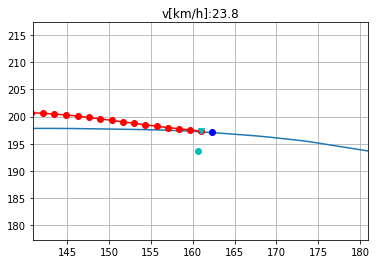

vehicle.get_transform() Transform(Location(x=232.047394, y=73.770531, z=0.019367), Rotation(pitch=0.229057, yaw=106.755035, roll=0.237266))
vehicleToFollow.get_transform() Transform(Location(x=160.980301, y=197.323273, z=2.664012), Rotation(pitch=-0.511875, yaw=170.449844, roll=0.281921))
obsticle_vehicle.get_transform() Transform(Location(x=233.886505, y=77.066017, z=0.032529), Rotation(pitch=4.141854, yaw=80.288437, roll=-0.167786))
ego_position:  (159.32443316551277, 193.83830979041443, 2.645034602188348, 3.056081109344722)
path.x[1]:  159.64255164852412
path.y[1]:  197.5494194775016
s:  212.61795113453948


In [ ]:
for fileName in drivesFileNames:
    main(optimalDistance=optimalDistance,followDrivenPath=followDrivenPath,chaseMode=chaseMode, evaluateChasingCar=evaluateChasingCar,driveName=os.path.join(drivesDir,fileName),record=record,followMode=followMode)


Saving global_route...
Done saving global_route
vehicle.get_transform(): Transform(Location(x=233.980698, y=30.523647, z=0.017047), Rotation(pitch=0.142621, yaw=87.779900, roll=0.091224))
Len of waypoints: 1388
vehicle.get_transform() Transform(Location(x=233.980164, y=30.524370, z=-0.023911), Rotation(pitch=0.243858, yaw=87.779701, roll=0.001474))
vehicleToFollow.get_transform() Transform(Location(x=0.000000, y=0.000000, z=0.000000), Rotation(pitch=0.000000, yaw=0.000000, roll=0.000000))
obsticle_vehicle.get_transform() Transform(Location(x=0.000000, y=0.000000, z=0.000000), Rotation(pitch=0.000000, yaw=0.000000, roll=0.000000))
ego_position:  (230.5044212697787, 31.201882714055486, 0.006195329939141257, 1.535875015564161)
path.x[1]:  232.0048637552265
path.y[1]:  31.14946398512681
s:  0.557444380144033


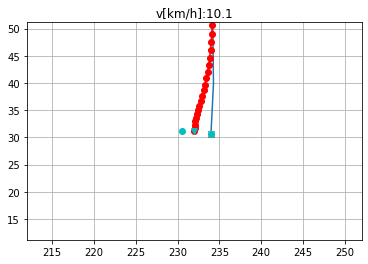

vehicle.get_transform() Transform(Location(x=233.786453, y=25.528225, z=0.004516), Rotation(pitch=0.016078, yaw=87.779816, roll=-0.002502))
vehicleToFollow.get_transform() Transform(Location(x=232.004883, y=31.149401, z=-0.010423), Rotation(pitch=-0.129664, yaw=-96.758919, roll=0.077184))
obsticle_vehicle.get_transform() Transform(Location(x=233.786453, y=75.528214, z=0.007599), Rotation(pitch=0.016966, yaw=87.779823, roll=-0.003662))
ego_position:  (230.52386330876038, 31.763761236072167, 0.006409975382526778, 1.536163965934082)
path.x[1]:  232.03313328681259
path.y[1]:  31.71147074613888
s:  1.120670555443729


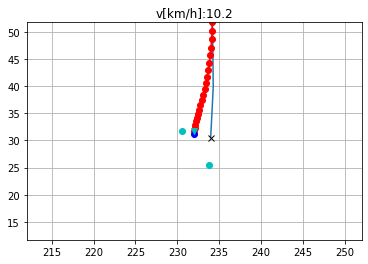

vehicle.get_transform() Transform(Location(x=233.786453, y=25.528439, z=0.001499), Rotation(pitch=0.047538, yaw=87.779831, roll=0.008199))
vehicleToFollow.get_transform() Transform(Location(x=232.033081, y=31.710932, z=-0.000862), Rotation(pitch=-0.080869, yaw=87.779793, roll=0.045505))
obsticle_vehicle.get_transform() Transform(Location(x=233.786499, y=75.528427, z=0.011363), Rotation(pitch=0.049601, yaw=87.779808, roll=-0.001556))
ego_position:  (230.54332193941747, 32.33139446035463, 0.006430374063460552, 1.5365456314788688)
path.x[1]:  232.07436488296716
path.y[1]:  32.27893465966699
s:  1.6899730447831705


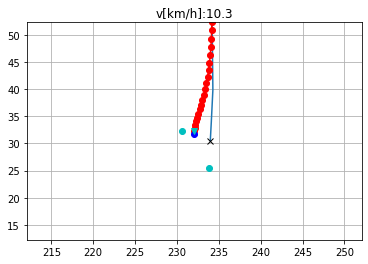

vehicle.get_transform() Transform(Location(x=233.786453, y=25.528717, z=-0.002285), Rotation(pitch=0.088389, yaw=87.779884, roll=0.023751))
vehicleToFollow.get_transform() Transform(Location(x=232.074295, y=32.278408, z=-0.000924), Rotation(pitch=-0.075959, yaw=87.779732, roll=0.043493))
obsticle_vehicle.get_transform() Transform(Location(x=233.786514, y=75.528709, z=0.016654), Rotation(pitch=0.093471, yaw=87.779800, roll=0.000930))
ego_position:  (230.56289607835586, 32.905185349460126, 0.006424300390118195, 1.5368943956703318)
path.x[1]:  232.13165738398826
path.y[1]:  32.85198092682343
s:  2.265318387733274


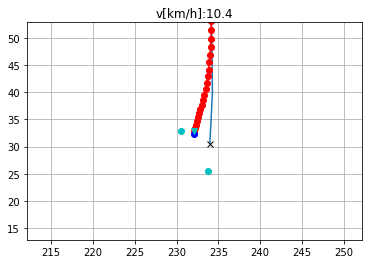

vehicle.get_transform() Transform(Location(x=233.786438, y=25.529016, z=-0.006298), Rotation(pitch=0.132185, yaw=87.779984, roll=0.040218))
vehicleToFollow.get_transform() Transform(Location(x=232.131622, y=32.851467, z=-0.000982), Rotation(pitch=-0.071382, yaw=87.779602, roll=0.041626))
obsticle_vehicle.get_transform() Transform(Location(x=233.786560, y=75.529022, z=0.022904), Rotation(pitch=0.143079, yaw=87.779800, roll=0.003344))
ego_position:  (230.58245818483852, 33.485379149066745, 0.006387924603271369, 1.5371319567353623)
path.x[1]:  232.2058340707795
path.y[1]:  33.43070856839883
s:  2.846673308121449


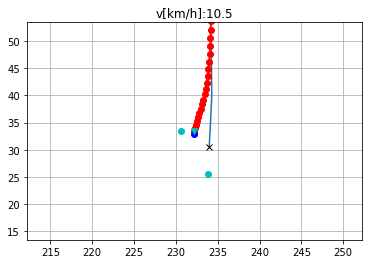

vehicle.get_transform() Transform(Location(x=233.786438, y=25.529301, z=-0.010166), Rotation(pitch=0.174115, yaw=87.780075, roll=0.054668))
vehicleToFollow.get_transform() Transform(Location(x=232.205795, y=33.430206, z=-0.001037), Rotation(pitch=-0.067195, yaw=87.779541, roll=0.039834))
obsticle_vehicle.get_transform() Transform(Location(x=233.786591, y=75.529350, z=0.029617), Rotation(pitch=0.194018, yaw=87.779800, roll=0.005479))
ego_position:  (230.60217413040178, 34.072090880195944, 0.00722245719565872, 1.5372141446779657)
path.x[1]:  232.2965110518019
path.y[1]:  34.015169949752845
s:  3.434004713016951


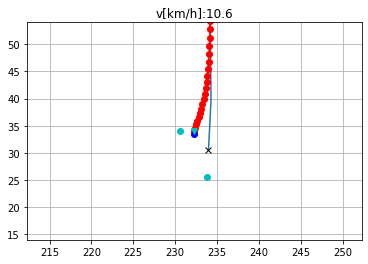

vehicle.get_transform() Transform(Location(x=233.786499, y=25.529552, z=-0.013658), Rotation(pitch=0.210957, yaw=87.780067, roll=0.063812))
vehicleToFollow.get_transform() Transform(Location(x=232.296463, y=34.014671, z=-0.001088), Rotation(pitch=-0.063418, yaw=87.779472, roll=0.038143))
obsticle_vehicle.get_transform() Transform(Location(x=233.786621, y=75.529655, z=0.036379), Rotation(pitch=0.242984, yaw=87.779800, roll=0.007240))
ego_position:  (230.62200970303374, 34.664188158869436, 0.007319175605739517, 1.5374557211153124)
path.x[1]:  232.40207835678004
path.y[1]:  34.60481759147706
s:  4.027279691721829


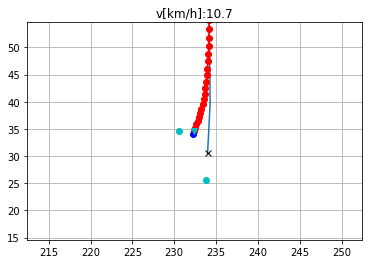

vehicle.get_transform() Transform(Location(x=233.786514, y=25.529758, z=-0.016648), Rotation(pitch=0.241010, yaw=87.780060, roll=0.070148))
vehicleToFollow.get_transform() Transform(Location(x=232.402039, y=34.604324, z=-0.001137), Rotation(pitch=-0.060024, yaw=87.779449, roll=0.036520))
obsticle_vehicle.get_transform() Transform(Location(x=233.786652, y=75.529938, z=0.042857), Rotation(pitch=0.287619, yaw=87.779800, roll=0.008613))
ego_position:  (230.641902242048, 35.262414601779014, 0.007210858188928157, 1.5376872685112741)
path.x[1]:  232.52025612523286
path.y[1]:  35.20020133899365
s:  4.626647209491507


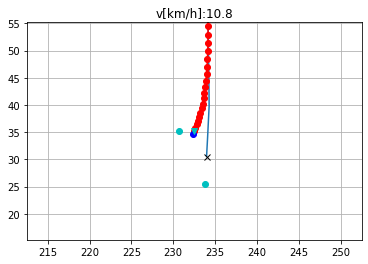

vehicle.get_transform() Transform(Location(x=233.786545, y=25.529917, z=-0.019092), Rotation(pitch=0.263618, yaw=87.780060, roll=0.072740))
vehicleToFollow.get_transform() Transform(Location(x=232.520203, y=35.199715, z=-0.001182), Rotation(pitch=-0.056943, yaw=87.779343, roll=0.034986))
obsticle_vehicle.get_transform() Transform(Location(x=233.786667, y=75.530182, z=0.048804), Rotation(pitch=0.326442, yaw=87.779808, roll=0.009629))
ego_position:  (230.66188825876, 35.8675226186988, 0.007096368052797477, 1.5377857089383358)
path.x[1]:  232.6486692574233
path.y[1]:  35.801913917369035
s:  5.232429748441631


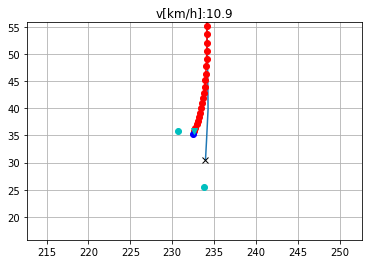

vehicle.get_transform() Transform(Location(x=233.786545, y=25.530022, z=-0.021000), Rotation(pitch=0.278993, yaw=87.780060, roll=0.071664))
vehicleToFollow.get_transform() Transform(Location(x=232.648605, y=35.801434, z=-0.001225), Rotation(pitch=-0.054225, yaw=87.779274, roll=0.033525))
obsticle_vehicle.get_transform() Transform(Location(x=233.786697, y=75.530380, z=0.054047), Rotation(pitch=0.358681, yaw=87.779831, roll=0.010342))
ego_position:  (230.6819636718658, 36.47819194030066, 0.0069761609929569314, 1.5381757685697788)
path.x[1]:  232.78472112234724
path.y[1]:  36.40957447809459
s:  5.844794188769595


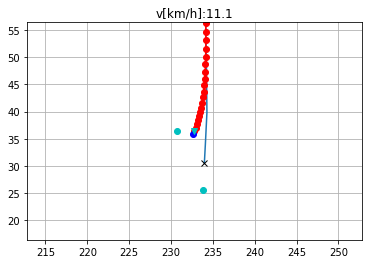

vehicle.get_transform() Transform(Location(x=233.786514, y=25.530085, z=-0.022418), Rotation(pitch=0.287927, yaw=87.780014, roll=0.067520))
vehicleToFollow.get_transform() Transform(Location(x=232.784637, y=36.409096, z=-0.001264), Rotation(pitch=-0.051793, yaw=87.779213, roll=0.032134))
obsticle_vehicle.get_transform() Transform(Location(x=233.786697, y=75.530533, z=0.058484), Rotation(pitch=0.384178, yaw=87.779831, roll=0.010815))
ego_position:  (230.70219380226533, 37.09734124335375, 0.006803829318781201, 1.538194105516449)
path.x[1]:  232.92588661843456
path.y[1]:  37.02481822126123
s:  6.464338107220209


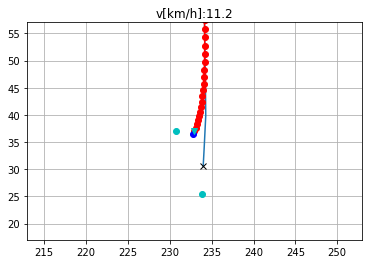

vehicle.get_transform() Transform(Location(x=233.786499, y=25.530111, z=-0.023413), Rotation(pitch=0.291519, yaw=87.780029, roll=0.061136))
vehicleToFollow.get_transform() Transform(Location(x=232.925858, y=37.024349, z=-0.001302), Rotation(pitch=-0.049649, yaw=87.779099, roll=0.030796))
obsticle_vehicle.get_transform() Transform(Location(x=233.786713, y=75.530647, z=0.062071), Rotation(pitch=0.403200, yaw=87.779839, roll=0.011107))
ego_position:  (230.72266620858665, 37.72411750499557, 0.006653890547644199, 1.5382012547206072)
path.x[1]:  233.06984076989895
path.y[1]:  37.647584075052166
s:  7.091473665595391


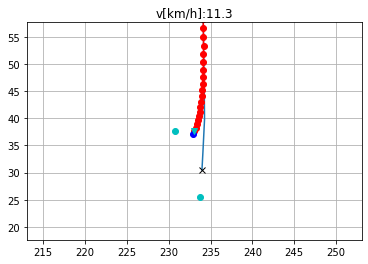

vehicle.get_transform() Transform(Location(x=233.786453, y=25.530111, z=-0.024060), Rotation(pitch=0.291014, yaw=87.780014, roll=0.053373))
vehicleToFollow.get_transform() Transform(Location(x=233.069794, y=37.647118, z=-0.001337), Rotation(pitch=-0.047729, yaw=87.779015, roll=0.029537))
obsticle_vehicle.get_transform() Transform(Location(x=233.786713, y=75.530724, z=0.064816), Rotation(pitch=0.416300, yaw=87.779839, roll=0.011271))
ego_position:  (230.74329638295188, 38.3575944415743, 0.006544293067798884, 1.538162887742825)
path.x[1]:  233.2140047033309
path.y[1]:  38.27693809872811
s:  7.725152166131189


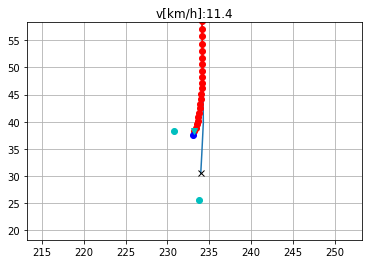

vehicle.get_transform() Transform(Location(x=233.786423, y=25.530090, z=-0.024432), Rotation(pitch=0.287612, yaw=87.779922, roll=0.045009))
vehicleToFollow.get_transform() Transform(Location(x=233.213974, y=38.276478, z=-0.001370), Rotation(pitch=-0.046015, yaw=87.778954, roll=0.028335))
obsticle_vehicle.get_transform() Transform(Location(x=233.786713, y=75.530769, z=0.066764), Rotation(pitch=0.424264, yaw=87.779839, roll=0.011348))
ego_position:  (230.76412210441654, 38.995932254215596, 0.006470429612260176, 1.5380733210399982)
path.x[1]:  233.355952311373
path.y[1]:  38.9110894942049
s:  8.363516117382852


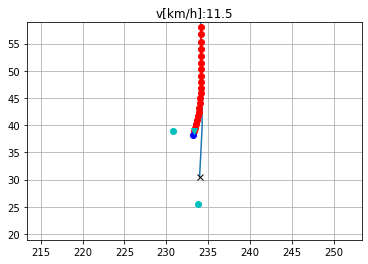

vehicle.get_transform() Transform(Location(x=233.786407, y=25.530056, z=-0.024600), Rotation(pitch=0.282401, yaw=87.779877, roll=0.036679))
vehicleToFollow.get_transform() Transform(Location(x=233.355911, y=38.910629, z=-0.001401), Rotation(pitch=-0.044519, yaw=87.778923, roll=0.027193))
obsticle_vehicle.get_transform() Transform(Location(x=233.786713, y=75.530792, z=0.067987), Rotation(pitch=0.427973, yaw=87.779861, roll=0.011371))
ego_position:  (230.78396437327308, 39.61365550570716, 0.006431323910766454, 1.5453397006759042)
path.x[1]:  233.49298918732117
path.y[1]:  39.54467797316266
s:  9.006990915634226


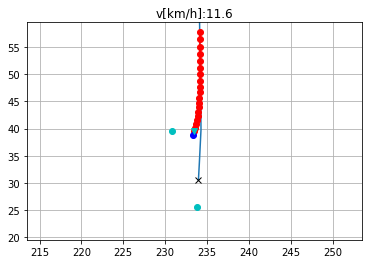

vehicle.get_transform() Transform(Location(x=233.786362, y=25.530012, z=-0.024624), Rotation(pitch=0.276288, yaw=87.779854, roll=0.028860))
vehicleToFollow.get_transform() Transform(Location(x=233.492950, y=39.544220, z=-0.001430), Rotation(pitch=-0.043180, yaw=87.778824, roll=0.026102))
obsticle_vehicle.get_transform() Transform(Location(x=233.786713, y=75.530792, z=0.068579), Rotation(pitch=0.428314, yaw=87.779861, roll=0.011365))
ego_position:  (230.78352251195818, 40.10249668359674, 0.006539898131049216, 1.5910492192693257)
path.x[1]:  233.6033293585272
path.y[1]:  40.1596137380904
s:  9.655869966042722


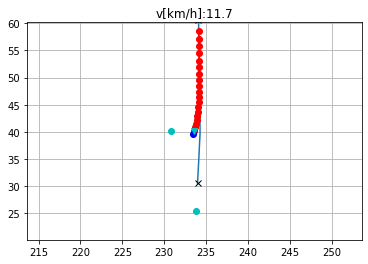

vehicle.get_transform() Transform(Location(x=233.786346, y=25.529970, z=-0.024553), Rotation(pitch=0.269977, yaw=87.779823, roll=0.021865))
vehicleToFollow.get_transform() Transform(Location(x=233.603302, y=40.159161, z=-0.001457), Rotation(pitch=-0.041992, yaw=87.778770, roll=0.025066))
obsticle_vehicle.get_transform() Transform(Location(x=233.786713, y=75.530777, z=0.068643), Rotation(pitch=0.426149, yaw=87.779861, roll=0.011345))
ego_position:  (230.77710871340406, 40.82140776081025, 0.006651407794018935, 1.5725837946119272)
path.x[1]:  233.7020119057882
path.y[1]:  40.82663593670265
s:  10.310194572208813


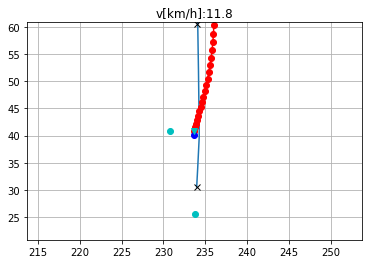

vehicle.get_transform() Transform(Location(x=233.786301, y=25.529926, z=-0.024427), Rotation(pitch=0.263980, yaw=87.779778, roll=0.015871))
vehicleToFollow.get_transform() Transform(Location(x=233.701965, y=40.826183, z=-0.001486), Rotation(pitch=-0.040469, yaw=87.770531, roll=0.024081))
obsticle_vehicle.get_transform() Transform(Location(x=233.786713, y=75.530739, z=0.068287), Rotation(pitch=0.422276, yaw=87.779839, roll=0.011322))
ego_position:  (230.7756988521073, 41.475788418348394, 0.006741110537149157, 1.574159977899408)
path.x[1]:  233.80500042701314
path.y[1]:  41.48597797036546
s:  10.970093840826909


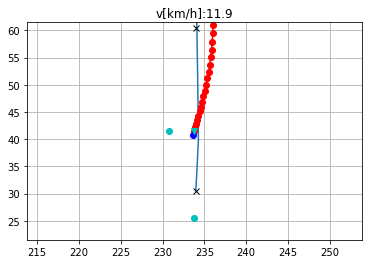

vehicle.get_transform() Transform(Location(x=233.786285, y=25.529890, z=-0.024276), Rotation(pitch=0.258632, yaw=87.779732, roll=0.010935))
vehicleToFollow.get_transform() Transform(Location(x=233.804977, y=41.485516, z=-0.001515), Rotation(pitch=-0.038754, yaw=87.771942, roll=0.023127))
obsticle_vehicle.get_transform() Transform(Location(x=233.786713, y=75.530708, z=0.067615), Rotation(pitch=0.417345, yaw=87.779823, roll=0.011302))
ego_position:  (230.77280349793534, 42.13465376606367, 0.006798563843796251, 1.5760375333500893)
path.x[1]:  233.9112126128321
path.y[1]:  42.15110296711102
s:  11.635537073911944


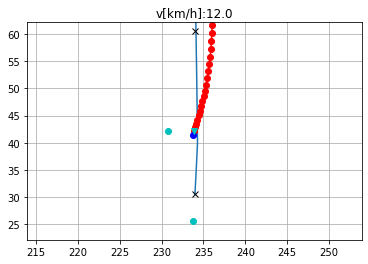

vehicle.get_transform() Transform(Location(x=233.786285, y=25.529881, z=-0.024221), Rotation(pitch=0.257075, yaw=87.779739, roll=0.009378))
vehicleToFollow.get_transform() Transform(Location(x=233.911163, y=42.150642, z=-0.001541), Rotation(pitch=-0.037443, yaw=87.784439, roll=0.022203))
obsticle_vehicle.get_transform() Transform(Location(x=233.786713, y=75.530678, z=0.066725), Rotation(pitch=0.411963, yaw=87.779808, roll=0.011288))
ego_position:  (230.76890278339624, 42.80172701657951, 0.006830133207469152, 1.5771438138077305)
path.x[1]:  234.023648783695
path.y[1]:  42.822386752011546
s:  12.306493742523402


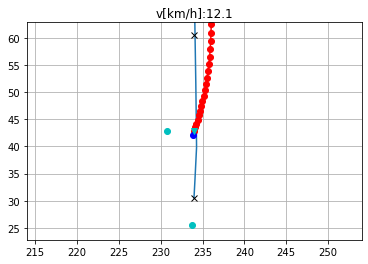

vehicle.get_transform() Transform(Location(x=233.786285, y=25.529875, z=-0.024160), Rotation(pitch=0.255838, yaw=87.779732, roll=0.007876))
vehicleToFollow.get_transform() Transform(Location(x=234.023605, y=42.821918, z=-0.001565), Rotation(pitch=-0.036316, yaw=87.786118, roll=0.021366))
obsticle_vehicle.get_transform() Transform(Location(x=233.786713, y=75.530655, z=0.065706), Rotation(pitch=0.406519, yaw=87.779800, roll=0.011282))
ego_position:  (230.7644553133245, 43.47653060733529, 0.006844809337095537, 1.5776070962838382)
path.x[1]:  234.14354220834892
path.y[1]:  43.49954514511675
s:  12.982933485834431


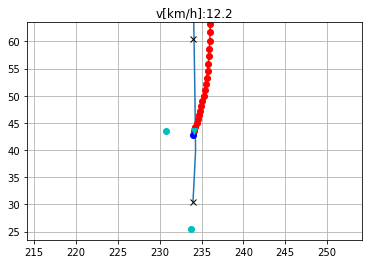

vehicle.get_transform() Transform(Location(x=233.786270, y=25.529871, z=-0.024074), Rotation(pitch=0.254192, yaw=87.779747, roll=0.006108))
vehicleToFollow.get_transform() Transform(Location(x=234.143509, y=43.499073, z=-0.001587), Rotation(pitch=-0.035462, yaw=87.784584, roll=0.020554))
obsticle_vehicle.get_transform() Transform(Location(x=233.786713, y=75.530624, z=0.064631), Rotation(pitch=0.401390, yaw=87.779785, roll=0.011278))
ego_position:  (230.75973953828674, 44.157207931984885, 0.006848820351212001, 1.577949656356142)
path.x[1]:  234.270691058806
path.y[1]:  44.18232335367259
s:  13.6648261102061


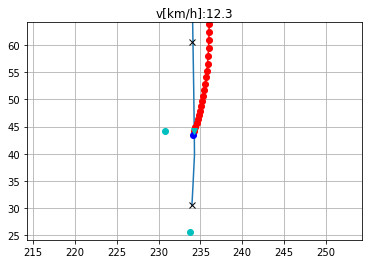

vehicle.get_transform() Transform(Location(x=233.786270, y=25.529854, z=-0.023979), Rotation(pitch=0.252403, yaw=87.779732, roll=0.004395))
vehicleToFollow.get_transform() Transform(Location(x=234.270645, y=44.181850, z=-0.001605), Rotation(pitch=-0.035216, yaw=87.789986, roll=0.019780))
obsticle_vehicle.get_transform() Transform(Location(x=233.786713, y=75.530609, z=0.063566), Rotation(pitch=0.396779, yaw=87.779778, roll=0.011278))
ego_position:  (230.75474915175516, 44.84347361471064, 0.0068470294965761345, 1.5782444132763205)
path.x[1]:  234.40377837740985
path.y[1]:  44.87065240253037
s:  14.352141588266747


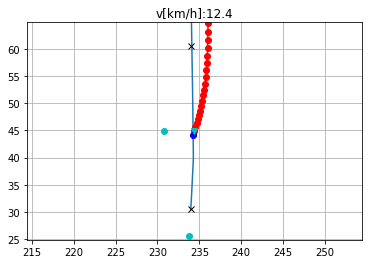

vehicle.get_transform() Transform(Location(x=233.786270, y=25.529840, z=-0.023885), Rotation(pitch=0.250682, yaw=87.779732, roll=0.002901))
vehicleToFollow.get_transform() Transform(Location(x=234.403732, y=44.870186, z=-0.001619), Rotation(pitch=-0.035742, yaw=87.847977, roll=0.019004))
obsticle_vehicle.get_transform() Transform(Location(x=233.786713, y=75.530594, z=0.062557), Rotation(pitch=0.392818, yaw=87.779762, roll=0.011282))
ego_position:  (230.74954786003812, 45.535530180021254, 0.0068420885493727735, 1.5784250871601637)
path.x[1]:  234.54104625004481
path.y[1]:  45.564455173791536
s:  15.044850057996381


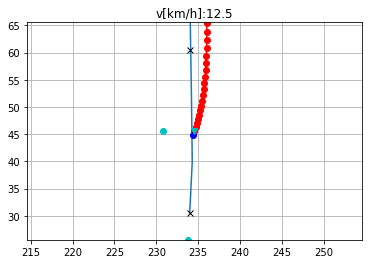

vehicle.get_transform() Transform(Location(x=233.786240, y=25.529837, z=-0.023798), Rotation(pitch=0.249145, yaw=87.779732, roll=0.001699))
vehicleToFollow.get_transform() Transform(Location(x=234.541016, y=45.564007, z=-0.001628), Rotation(pitch=-0.036958, yaw=87.914383, roll=0.018297))
obsticle_vehicle.get_transform() Transform(Location(x=233.786713, y=75.530563, z=0.061642), Rotation(pitch=0.389573, yaw=87.779785, roll=0.011289))
ego_position:  (230.7441598273268, 46.232642718022106, 0.006835889860248999, 1.5786932020683513)
path.x[1]:  234.68042831507023
path.y[1]:  46.26372758547273
s:  15.74292182181616


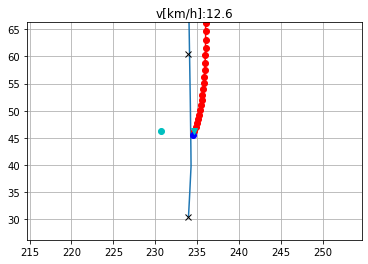

vehicle.get_transform() Transform(Location(x=233.786240, y=25.529831, z=-0.023723), Rotation(pitch=0.247874, yaw=87.779732, roll=0.000796))
vehicleToFollow.get_transform() Transform(Location(x=234.680389, y=46.263309, z=-0.001634), Rotation(pitch=-0.038604, yaw=87.978477, roll=0.017587))
obsticle_vehicle.get_transform() Transform(Location(x=233.786713, y=75.530548, z=0.060844), Rotation(pitch=0.387053, yaw=87.779762, roll=0.011294))
ego_position:  (230.7386029671399, 46.93571176769101, 0.006829138521230673, 1.5787830634824693)
path.x[1]:  234.81979812023442
path.y[1]:  46.968307891832445
s:  16.44632734568285


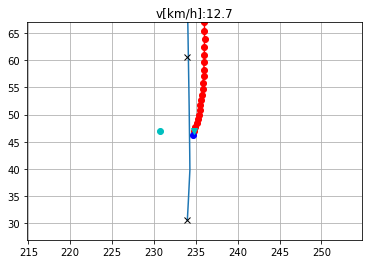

vehicle.get_transform() Transform(Location(x=233.786240, y=25.529825, z=-0.023661), Rotation(pitch=0.246904, yaw=87.779732, roll=0.000172))
vehicleToFollow.get_transform() Transform(Location(x=234.819748, y=46.967918, z=-0.001638), Rotation(pitch=-0.040530, yaw=88.029213, roll=0.016979))
obsticle_vehicle.get_transform() Transform(Location(x=233.786697, y=75.530533, z=0.060178), Rotation(pitch=0.385209, yaw=87.779778, roll=0.011299))
ego_position:  (230.73284249344127, 47.64358495654406, 0.006822870871802017, 1.579015430493515)
path.x[1]:  234.95703332371073
path.y[1]:  47.6783048008419
s:  17.155037258188283


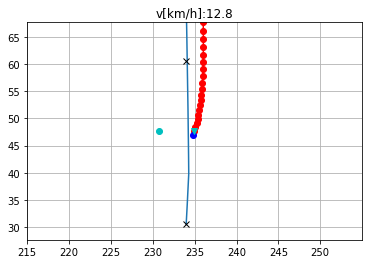

vehicle.get_transform() Transform(Location(x=233.786240, y=25.529823, z=-0.023613), Rotation(pitch=0.246201, yaw=87.779732, roll=-0.000214))
vehicleToFollow.get_transform() Transform(Location(x=234.956985, y=47.677963, z=-0.001639), Rotation(pitch=-0.043085, yaw=88.034782, roll=0.016415))
obsticle_vehicle.get_transform() Transform(Location(x=233.786697, y=75.530518, z=0.059647), Rotation(pitch=0.383986, yaw=87.779785, roll=0.011302))
ego_position:  (230.72687895482036, 48.35683178231661, 0.006816573372011266, 1.579219240053114)
path.x[1]:  235.0902380617777
path.y[1]:  48.39358484674752
s:  17.869022349663783


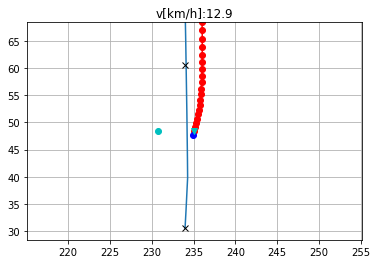

vehicle.get_transform() Transform(Location(x=233.786240, y=25.529823, z=-0.023577), Rotation(pitch=0.245757, yaw=87.779732, roll=-0.000397))
vehicleToFollow.get_transform() Transform(Location(x=235.090195, y=48.393303, z=-0.001639), Rotation(pitch=-0.045598, yaw=88.017807, roll=0.015860))
obsticle_vehicle.get_transform() Transform(Location(x=233.786697, y=75.530510, z=0.059248), Rotation(pitch=0.383276, yaw=87.779778, roll=0.011304))
ego_position:  (230.72077864808628, 49.07532890249181, 0.006810834429248881, 1.5794215839755619)
path.x[1]:  235.21781716967988
path.y[1]:  49.114117978201904
s:  18.58825357128951


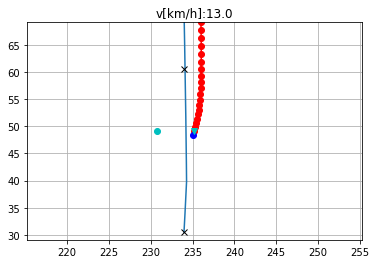

vehicle.get_transform() Transform(Location(x=233.786240, y=25.529821, z=-0.023552), Rotation(pitch=0.245511, yaw=87.779732, roll=-0.000458))
vehicleToFollow.get_transform() Transform(Location(x=235.217804, y=49.113895, z=-0.001641), Rotation(pitch=-0.047695, yaw=88.018509, roll=0.015310))
obsticle_vehicle.get_transform() Transform(Location(x=233.786697, y=75.530510, z=0.058973), Rotation(pitch=0.382996, yaw=87.779778, roll=0.011306))
ego_position:  (230.7144789160215, 49.799223134860334, 0.0068057646210318914, 1.5795721037244694)
path.x[1]:  235.33832833775168
path.y[1]:  49.839802047665046
s:  19.312702034208712


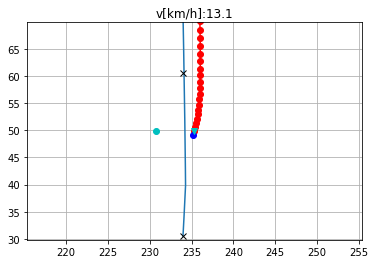

vehicle.get_transform() Transform(Location(x=233.786240, y=25.529821, z=-0.023536), Rotation(pitch=0.245511, yaw=87.779732, roll=-0.000458))
vehicleToFollow.get_transform() Transform(Location(x=235.338333, y=49.839642, z=-0.001648), Rotation(pitch=-0.048774, yaw=88.020546, roll=0.014796))
obsticle_vehicle.get_transform() Transform(Location(x=233.786697, y=75.530510, z=0.058808), Rotation(pitch=0.382996, yaw=87.779778, roll=0.011306))
ego_position:  (230.70798529737797, 50.52803704536658, 0.006800953333902243, 1.5797989992605526)
path.x[1]:  235.4506845927421
path.y[1]:  50.57073516726612
s:  20.042339008646866


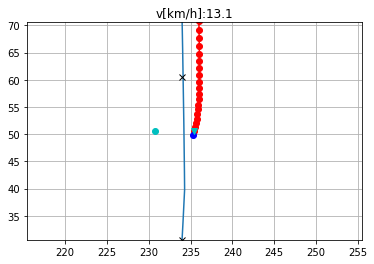

vehicle.get_transform() Transform(Location(x=233.786240, y=25.529821, z=-0.023536), Rotation(pitch=0.245511, yaw=87.779732, roll=-0.000458))
vehicleToFollow.get_transform() Transform(Location(x=235.450821, y=50.570633, z=-0.001658), Rotation(pitch=-0.049191, yaw=88.022011, roll=0.014944))
obsticle_vehicle.get_transform() Transform(Location(x=233.786697, y=75.530518, z=0.058740), Rotation(pitch=0.383351, yaw=87.779778, roll=0.011316))
ego_position:  (230.70130989383048, 51.261983252537895, 0.006796562734033487, 1.580033384742741)
path.x[1]:  235.5541061719131
path.y[1]:  51.306810087898484
s:  20.777135923035647


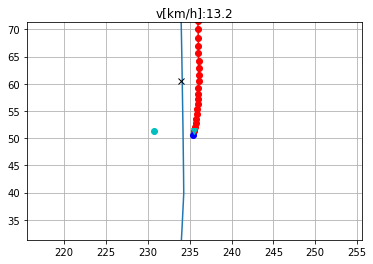

vehicle.get_transform() Transform(Location(x=233.786240, y=25.529821, z=-0.023529), Rotation(pitch=0.245518, yaw=87.779732, roll=-0.000244))
vehicleToFollow.get_transform() Transform(Location(x=235.554230, y=51.306767, z=-0.001672), Rotation(pitch=-0.048897, yaw=88.024254, roll=0.014419))
obsticle_vehicle.get_transform() Transform(Location(x=233.786697, y=75.530518, z=0.058750), Rotation(pitch=0.383802, yaw=87.779785, roll=0.011318))
ego_position:  (230.69436539755554, 52.00077818096842, 0.006854024079884031, 1.5803479184445564)
path.x[1]:  235.64798664254243
path.y[1]:  52.04809458723407
s:  21.517064363141753


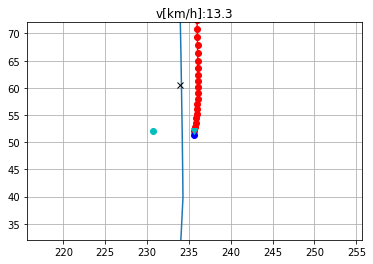

vehicle.get_transform() Transform(Location(x=233.786240, y=25.529821, z=-0.023532), Rotation(pitch=0.245668, yaw=87.779732, roll=-0.000092))
vehicleToFollow.get_transform() Transform(Location(x=235.648102, y=52.048130, z=-0.001671), Rotation(pitch=-0.046780, yaw=88.026459, roll=0.011382))
obsticle_vehicle.get_transform() Transform(Location(x=233.786697, y=75.530518, z=0.058750), Rotation(pitch=0.383802, yaw=87.779785, roll=0.011318))
ego_position:  (230.68725648776552, 52.74623070924172, 0.007071678215823795, 1.5802179898269721)
path.x[1]:  235.73219601814284
path.y[1]:  52.793763835991776
s:  22.26209607120048


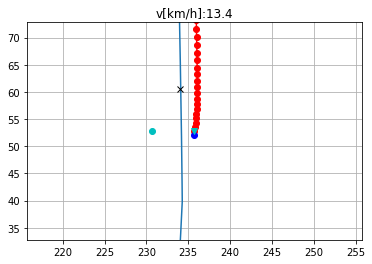

vehicle.get_transform() Transform(Location(x=233.786240, y=25.529823, z=-0.023535), Rotation(pitch=0.245839, yaw=87.779732, roll=0.000067))
vehicleToFollow.get_transform() Transform(Location(x=235.732178, y=52.793892, z=-0.001576), Rotation(pitch=-0.038358, yaw=88.028725, roll=-0.005188))
obsticle_vehicle.get_transform() Transform(Location(x=233.786697, y=75.530518, z=0.058750), Rotation(pitch=0.383802, yaw=87.779785, roll=0.011318))
ego_position:  (230.68008131710394, 53.495606209359025, 0.0074959432882463735, 1.5804171049120856)
path.x[1]:  235.80676363011
path.y[1]:  53.544930404184655
s:  23.01220294505412


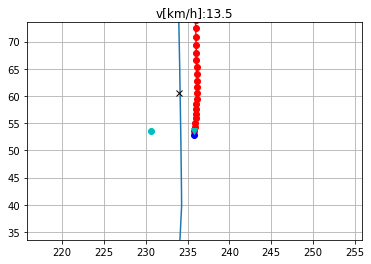

vehicle.get_transform() Transform(Location(x=233.786240, y=25.529823, z=-0.023539), Rotation(pitch=0.246017, yaw=87.779732, roll=0.000212))
vehicleToFollow.get_transform() Transform(Location(x=235.806732, y=53.545208, z=-0.001355), Rotation(pitch=-0.022246, yaw=88.031029, roll=-0.007690))
obsticle_vehicle.get_transform() Transform(Location(x=233.786697, y=75.530518, z=0.058750), Rotation(pitch=0.383802, yaw=87.779785, roll=0.011318))
ego_position:  (230.67264003902102, 54.24931695014436, 0.008087482171820481, 1.5808189267782145)
path.x[1]:  235.87165758775765
path.y[1]:  54.30142636819391
s:  23.767357037295078


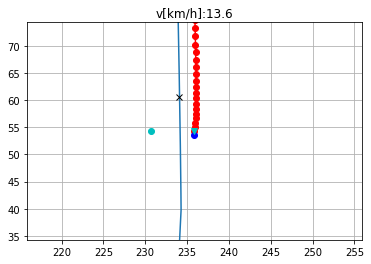

vehicle.get_transform() Transform(Location(x=233.786240, y=25.529823, z=-0.023542), Rotation(pitch=0.246180, yaw=87.779732, roll=0.000334))
vehicleToFollow.get_transform() Transform(Location(x=235.871628, y=54.301846, z=-0.001106), Rotation(pitch=-0.004064, yaw=88.033241, roll=-0.009796))
obsticle_vehicle.get_transform() Transform(Location(x=233.786697, y=75.530518, z=0.058750), Rotation(pitch=0.383802, yaw=87.779785, roll=0.011318))
ego_position:  (230.66503919708967, 55.009484308835475, 0.008919435445822273, 1.5808537826129492)
path.x[1]:  235.9273308829522
path.y[1]:  55.062411359546154
s:  24.52768484760189


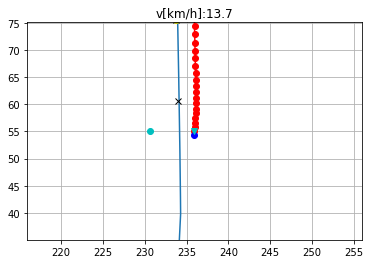

vehicle.get_transform() Transform(Location(x=233.786240, y=25.529823, z=-0.023546), Rotation(pitch=0.246331, yaw=87.779732, roll=0.000430))
vehicleToFollow.get_transform() Transform(Location(x=235.927322, y=55.062988, z=-0.000826), Rotation(pitch=0.015607, yaw=88.035492, roll=-0.012268))
obsticle_vehicle.get_transform() Transform(Location(x=233.786697, y=75.530518, z=0.058750), Rotation(pitch=0.383802, yaw=87.779785, roll=0.011318))
ego_position:  (230.65724718396152, 55.77438191838477, 0.009994994661698902, 1.581049198649313)
path.x[1]:  235.97415252442292
path.y[1]:  55.828897377762765
s:  25.29330685848188


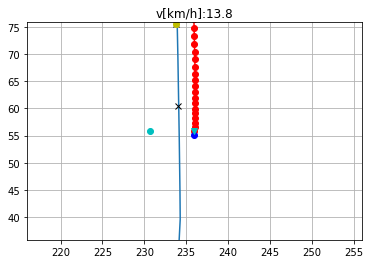

vehicle.get_transform() Transform(Location(x=233.786240, y=25.529825, z=-0.023548), Rotation(pitch=0.246447, yaw=87.779732, roll=0.000502))
vehicleToFollow.get_transform() Transform(Location(x=235.974014, y=55.829582, z=-0.000364), Rotation(pitch=0.030333, yaw=88.037781, roll=-0.026703))
obsticle_vehicle.get_transform() Transform(Location(x=233.786697, y=75.530518, z=0.058750), Rotation(pitch=0.383802, yaw=87.779785, roll=0.011318))
ego_position:  (230.64928666993274, 56.54447604429387, 0.011192557633920106, 1.5812705290001776)
path.x[1]:  236.0126981668027
path.y[1]:  56.600655555301586
s:  26.064217715811658


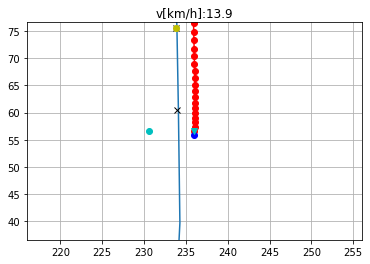

vehicle.get_transform() Transform(Location(x=233.786240, y=25.529825, z=-0.023551), Rotation(pitch=0.246447, yaw=87.779732, roll=0.000502))
vehicleToFollow.get_transform() Transform(Location(x=236.012512, y=56.601414, z=0.000293), Rotation(pitch=0.039410, yaw=88.040245, roll=-0.030670))
obsticle_vehicle.get_transform() Transform(Location(x=233.786697, y=75.530518, z=0.058750), Rotation(pitch=0.383802, yaw=87.779785, roll=0.011318))
ego_position:  (230.64114744573976, 57.32064132412821, 0.012442014803896884, 1.5813497052250225)
path.x[1]:  236.04355507005968
path.y[1]:  57.37765709292471
s:  26.840703792246277


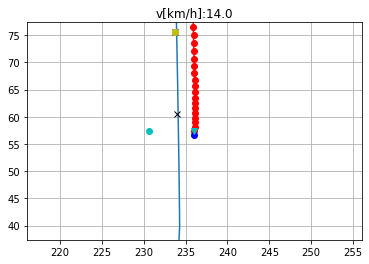

vehicle.get_transform() Transform(Location(x=233.786240, y=25.529825, z=-0.023552), Rotation(pitch=0.246611, yaw=87.779732, roll=0.000586))
vehicleToFollow.get_transform() Transform(Location(x=236.043350, y=57.378494, z=0.001023), Rotation(pitch=0.047886, yaw=88.042725, roll=-0.033630))
obsticle_vehicle.get_transform() Transform(Location(x=233.786697, y=75.530518, z=0.058750), Rotation(pitch=0.383802, yaw=87.779785, roll=0.011318))
ego_position:  (230.6328524495673, 58.10202245500309, 0.01370900108471543, 1.5814311249205872)
path.x[1]:  236.06741823553995
path.y[1]:  58.1598201440064
s:  27.62241494651037


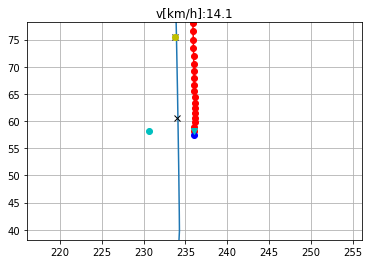

vehicle.get_transform() Transform(Location(x=233.786240, y=25.529825, z=-0.023553), Rotation(pitch=0.246611, yaw=87.779732, roll=0.000586))
vehicleToFollow.get_transform() Transform(Location(x=236.067215, y=58.160702, z=0.001816), Rotation(pitch=0.056178, yaw=88.045372, roll=-0.036407))
obsticle_vehicle.get_transform() Transform(Location(x=233.786697, y=75.530518, z=0.058750), Rotation(pitch=0.383802, yaw=87.779785, roll=0.011318))
ego_position:  (230.6244798996159, 58.88913431666485, 0.014979844031845008, 1.5814487638099584)
path.x[1]:  236.08505337969927
path.y[1]:  58.94730493203637
s:  28.40963409840983


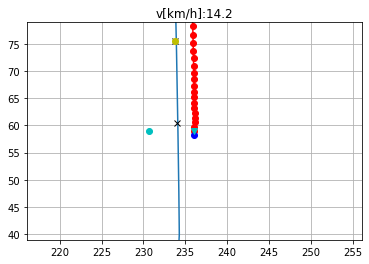

vehicle.get_transform() Transform(Location(x=233.786240, y=25.529825, z=-0.023553), Rotation(pitch=0.246611, yaw=87.779732, roll=0.000586))
vehicleToFollow.get_transform() Transform(Location(x=236.084839, y=58.948250, z=0.002670), Rotation(pitch=0.064204, yaw=88.048019, roll=-0.039093))
obsticle_vehicle.get_transform() Transform(Location(x=233.786697, y=75.530518, z=0.058750), Rotation(pitch=0.383802, yaw=87.779785, roll=0.011318))
ego_position:  (230.61602360554528, 59.681483709077185, 0.016248725388424517, 1.5814446775759954)
path.x[1]:  236.09716891670683
path.y[1]:  59.73985107309
s:  29.20201532838874


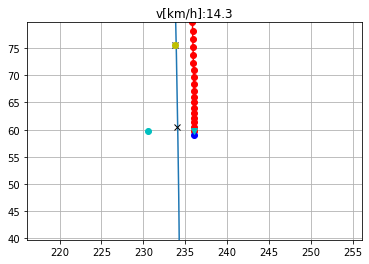

vehicle.get_transform() Transform(Location(x=233.786240, y=25.529825, z=-0.023554), Rotation(pitch=0.246611, yaw=87.779732, roll=0.000586))
vehicleToFollow.get_transform() Transform(Location(x=236.096924, y=59.740845, z=0.003583), Rotation(pitch=0.071956, yaw=88.050781, roll=-0.041595))
obsticle_vehicle.get_transform() Transform(Location(x=233.786697, y=75.530518, z=0.058750), Rotation(pitch=0.383802, yaw=87.779785, roll=0.011318))
ego_position:  (230.6075164933895, 60.479541000172276, 0.017515659727705263, 1.5814622225525827)
path.x[1]:  236.10448361844126
path.y[1]:  60.53817330189129
s:  30.0001803730792


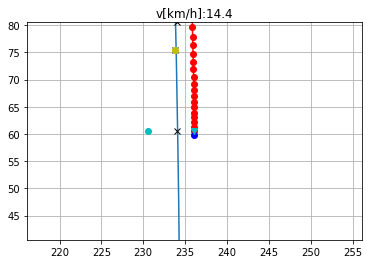

vehicle.get_transform() Transform(Location(x=233.786240, y=25.529825, z=-0.023554), Rotation(pitch=0.246611, yaw=87.779732, roll=0.000586))
vehicleToFollow.get_transform() Transform(Location(x=236.104218, y=60.539207, z=0.004555), Rotation(pitch=0.079401, yaw=88.053574, roll=-0.044006))
obsticle_vehicle.get_transform() Transform(Location(x=233.786697, y=75.530518, z=0.058750), Rotation(pitch=0.383802, yaw=87.779785, roll=0.011318))
ego_position:  (230.59893368668756, 61.28380201543158, 0.018781654735346532, 1.5814697318153257)
path.x[1]:  236.10765977110975
path.y[1]:  61.34260111292278
s:  30.80451446220712


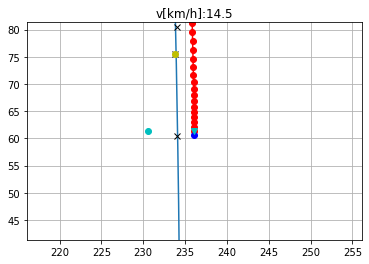

vehicle.get_transform() Transform(Location(x=233.786240, y=25.529825, z=-0.023554), Rotation(pitch=0.246611, yaw=87.779732, roll=0.000586))
vehicleToFollow.get_transform() Transform(Location(x=236.107376, y=61.343685, z=0.005584), Rotation(pitch=0.086538, yaw=88.056519, roll=-0.046295))
obsticle_vehicle.get_transform() Transform(Location(x=233.786697, y=75.530518, z=0.058750), Rotation(pitch=0.383802, yaw=87.779785, roll=0.011318))
ego_position:  (230.59027423145022, 62.09420662281423, 0.02007555379586426, 1.5814412023706585)
path.x[1]:  236.107332256889
path.y[1]:  62.152937237377444
s:  31.614866513106286


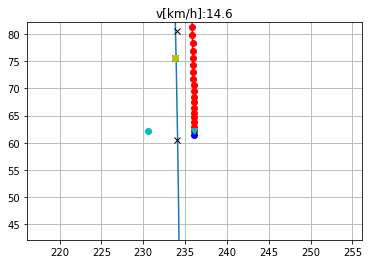

vehicle.get_transform() Transform(Location(x=233.786240, y=25.529825, z=-0.023554), Rotation(pitch=0.246611, yaw=87.779732, roll=0.000586))
vehicleToFollow.get_transform() Transform(Location(x=236.107025, y=62.154072, z=0.006668), Rotation(pitch=0.093376, yaw=88.059402, roll=-0.048462))
obsticle_vehicle.get_transform() Transform(Location(x=233.786697, y=75.530518, z=0.058750), Rotation(pitch=0.383802, yaw=87.779785, roll=0.011318))
ego_position:  (230.58157739110877, 62.908817792284395, 0.021416507752846013, 1.5815274502651786)
path.x[1]:  236.10411857679347
path.y[1]:  62.9680831385752
s:  32.42982707648352


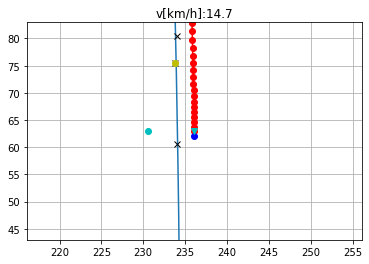

vehicle.get_transform() Transform(Location(x=233.786240, y=25.529825, z=-0.023554), Rotation(pitch=0.246611, yaw=87.779732, roll=0.000586))
vehicleToFollow.get_transform() Transform(Location(x=236.103821, y=62.969231, z=0.007806), Rotation(pitch=0.099878, yaw=88.062523, roll=-0.050507))
obsticle_vehicle.get_transform() Transform(Location(x=233.786697, y=75.530518, z=0.058750), Rotation(pitch=0.383802, yaw=87.779785, roll=0.011318))
ego_position:  (230.57277836619681, 63.72910631202402, 0.022765351332218364, 1.5815553982872914)
path.x[1]:  236.09848902245992
path.y[1]:  63.78856012211592
s:  33.2502617140428


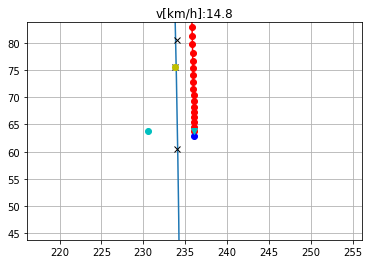

vehicle.get_transform() Transform(Location(x=233.786240, y=25.529825, z=-0.023554), Rotation(pitch=0.246611, yaw=87.779732, roll=0.000586))
vehicleToFollow.get_transform() Transform(Location(x=236.098190, y=63.789761, z=0.008996), Rotation(pitch=0.106086, yaw=88.065605, roll=-0.052460))
obsticle_vehicle.get_transform() Transform(Location(x=233.786697, y=75.530518, z=0.058750), Rotation(pitch=0.383802, yaw=87.779785, roll=0.011318))
ego_position:  (230.5637914674965, 64.55435083178847, 0.024107481212232617, 1.5817782251961485)
path.x[1]:  236.0908063095747
path.y[1]:  64.61505038743049
s:  34.07633615144892


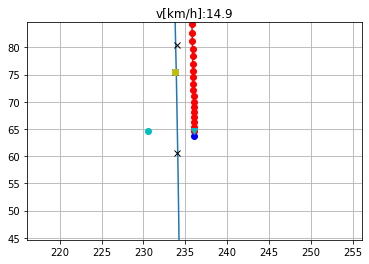

vehicle.get_transform() Transform(Location(x=233.786240, y=25.529825, z=-0.023553), Rotation(pitch=0.246611, yaw=87.779732, roll=0.000586))
vehicleToFollow.get_transform() Transform(Location(x=236.090485, y=64.616280, z=0.010238), Rotation(pitch=0.111974, yaw=88.068817, roll=-0.054321))
obsticle_vehicle.get_transform() Transform(Location(x=233.786697, y=75.530518, z=0.058750), Rotation(pitch=0.383802, yaw=87.779785, roll=0.011318))
ego_position:  (230.55462981719737, 65.38474304313463, 0.02543813992679203, 1.5818523710744405)
path.x[1]:  236.08229019444622
path.y[1]:  65.44585959126454
s:  34.90703947677815


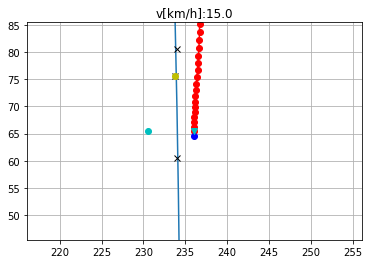

vehicle.get_transform() Transform(Location(x=233.786240, y=25.529825, z=-0.023553), Rotation(pitch=0.246611, yaw=87.779732, roll=0.000586))
vehicleToFollow.get_transform() Transform(Location(x=236.081970, y=65.447121, z=0.011528), Rotation(pitch=0.117568, yaw=88.072060, roll=-0.056091))
obsticle_vehicle.get_transform() Transform(Location(x=233.786697, y=75.530518, z=0.058750), Rotation(pitch=0.383802, yaw=87.779785, roll=0.011318))
ego_position:  (230.545259455132, 66.21905242443881, 0.026759341691385625, 1.5820864581476624)
path.x[1]:  236.07583976224643
path.y[1]:  66.28149605575453
s:  35.742221829589205


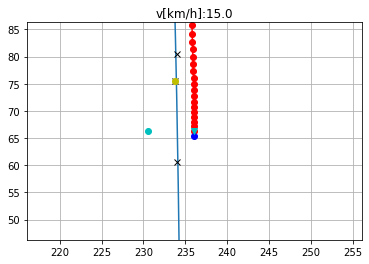

vehicle.get_transform() Transform(Location(x=233.786560, y=25.537033, z=-0.023223), Rotation(pitch=0.210008, yaw=87.777382, roll=-0.002350))
vehicleToFollow.get_transform() Transform(Location(x=236.075500, y=66.282784, z=0.012865), Rotation(pitch=0.122896, yaw=88.075386, roll=-0.057739))
obsticle_vehicle.get_transform() Transform(Location(x=233.786697, y=75.530518, z=0.058750), Rotation(pitch=0.383802, yaw=87.779785, roll=0.011318))
ego_position:  (230.53566384104636, 67.05775884390047, 0.028073635327769145, 1.5823421413584233)
path.x[1]:  236.07109901412588
path.y[1]:  67.12167279199656
s:  36.5818790632036


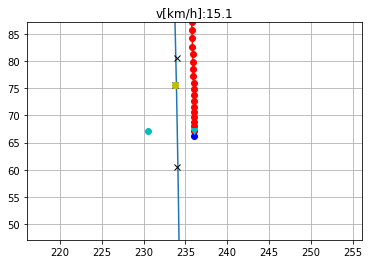

vehicle.get_transform() Transform(Location(x=233.787674, y=25.562225, z=-0.022283), Rotation(pitch=0.110253, yaw=87.770020, roll=-0.013947))
vehicleToFollow.get_transform() Transform(Location(x=236.071182, y=67.123131, z=0.014681), Rotation(pitch=0.151869, yaw=88.078972, roll=0.000132))
obsticle_vehicle.get_transform() Transform(Location(x=233.786697, y=75.530518, z=0.058750), Rotation(pitch=0.383802, yaw=87.779785, roll=0.011318))
ego_position:  (230.52582557785064, 67.90202971981812, 0.02937687189515123, 1.5825342929733783)
path.x[1]:  236.06695310862486
path.y[1]:  67.96707427466878
s:  37.4268807946888


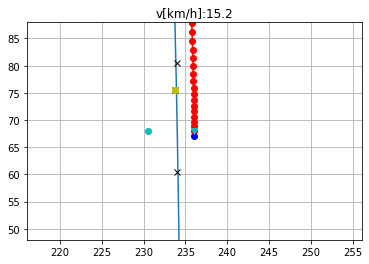

vehicle.get_transform() Transform(Location(x=233.789505, y=25.603783, z=-0.021082), Rotation(pitch=-0.011536, yaw=87.758865, roll=-0.030273))
vehicleToFollow.get_transform() Transform(Location(x=236.066711, y=67.968742, z=0.016880), Rotation(pitch=0.186567, yaw=88.082924, roll=-0.047852))
obsticle_vehicle.get_transform() Transform(Location(x=233.786697, y=75.530518, z=0.058750), Rotation(pitch=0.383802, yaw=87.779785, roll=0.011318))
ego_position:  (230.51616904417284, 68.75503058852715, 0.031067033727926508, 1.5820765492859568)
path.x[1]:  236.0630567059837
path.y[1]:  68.81760336949934
s:  38.27833590631652


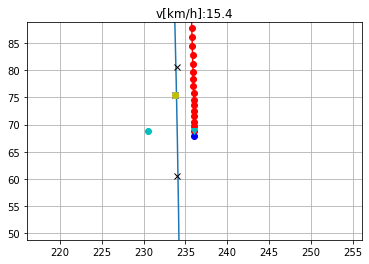

vehicle.get_transform() Transform(Location(x=233.792023, y=25.660255, z=-0.019871), Rotation(pitch=-0.130033, yaw=87.745956, roll=-0.045746))
vehicleToFollow.get_transform() Transform(Location(x=236.062668, y=68.819389, z=0.018671), Rotation(pitch=0.202078, yaw=88.085419, roll=-0.065918))
obsticle_vehicle.get_transform() Transform(Location(x=233.786697, y=75.530518, z=0.058750), Rotation(pitch=0.383802, yaw=87.779785, roll=0.011318))
ego_position:  (230.5056115753934, 69.60647117191768, 0.03311007980186667, 1.5838974947063678)
path.x[1]:  236.05750946737388
path.y[1]:  69.679211680217
s:  39.136217827422655


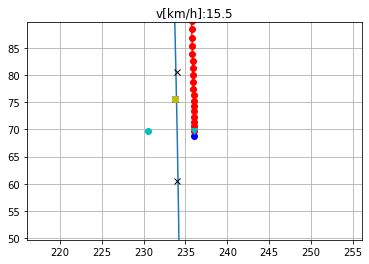

vehicle.get_transform() Transform(Location(x=233.795151, y=25.730381, z=-0.018810), Rotation(pitch=-0.231175, yaw=87.731750, roll=-0.057648))
vehicleToFollow.get_transform() Transform(Location(x=236.057175, y=69.681015, z=0.020444), Rotation(pitch=0.205493, yaw=88.088684, roll=-0.058899))
obsticle_vehicle.get_transform() Transform(Location(x=233.786697, y=75.530518, z=0.058750), Rotation(pitch=0.383802, yaw=87.779785, roll=0.011318))
ego_position:  (230.4944696283735, 70.47244436207917, 0.03542274918939084, 1.5830609200752614)
path.x[1]:  236.0505945386523
path.y[1]:  70.54059139125059
s:  39.999337790463954


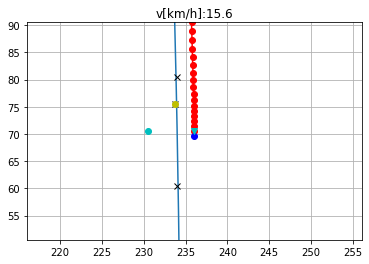

vehicle.get_transform() Transform(Location(x=233.798843, y=25.813066, z=-0.017987), Rotation(pitch=-0.308684, yaw=87.717339, roll=-0.063751))
vehicleToFollow.get_transform() Transform(Location(x=236.050476, y=70.542221, z=0.022778), Rotation(pitch=0.184149, yaw=88.092506, roll=-0.028900))
obsticle_vehicle.get_transform() Transform(Location(x=233.786697, y=75.530518, z=0.058750), Rotation(pitch=0.383802, yaw=87.779785, roll=0.011318))
ego_position:  (230.484154553224, 71.34073617890333, 0.038001436893646996, 1.5831191788662324)
path.x[1]:  236.0440797158647
path.y[1]:  71.40925378243934
s:  40.86789859679069


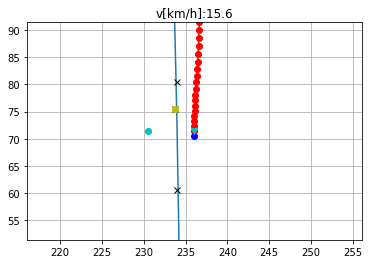

vehicle.get_transform() Transform(Location(x=233.803009, y=25.907360, z=-0.017433), Rotation(pitch=-0.361331, yaw=87.703453, roll=-0.063843))
vehicleToFollow.get_transform() Transform(Location(x=236.043900, y=71.410866, z=0.025521), Rotation(pitch=0.186068, yaw=88.097397, roll=-0.037628))
obsticle_vehicle.get_transform() Transform(Location(x=233.786697, y=75.530518, z=0.058750), Rotation(pitch=0.383802, yaw=87.779785, roll=0.011318))
ego_position:  (230.47281185500086, 72.21215697872543, 0.040600525574211344, 1.5835355190337008)
path.x[1]:  236.03867089963265
path.y[1]:  72.28306536294735
s:  41.740854331418795


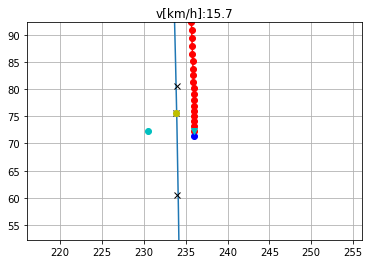

vehicle.get_transform() Transform(Location(x=233.807648, y=26.012426, z=-0.017143), Rotation(pitch=-0.390926, yaw=87.688469, roll=-0.060242))
vehicleToFollow.get_transform() Transform(Location(x=236.038498, y=72.285034, z=0.028281), Rotation(pitch=0.241584, yaw=88.100853, roll=-0.040100))
obsticle_vehicle.get_transform() Transform(Location(x=233.786697, y=75.530518, z=0.058750), Rotation(pitch=0.383802, yaw=87.779785, roll=0.011318))
ego_position:  (230.46161541175513, 73.08856631658233, 0.04385440845056083, 1.5837754004042794)
path.x[1]:  236.03491819597508
path.y[1]:  73.16090668577661
s:  42.61818079280342


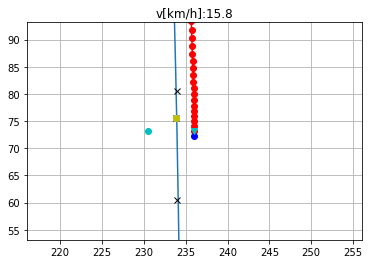

vehicle.get_transform() Transform(Location(x=233.812744, y=26.127523, z=-0.017082), Rotation(pitch=-0.400946, yaw=87.671181, roll=-0.054291))
vehicleToFollow.get_transform() Transform(Location(x=236.034744, y=73.163239, z=0.031145), Rotation(pitch=0.301013, yaw=88.104668, roll=-0.040253))
obsticle_vehicle.get_transform() Transform(Location(x=233.786697, y=75.530518, z=0.058750), Rotation(pitch=0.383802, yaw=87.779785, roll=0.011318))
ego_position:  (230.45011429475133, 73.96998724058895, 0.04722902626340432, 1.5839060363710644)
path.x[1]:  236.0310994198361
path.y[1]:  74.04315652650963
s:  43.5001404309297


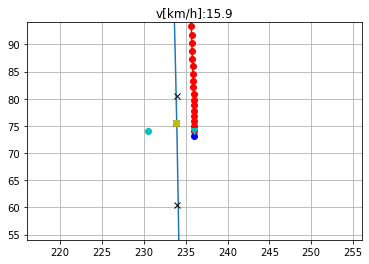

vehicle.get_transform() Transform(Location(x=233.818298, y=26.252008, z=-0.017209), Rotation(pitch=-0.395475, yaw=87.653107, roll=-0.045715))
vehicleToFollow.get_transform() Transform(Location(x=236.031036, y=74.045822, z=0.034316), Rotation(pitch=0.357451, yaw=88.108078, roll=-0.026276))
obsticle_vehicle.get_transform() Transform(Location(x=233.786697, y=75.530518, z=0.058750), Rotation(pitch=0.383802, yaw=87.779785, roll=0.011318))
ego_position:  (230.43857453749604, 74.85783951439682, 0.05090723388266576, 1.583851268045007)
path.x[1]:  236.02646973762978
path.y[1]:  74.93079330253438
s:  44.38788363165023


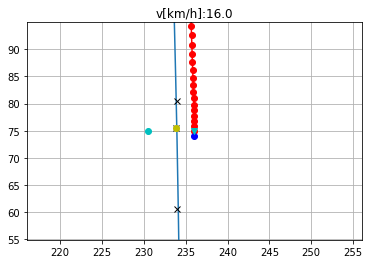

vehicle.get_transform() Transform(Location(x=233.824219, y=26.385353, z=-0.017472), Rotation(pitch=-0.378666, yaw=87.635834, roll=-0.035248))
vehicleToFollow.get_transform() Transform(Location(x=236.026520, y=74.933540, z=0.038517), Rotation(pitch=0.380360, yaw=88.111961, roll=-0.012543))
obsticle_vehicle.get_transform() Transform(Location(x=233.786697, y=75.530518, z=0.058750), Rotation(pitch=0.383802, yaw=87.779785, roll=0.011318))
ego_position:  (230.42654288424916, 75.74913033549153, 0.05563101124528055, 1.584543233823321)
path.x[1]:  236.02062726036772
path.y[1]:  75.82603653789297
s:  45.281690097581865


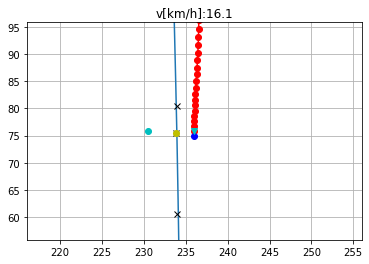

vehicle.get_transform() Transform(Location(x=233.830490, y=26.527102, z=-0.017825), Rotation(pitch=-0.354364, yaw=87.619087, roll=-0.024872))
vehicleToFollow.get_transform() Transform(Location(x=236.020676, y=75.828842, z=0.043124), Rotation(pitch=0.396404, yaw=88.115982, roll=-0.010040))
obsticle_vehicle.get_transform() Transform(Location(x=233.786697, y=75.530518, z=0.058750), Rotation(pitch=0.383802, yaw=87.779785, roll=0.011318))
ego_position:  (230.41420579964836, 76.64679190589126, 0.061211998377980276, 1.5846285706256622)
path.x[1]:  236.01617151740155
path.y[1]:  76.72428460394487
s:  46.179752471580336


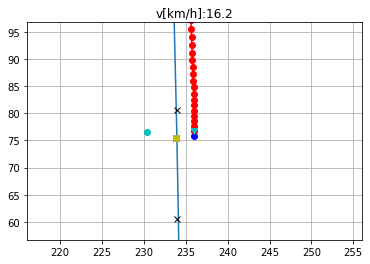

vehicle.get_transform() Transform(Location(x=233.837128, y=26.676840, z=-0.018224), Rotation(pitch=-0.325718, yaw=87.601952, roll=-0.015961))
vehicleToFollow.get_transform() Transform(Location(x=236.016251, y=76.727158, z=0.047976), Rotation(pitch=0.411649, yaw=88.119942, roll=-0.007721))
obsticle_vehicle.get_transform() Transform(Location(x=233.786697, y=75.530518, z=0.058750), Rotation(pitch=0.383802, yaw=87.779785, roll=0.011318))
ego_position:  (230.40164919756617, 77.54836232425272, 0.06716088966354687, 1.5848049646669702)
path.x[1]:  236.01237943025154
path.y[1]:  77.62696615413681
s:  47.082047317643315


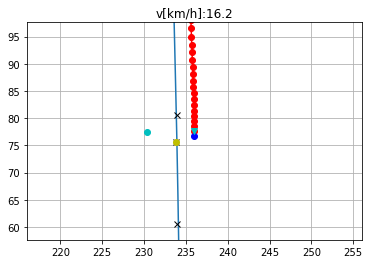

vehicle.get_transform() Transform(Location(x=233.844116, y=26.834215, z=-0.018637), Rotation(pitch=-0.295255, yaw=87.585106, roll=-0.008087))
vehicleToFollow.get_transform() Transform(Location(x=236.012421, y=77.629898, z=0.053001), Rotation(pitch=0.422645, yaw=88.123413, roll=-0.014069))
obsticle_vehicle.get_transform() Transform(Location(x=233.786697, y=75.530518, z=0.058750), Rotation(pitch=0.383802, yaw=87.779785, roll=0.011318))
ego_position:  (230.3889102177886, 78.45435045780032, 0.07324348454381466, 1.5849209401202713)
path.x[1]:  236.00726251619096
path.y[1]:  78.53371278933061
s:  47.98855132882345


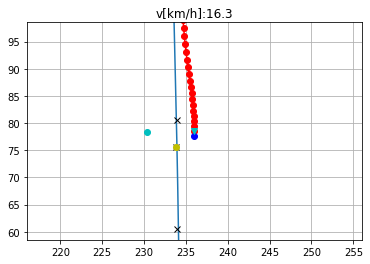

vehicle.get_transform() Transform(Location(x=233.851486, y=26.998898, z=-0.019039), Rotation(pitch=-0.264765, yaw=87.569420, roll=-0.001129))
vehicleToFollow.get_transform() Transform(Location(x=236.007202, y=78.536636, z=0.058209), Rotation(pitch=0.429715, yaw=88.127655, roll=-0.028320))
obsticle_vehicle.get_transform() Transform(Location(x=233.786697, y=75.530518, z=0.058750), Rotation(pitch=0.383802, yaw=87.779785, roll=0.011318))
ego_position:  (230.3758553118089, 79.3633761453564, 0.07939364000964905, 1.585363739930917)
path.x[1]:  235.99644476820365
path.y[1]:  79.44525938625216
s:  48.899241326517725


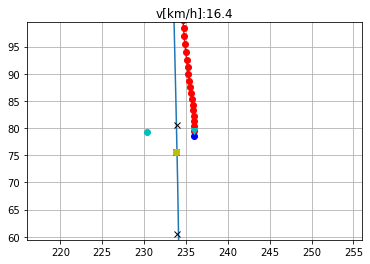

vehicle.get_transform() Transform(Location(x=233.859070, y=27.170637, z=-0.019339), Rotation(pitch=-0.233183, yaw=87.555038, roll=0.005537))
vehicleToFollow.get_transform() Transform(Location(x=235.996414, y=79.448166, z=0.064026), Rotation(pitch=0.456824, yaw=88.128586, roll=-0.024475))
obsticle_vehicle.get_transform() Transform(Location(x=233.786697, y=75.530518, z=0.058750), Rotation(pitch=0.383802, yaw=87.779785, roll=0.011318))
ego_position:  (230.3627268781185, 80.27919134268294, 0.08617119372759424, 1.5850547393925378)
path.x[1]:  235.97628260273308
path.y[1]:  80.35923716091831
s:  49.81409425976071


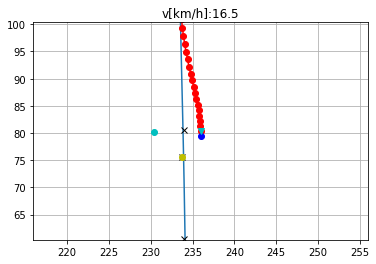

vehicle.get_transform() Transform(Location(x=233.866989, y=27.349176, z=-0.019623), Rotation(pitch=-0.205104, yaw=87.541420, roll=0.009472))
vehicleToFollow.get_transform() Transform(Location(x=235.976212, y=80.362404, z=0.070584), Rotation(pitch=0.513883, yaw=88.128929, roll=-0.036560))
obsticle_vehicle.get_transform() Transform(Location(x=233.786697, y=75.530518, z=0.058750), Rotation(pitch=0.383802, yaw=87.779785, roll=0.011318))
ego_position:  (230.34948594454198, 81.1959832023113, 0.09368753176582567, 1.585647518690854)
path.x[1]:  235.94161818869563
path.y[1]:  81.27903913768084
s:  50.73308720452168


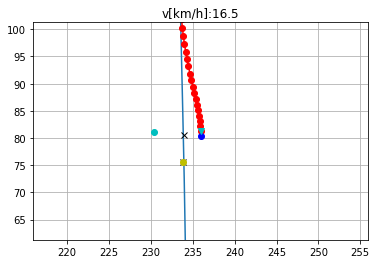

vehicle.get_transform() Transform(Location(x=233.875214, y=27.534298, z=-0.019877), Rotation(pitch=-0.180542, yaw=87.528732, roll=0.011904))
vehicleToFollow.get_transform() Transform(Location(x=235.941483, y=81.282776, z=0.077733), Rotation(pitch=0.612852, yaw=88.130325, roll=-0.052856))
obsticle_vehicle.get_transform() Transform(Location(x=233.786697, y=75.530518, z=0.058750), Rotation(pitch=0.383802, yaw=87.779785, roll=0.011318))
ego_position:  (230.33554351175647, 82.1187976511429, 0.10213035344829201, 1.585690866530594)
path.x[1]:  235.88886448260172
path.y[1]:  82.20151792818913
s:  51.656197363005646


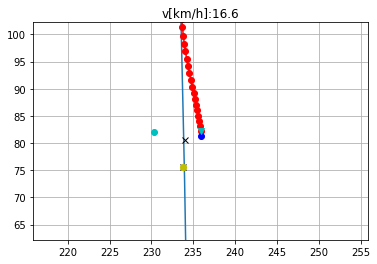

vehicle.get_transform() Transform(Location(x=233.883728, y=27.725815, z=-0.020096), Rotation(pitch=-0.159328, yaw=87.518105, roll=0.013943))
vehicleToFollow.get_transform() Transform(Location(x=235.888763, y=82.205841, z=0.086753), Rotation(pitch=0.757434, yaw=88.133034, roll=-0.049774))
obsticle_vehicle.get_transform() Transform(Location(x=233.786697, y=75.530518, z=0.058750), Rotation(pitch=0.383802, yaw=87.779785, roll=0.011318))
ego_position:  (230.3217339576843, 83.04588660086645, 0.11197394225552697, 1.5856796170768317)
path.x[1]:  235.8178754284034
path.y[1]:  83.12769331029321
s:  52.5834020629582


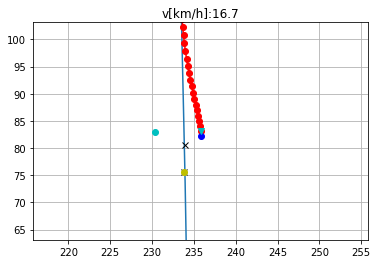

vehicle.get_transform() Transform(Location(x=233.892502, y=27.923571, z=-0.020279), Rotation(pitch=-0.141139, yaw=87.509537, roll=0.015301))
vehicleToFollow.get_transform() Transform(Location(x=235.817673, y=83.132431, z=0.097022), Rotation(pitch=0.851219, yaw=88.132072, roll=-0.062164))
obsticle_vehicle.get_transform() Transform(Location(x=233.786697, y=75.530518, z=0.058750), Rotation(pitch=0.383802, yaw=87.779785, roll=0.011318))
ego_position:  (230.3076583807369, 83.97491801905495, 0.12262027604184715, 1.586273261549426)
path.x[1]:  235.72884861385677
path.y[1]:  84.05882812650862
s:  53.514678756974185


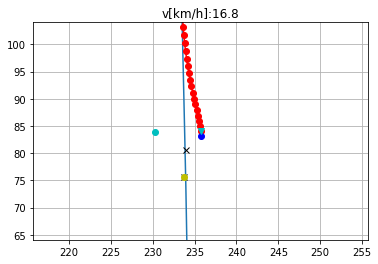

vehicle.get_transform() Transform(Location(x=233.901474, y=28.127424, z=-0.020429), Rotation(pitch=-0.125675, yaw=87.504532, roll=0.017096))
vehicleToFollow.get_transform() Transform(Location(x=235.728729, y=84.063515, z=0.109717), Rotation(pitch=0.866771, yaw=88.131523, roll=-0.050720))
obsticle_vehicle.get_transform() Transform(Location(x=233.786697, y=75.530518, z=0.058750), Rotation(pitch=0.383802, yaw=87.779785, roll=0.011318))
ego_position:  (230.29320364321597, 84.91039275604635, 0.13392334399904898, 1.586179421441908)
path.x[1]:  235.6235351818516
path.y[1]:  84.99239621912943
s:  54.450005021810234


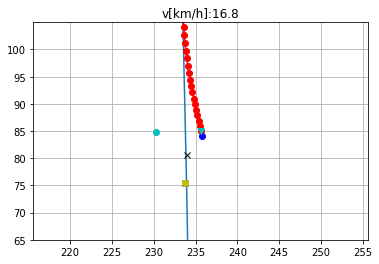

vehicle.get_transform() Transform(Location(x=233.910660, y=28.337248, z=-0.020549), Rotation(pitch=-0.112548, yaw=87.502312, roll=0.018037))
vehicleToFollow.get_transform() Transform(Location(x=235.623428, y=84.996796, z=0.123323), Rotation(pitch=0.855652, yaw=88.131569, roll=-0.049957))
obsticle_vehicle.get_transform() Transform(Location(x=233.786697, y=75.530518, z=0.058750), Rotation(pitch=0.383802, yaw=87.779785, roll=0.011318))
ego_position:  (230.27870992941635, 85.8491348465128, 0.14535758945304417, 1.5863022697845444)
path.x[1]:  235.50466896266124
path.y[1]:  85.93017476437707
s:  55.389358557700994


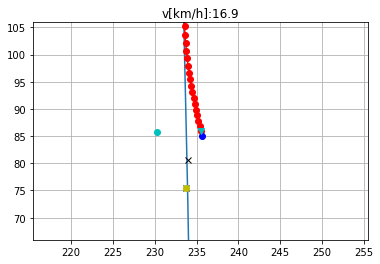

vehicle.get_transform() Transform(Location(x=233.920059, y=28.552927, z=-0.020643), Rotation(pitch=-0.101442, yaw=87.503090, roll=0.018738))
vehicleToFollow.get_transform() Transform(Location(x=235.504562, y=85.934326, z=0.136913), Rotation(pitch=0.845086, yaw=88.131500, roll=-0.049225))
obsticle_vehicle.get_transform() Transform(Location(x=233.786697, y=75.530518, z=0.058750), Rotation(pitch=0.383802, yaw=87.779785, roll=0.011318))
ego_position:  (230.2640439582942, 86.79194707787968, 0.1567021414339051, 1.5864063041979752)
path.x[1]:  235.3750013370933
path.y[1]:  86.87173548789383
s:  56.3327171876792


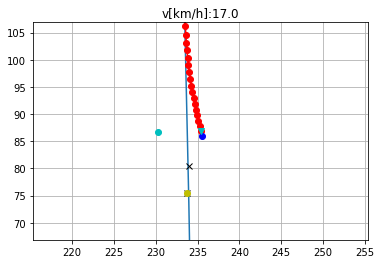

vehicle.get_transform() Transform(Location(x=233.929565, y=28.774366, z=-0.020715), Rotation(pitch=-0.091982, yaw=87.508896, roll=0.020594))
vehicleToFollow.get_transform() Transform(Location(x=235.374924, y=86.875656, z=0.150483), Rotation(pitch=0.835059, yaw=88.131462, roll=-0.048584))
obsticle_vehicle.get_transform() Transform(Location(x=233.786697, y=75.530518, z=0.058750), Rotation(pitch=0.383802, yaw=87.779785, roll=0.011318))
ego_position:  (230.24924356733672, 87.7392391742678, 0.1679629097047026, 1.5863683129597)
path.x[1]:  235.23759511455683
path.y[1]:  87.81692399482776
s:  57.28005885689946


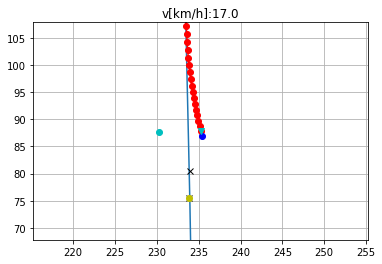

vehicle.get_transform() Transform(Location(x=233.939209, y=29.001484, z=-0.020771), Rotation(pitch=-0.083923, yaw=87.519058, roll=0.022145))
vehicleToFollow.get_transform() Transform(Location(x=235.237518, y=87.820587, z=0.164032), Rotation(pitch=0.825538, yaw=88.131409, roll=-0.047943))
obsticle_vehicle.get_transform() Transform(Location(x=233.786697, y=75.530518, z=0.058750), Rotation(pitch=0.383802, yaw=87.779785, roll=0.011318))
ego_position:  (230.2343326718996, 88.68972771421888, 0.17915358774572168, 1.5865487295625593)
path.x[1]:  235.0954254002767
path.y[1]:  88.76630793903155
s:  58.23136163196577


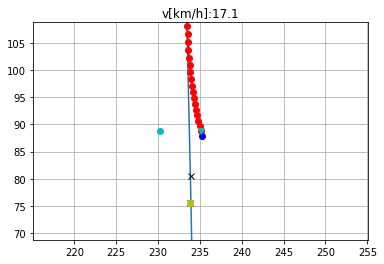

vehicle.get_transform() Transform(Location(x=233.948959, y=29.234188, z=-0.020814), Rotation(pitch=-0.076997, yaw=87.533272, roll=0.023358))
vehicleToFollow.get_transform() Transform(Location(x=235.095352, y=88.769722, z=0.177567), Rotation(pitch=0.816488, yaw=88.131340, roll=-0.047363))
obsticle_vehicle.get_transform() Transform(Location(x=233.786697, y=75.530518, z=0.058750), Rotation(pitch=0.383802, yaw=87.779785, roll=0.011318))
ego_position:  (230.21930742750675, 89.64481682912037, 0.19029196249441233, 1.5865401104656096)
path.x[1]:  234.9513274598963
path.y[1]:  89.71932288479483
s:  59.18660370026272


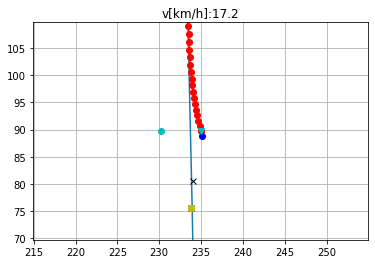

vehicle.get_transform() Transform(Location(x=233.958771, y=29.472408, z=-0.020848), Rotation(pitch=-0.070986, yaw=87.553314, roll=0.025792))
vehicleToFollow.get_transform() Transform(Location(x=234.951248, y=89.722519, z=0.191082), Rotation(pitch=0.807882, yaw=88.131256, roll=-0.046814))
obsticle_vehicle.get_transform() Transform(Location(x=233.786697, y=75.530518, z=0.058750), Rotation(pitch=0.383802, yaw=87.779785, roll=0.011318))
ego_position:  (230.20419812297422, 90.60362586930674, 0.2013960118572192, 1.5865879132030796)
path.x[1]:  234.8078550740305
path.y[1]:  90.67633095953471
s:  60.145763369290414


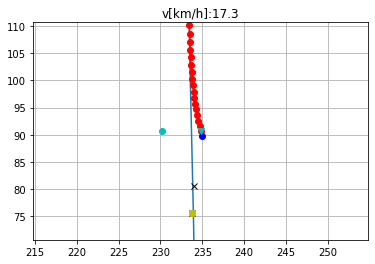

vehicle.get_transform() Transform(Location(x=233.968613, y=29.716085, z=-0.020876), Rotation(pitch=-0.065700, yaw=87.578712, roll=0.028055))
vehicleToFollow.get_transform() Transform(Location(x=234.807770, y=90.679298, z=0.204583), Rotation(pitch=0.799692, yaw=88.131203, roll=-0.046295))
obsticle_vehicle.get_transform() Transform(Location(x=233.786697, y=75.530518, z=0.058750), Rotation(pitch=0.383802, yaw=87.779785, roll=0.011318))
ego_position:  (230.18899954626073, 91.56659122786931, 0.21248152739799256, 1.5865612279661707)
path.x[1]:  234.66723103932526
path.y[1]:  91.63719595405698
s:  61.108819066002965


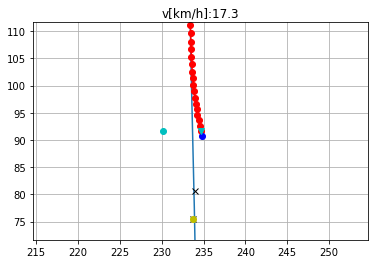

vehicle.get_transform() Transform(Location(x=233.978470, y=29.965149, z=-0.020899), Rotation(pitch=-0.061007, yaw=87.607933, roll=0.029340))
vehicleToFollow.get_transform() Transform(Location(x=234.667145, y=91.639961, z=0.218068), Rotation(pitch=0.791899, yaw=88.131111, roll=-0.045837))
obsticle_vehicle.get_transform() Transform(Location(x=233.786697, y=75.530518, z=0.058750), Rotation(pitch=0.383802, yaw=87.779785, roll=0.011318))
ego_position:  (230.17376581186497, 92.5334277441225, 0.22356241386858328, 1.586535586012215)
path.x[1]:  234.53136763456615
path.y[1]:  92.6020188327621
s:  62.07574933615079


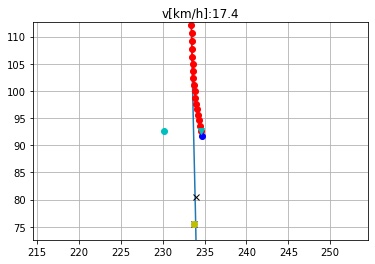

vehicle.get_transform() Transform(Location(x=233.988373, y=30.219543, z=-0.020919), Rotation(pitch=-0.056854, yaw=87.641129, roll=0.030673))
vehicleToFollow.get_transform() Transform(Location(x=234.531326, y=92.604561, z=0.231540), Rotation(pitch=0.784474, yaw=88.131134, roll=-0.045380))
obsticle_vehicle.get_transform() Transform(Location(x=233.786697, y=75.530518, z=0.058750), Rotation(pitch=0.383802, yaw=87.779785, roll=0.011318))
ego_position:  (230.15848816831365, 93.50390534027585, 0.2346527044889235, 1.5865705334223756)
path.x[1]:  234.40175263186478
path.y[1]:  93.57084502289317
s:  63.046532843626366


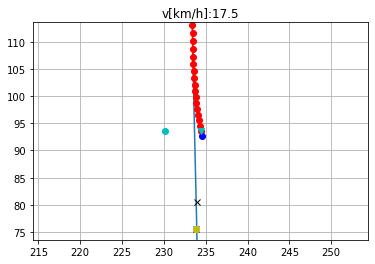

vehicle.get_transform() Transform(Location(x=233.998230, y=30.479221, z=-0.020936), Rotation(pitch=-0.053098, yaw=87.679214, roll=0.032744))
vehicleToFollow.get_transform() Transform(Location(x=234.401642, y=93.573219, z=0.244999), Rotation(pitch=0.777426, yaw=88.245674, roll=-0.043365))
obsticle_vehicle.get_transform() Transform(Location(x=233.786697, y=75.530518, z=0.058750), Rotation(pitch=0.383802, yaw=87.779785, roll=0.011318))
ego_position:  (230.14311565670576, 94.47831119210305, 0.24573352885232919, 1.5865777994794261)
path.x[1]:  234.2794864731094
path.y[1]:  94.5435946349652
s:  64.02114836981369


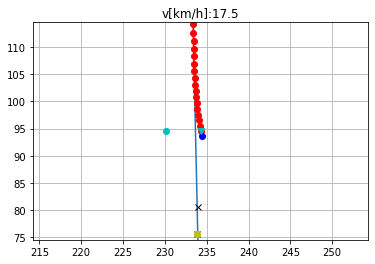

vehicle.get_transform() Transform(Location(x=234.008087, y=30.744123, z=-0.020953), Rotation(pitch=-0.049683, yaw=87.721298, roll=0.034429))
vehicleToFollow.get_transform() Transform(Location(x=234.279251, y=94.545616, z=0.259588), Rotation(pitch=0.804910, yaw=88.573082, roll=-0.043915))
obsticle_vehicle.get_transform() Transform(Location(x=233.786697, y=75.530518, z=0.058750), Rotation(pitch=0.383802, yaw=87.779785, roll=0.011318))
ego_position:  (230.1276332347273, 95.45646514616355, 0.2576002350613349, 1.5866000696697897)
path.x[1]:  234.1653619349432
path.y[1]:  95.52028168533202
s:  64.99957481294128


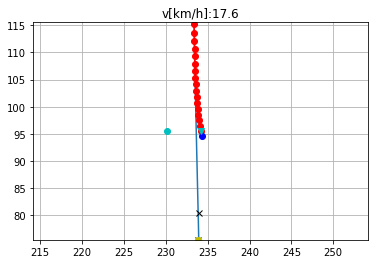

vehicle.get_transform() Transform(Location(x=234.017868, y=31.014212, z=-0.020969), Rotation(pitch=-0.046514, yaw=87.766663, roll=0.035803))
vehicleToFollow.get_transform() Transform(Location(x=234.164993, y=95.522575, z=0.275107), Rotation(pitch=0.870289, yaw=89.139893, roll=-0.035736))
obsticle_vehicle.get_transform() Transform(Location(x=233.786697, y=75.530518, z=0.058750), Rotation(pitch=0.383802, yaw=87.779785, roll=0.011318))
ego_position:  (230.11219336463614, 96.43902393176708, 0.27040683097897344, 1.586443720787633)
path.x[1]:  234.06004866966956
path.y[1]:  96.50080262121766
s:  65.98179118743872


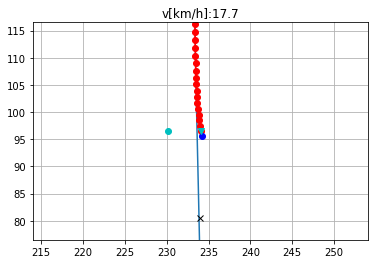

vehicle.get_transform() Transform(Location(x=234.027588, y=31.289434, z=-0.020985), Rotation(pitch=-0.043611, yaw=87.814949, roll=0.036977))
vehicleToFollow.get_transform() Transform(Location(x=234.059784, y=96.503387, z=0.290623), Rotation(pitch=0.935326, yaw=89.661087, roll=-0.028870))
obsticle_vehicle.get_transform() Transform(Location(x=233.786697, y=75.530518, z=0.058750), Rotation(pitch=0.383802, yaw=87.779785, roll=0.011318))
ego_position:  (230.09684991632452, 97.4256625689849, 0.28420901103047647, 1.5861953700031601)
path.x[1]:  233.96382840425753
path.y[1]:  97.4852150451172
s:  66.96777662329683


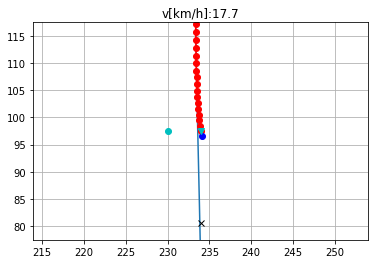

vehicle.get_transform() Transform(Location(x=234.037216, y=31.569757, z=-0.021000), Rotation(pitch=-0.040892, yaw=87.866325, roll=0.038367))
vehicleToFollow.get_transform() Transform(Location(x=233.963684, y=97.487045, z=0.307356), Rotation(pitch=0.967687, yaw=89.960884, roll=-0.028687))
obsticle_vehicle.get_transform() Transform(Location(x=233.786697, y=75.530518, z=0.058750), Rotation(pitch=0.383802, yaw=87.779785, roll=0.011318))
ego_position:  (230.08176195726168, 98.41615118551692, 0.29963459481974725, 1.5859125051651932)
path.x[1]:  233.87685672393982
path.y[1]:  98.47352288479784
s:  67.95751036543128


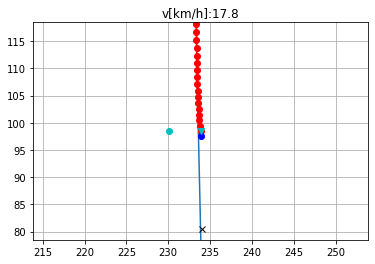

vehicle.get_transform() Transform(Location(x=234.046753, y=31.855133, z=-0.021016), Rotation(pitch=-0.038331, yaw=87.920433, roll=0.039748))
vehicleToFollow.get_transform() Transform(Location(x=233.876740, y=98.475044, z=0.325338), Rotation(pitch=0.956759, yaw=90.133392, roll=-0.025909))
obsticle_vehicle.get_transform() Transform(Location(x=233.786697, y=75.530518, z=0.058750), Rotation(pitch=0.383802, yaw=87.779785, roll=0.011318))
ego_position:  (230.06695581382164, 99.41081471253821, 0.3158070955691619, 1.5854999434310364)
path.x[1]:  233.79896989185076
path.y[1]:  99.46569277169112
s:  68.9509717730497


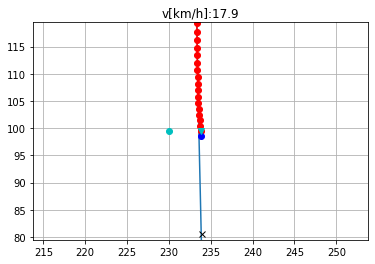

vehicle.get_transform() Transform(Location(x=234.056198, y=32.145527, z=-0.021031), Rotation(pitch=-0.035920, yaw=87.976494, roll=0.040710))
vehicleToFollow.get_transform() Transform(Location(x=233.798874, y=99.466934, z=0.343328), Rotation(pitch=0.946295, yaw=90.234398, roll=-0.024475))
obsticle_vehicle.get_transform() Transform(Location(x=233.786697, y=75.530518, z=0.058750), Rotation(pitch=0.383802, yaw=87.779785, roll=0.011318))
ego_position:  (230.05248214447974, 100.4092912034515, 0.33225228445359345, 1.5850575249428787)
path.x[1]:  233.72985929211148
path.y[1]:  100.46173856327928
s:  69.9481403190224


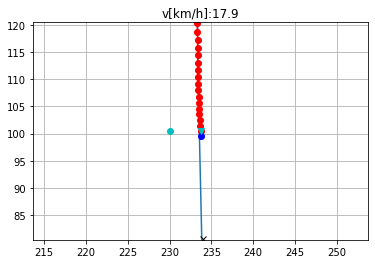

vehicle.get_transform() Transform(Location(x=234.065506, y=32.440891, z=-0.021047), Rotation(pitch=-0.033632, yaw=88.034332, roll=0.041659))
vehicleToFollow.get_transform() Transform(Location(x=233.729782, y=100.462677, z=0.361327), Rotation(pitch=0.936337, yaw=90.295105, roll=-0.023834))
obsticle_vehicle.get_transform() Transform(Location(x=233.786697, y=75.530518, z=0.058750), Rotation(pitch=0.383802, yaw=87.779785, roll=0.011318))
ego_position:  (230.03837030240942, 101.41137589698971, 0.3487545801793779, 1.5846713821362537)
path.x[1]:  233.669082185116
path.y[1]:  101.46175545830897
s:  70.94910891627171


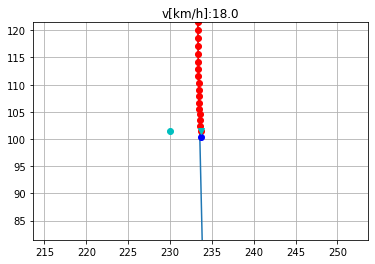

vehicle.get_transform() Transform(Location(x=234.074646, y=32.741207, z=-0.021062), Rotation(pitch=-0.031494, yaw=88.094070, roll=0.042829))
vehicleToFollow.get_transform() Transform(Location(x=233.705154, y=101.471268, z=0.606886), Rotation(pitch=3.532485, yaw=90.722260, roll=13.914690))
obsticle_vehicle.get_transform() Transform(Location(x=233.786697, y=75.530518, z=0.058750), Rotation(pitch=0.383802, yaw=87.779785, roll=0.011318))
ego_position:  (230.0246772701844, 102.41770144063777, 0.3654507335018041, 1.5842546084107292)
path.x[1]:  233.61617640774014
path.y[1]:  102.46603976592118
s:  71.95420761493911


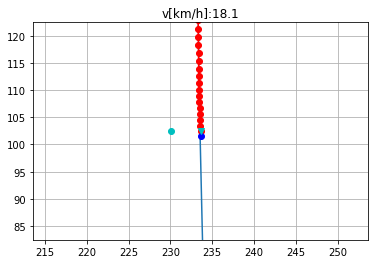

vehicle.get_transform() Transform(Location(x=234.083603, y=33.046425, z=-0.021077), Rotation(pitch=-0.029383, yaw=88.156586, roll=0.044755))
vehicleToFollow.get_transform() Transform(Location(x=233.746964, y=102.482162, z=0.659485), Rotation(pitch=3.974002, yaw=90.850937, roll=17.828926))
obsticle_vehicle.get_transform() Transform(Location(x=233.786697, y=75.530518, z=0.058750), Rotation(pitch=0.383802, yaw=87.779785, roll=0.011318))
ego_position:  (230.01136824323308, 103.42885066019124, 0.3829874795695523, 1.5837445037205766)
path.x[1]:  233.57054855988972
path.y[1]:  103.47493813227327
s:  72.96381139064633


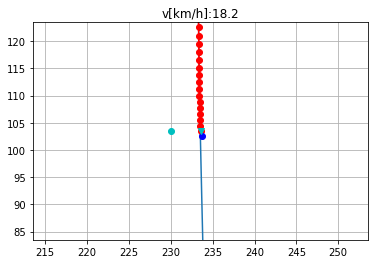

vehicle.get_transform() Transform(Location(x=234.092377, y=33.356514, z=-0.021093), Rotation(pitch=-0.027348, yaw=88.221024, roll=0.046275))
vehicleToFollow.get_transform() Transform(Location(x=233.740875, y=103.498360, z=0.688040), Rotation(pitch=4.325367, yaw=90.589752, roll=18.494110))
obsticle_vehicle.get_transform() Transform(Location(x=233.786697, y=75.530518, z=0.058750), Rotation(pitch=0.383802, yaw=87.779785, roll=0.011318))
ego_position:  (229.99845545550124, 104.44439047037848, 0.400966116981295, 1.5833405692545466)
path.x[1]:  233.53160162897578
path.y[1]:  104.48871343750642
s:  73.978178872313


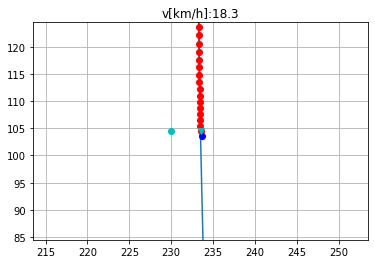

vehicle.get_transform() Transform(Location(x=234.100937, y=33.671440, z=-0.021108), Rotation(pitch=-0.025422, yaw=88.286156, roll=0.047052))
vehicleToFollow.get_transform() Transform(Location(x=233.568039, y=104.461128, z=0.676741), Rotation(pitch=3.146163, yaw=93.159203, roll=14.595973))
obsticle_vehicle.get_transform() Transform(Location(x=233.786697, y=75.530518, z=0.058750), Rotation(pitch=0.383802, yaw=87.779785, roll=0.011318))
ego_position:  (229.98592235514948, 105.46392788206232, 0.4201085214894455, 1.5829239944021924)
path.x[1]:  233.4986617504876
path.y[1]:  105.50653130656899
s:  74.99651528297743


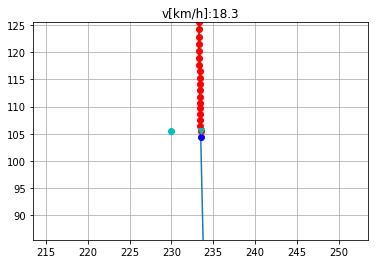

vehicle.get_transform() Transform(Location(x=234.109299, y=33.991173, z=-0.021123), Rotation(pitch=-0.023591, yaw=88.351822, roll=0.047625))
vehicleToFollow.get_transform() Transform(Location(x=233.557922, y=105.505951, z=0.778442), Rotation(pitch=6.472430, yaw=90.512634, roll=22.833628))
obsticle_vehicle.get_transform() Transform(Location(x=233.786697, y=75.530518, z=0.058750), Rotation(pitch=0.383802, yaw=87.779785, roll=0.011318))
ego_position:  (229.97378344258007, 106.48621648904897, 0.4398852751066425, 1.5824404203640832)
path.x[1]:  233.47103716303556
path.y[1]:  106.52694067915039
s:  76.01737504353551


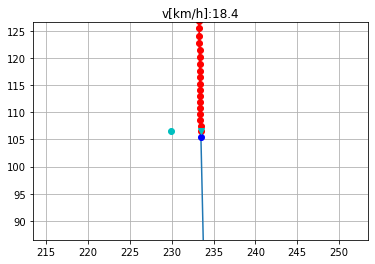

vehicle.get_transform() Transform(Location(x=234.117432, y=34.315678, z=-0.021137), Rotation(pitch=-0.021788, yaw=88.419174, roll=0.049049))
vehicleToFollow.get_transform() Transform(Location(x=233.620621, y=106.543495, z=0.801987), Rotation(pitch=6.749784, yaw=90.173660, roll=22.457600))
obsticle_vehicle.get_transform() Transform(Location(x=233.786697, y=75.530518, z=0.058750), Rotation(pitch=0.383802, yaw=87.779785, roll=0.011318))
ego_position:  (229.9620260718495, 107.51053708047266, 0.45980115006875305, 1.5821393122982785)
path.x[1]:  233.44686092910055
path.y[1]:  107.5500672071138
s:  77.04090301527397


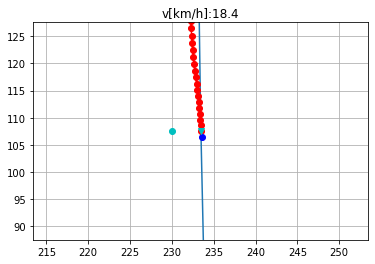

vehicle.get_transform() Transform(Location(x=234.125290, y=34.644928, z=-0.021151), Rotation(pitch=-0.020053, yaw=88.487831, roll=0.050418))
vehicleToFollow.get_transform() Transform(Location(x=233.557373, y=107.539482, z=0.832328), Rotation(pitch=6.212145, yaw=92.117065, roll=23.091902))
obsticle_vehicle.get_transform() Transform(Location(x=233.786697, y=75.530518, z=0.058750), Rotation(pitch=0.383802, yaw=87.779785, roll=0.011318))
ego_position:  (229.9506565712454, 108.53831538425935, 0.47969304771678484, 1.5816943655776656)
path.x[1]:  233.42011144377167
path.y[1]:  108.57612713495959
s:  78.06737965674297


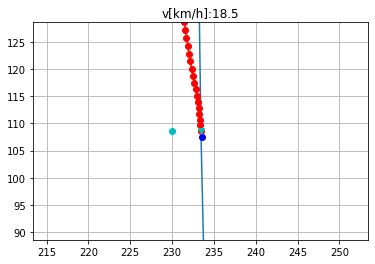

vehicle.get_transform() Transform(Location(x=234.132904, y=34.978291, z=-0.021195), Rotation(pitch=-0.014862, yaw=88.555984, roll=0.050706))
vehicleToFollow.get_transform() Transform(Location(x=233.455261, y=108.579079, z=0.842295), Rotation(pitch=6.834437, yaw=91.611366, roll=22.143589))
obsticle_vehicle.get_transform() Transform(Location(x=233.786697, y=75.530518, z=0.058750), Rotation(pitch=0.383802, yaw=87.779785, roll=0.011318))
ego_position:  (229.93959465586914, 109.56947425595585, 0.49956726698628606, 1.581292081841793)
path.x[1]:  233.38439546063455
path.y[1]:  109.60563136909751
s:  79.09738163162928


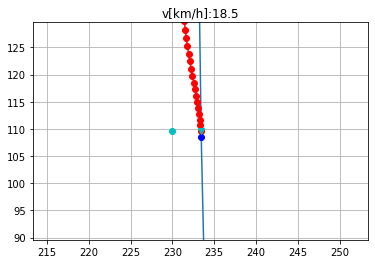

vehicle.get_transform() Transform(Location(x=234.140152, y=35.312244, z=-0.021413), Rotation(pitch=0.009111, yaw=88.623665, roll=0.052796))
vehicleToFollow.get_transform() Transform(Location(x=233.438034, y=109.604195, z=0.872412), Rotation(pitch=7.011872, yaw=91.959602, roll=22.257824))
obsticle_vehicle.get_transform() Transform(Location(x=233.786697, y=75.530518, z=0.058750), Rotation(pitch=0.383802, yaw=87.779785, roll=0.011318))
ego_position:  (229.92892325278387, 110.60395700492339, 0.5199021093686674, 1.5809406604740595)
path.x[1]:  233.33583921195603
path.y[1]:  110.63851908280397
s:  80.13088952698482


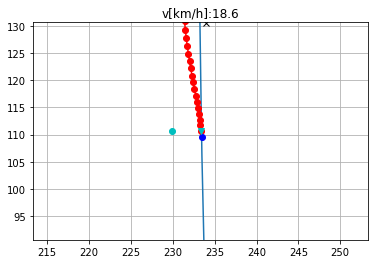

vehicle.get_transform() Transform(Location(x=234.147018, y=35.646057, z=-0.021753), Rotation(pitch=0.044799, yaw=88.689919, roll=0.056289))
vehicleToFollow.get_transform() Transform(Location(x=233.411026, y=110.638519, z=0.991044), Rotation(pitch=3.961318, yaw=89.454323, roll=29.250465))
obsticle_vehicle.get_transform() Transform(Location(x=233.786697, y=75.530518, z=0.058750), Rotation(pitch=0.383802, yaw=87.779785, roll=0.011318))
ego_position:  (229.91850597434777, 111.64169667124477, 0.54047817634701, 1.580654488348353)
path.x[1]:  233.27256212040024
path.y[1]:  111.67476256975046
s:  81.1678840367628


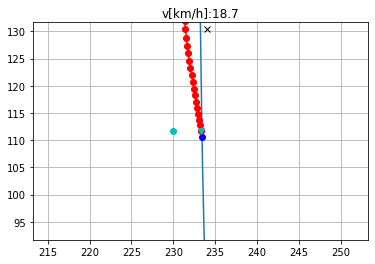

vehicle.get_transform() Transform(Location(x=234.153503, y=35.979698, z=-0.022143), Rotation(pitch=0.084141, yaw=88.755798, roll=0.061309))
vehicleToFollow.get_transform() Transform(Location(x=233.444794, y=111.669304, z=1.024453), Rotation(pitch=3.788781, yaw=90.462646, roll=29.255024))
obsticle_vehicle.get_transform() Transform(Location(x=233.786697, y=75.530518, z=0.058750), Rotation(pitch=0.383802, yaw=87.779785, roll=0.011318))
ego_position:  (229.90841858288297, 112.68332843597611, 0.561630736064385, 1.5802448457627494)
path.x[1]:  233.19454814797373
path.y[1]:  112.71437841749882
s:  82.20834596122901


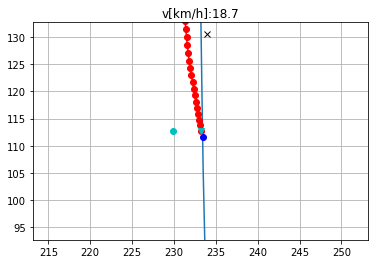

vehicle.get_transform() Transform(Location(x=234.159592, y=36.313141, z=-0.022530), Rotation(pitch=0.122035, yaw=88.820229, roll=0.065150))
vehicleToFollow.get_transform() Transform(Location(x=233.383667, y=112.717758, z=1.058960), Rotation(pitch=3.838170, yaw=90.674500, roll=29.706892))
obsticle_vehicle.get_transform() Transform(Location(x=233.786697, y=75.530518, z=0.058750), Rotation(pitch=0.383802, yaw=87.779785, roll=0.011318))
ego_position:  (229.8987117090586, 113.72809498855165, 0.5832724961183534, 1.579923199262905)
path.x[1]:  233.10291687908165
path.y[1]:  113.75734017254362
s:  83.25225620637636


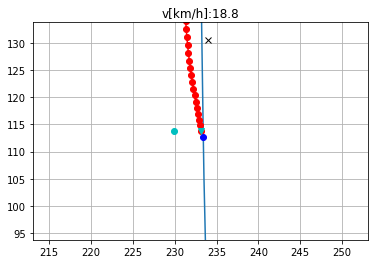

vehicle.get_transform() Transform(Location(x=234.165344, y=36.646381, z=-0.022877), Rotation(pitch=0.155646, yaw=88.882706, roll=0.067419))
vehicleToFollow.get_transform() Transform(Location(x=233.299271, y=113.749519, z=1.095146), Rotation(pitch=3.673685, yaw=90.297066, roll=30.078474))
obsticle_vehicle.get_transform() Transform(Location(x=233.786697, y=75.530518, z=0.058750), Rotation(pitch=0.383802, yaw=87.779785, roll=0.011318))
ego_position:  (229.88919090614036, 114.77569559130106, 0.6050472824444706, 1.5797715792714537)
path.x[1]:  232.99933462677825
path.y[1]:  114.80361066600393
s:  84.2995957833427


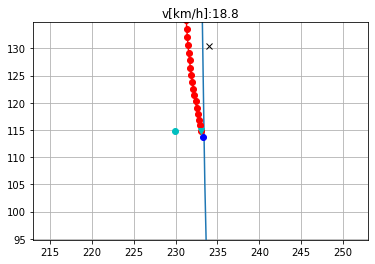

vehicle.get_transform() Transform(Location(x=234.170761, y=36.979408, z=-0.023167), Rotation(pitch=0.183698, yaw=88.944122, roll=0.068679))
vehicleToFollow.get_transform() Transform(Location(x=233.206070, y=114.794518, z=1.130124), Rotation(pitch=3.580501, yaw=90.241501, roll=30.333149))
obsticle_vehicle.get_transform() Transform(Location(x=233.786697, y=75.530518, z=0.058750), Rotation(pitch=0.383802, yaw=87.779785, roll=0.011318))
ego_position:  (229.87971895095382, 115.82600427964516, 0.6268004259528597, 1.579821130647042)
path.x[1]:  232.88600152204629
path.y[1]:  115.85313612678067
s:  85.35034580783184


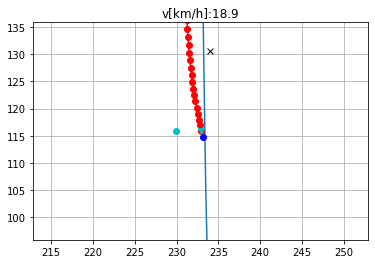

vehicle.get_transform() Transform(Location(x=234.175797, y=37.312225, z=-0.023391), Rotation(pitch=0.205951, yaw=89.005165, roll=0.069039))
vehicleToFollow.get_transform() Transform(Location(x=233.103271, y=115.842712, z=1.164400), Rotation(pitch=3.476013, yaw=90.189812, roll=30.597805))
obsticle_vehicle.get_transform() Transform(Location(x=233.786697, y=75.530518, z=0.058750), Rotation(pitch=0.383802, yaw=87.779785, roll=0.011318))
ego_position:  (229.87021210433068, 116.88001397297805, 0.6485290649799156, 1.5797564179985673)
path.x[1]:  232.7661145913881
path.y[1]:  116.90596221778574
s:  86.40439586646174


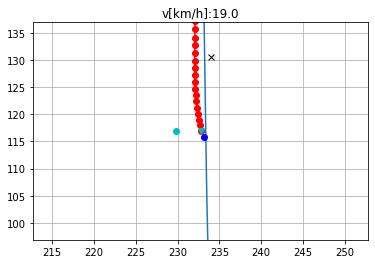

vehicle.get_transform() Transform(Location(x=234.180466, y=37.644829, z=-0.023551), Rotation(pitch=0.222794, yaw=89.066254, roll=0.068637))
vehicleToFollow.get_transform() Transform(Location(x=232.993622, y=116.893875, z=1.198673), Rotation(pitch=3.324178, yaw=90.120827, roll=30.802061))
obsticle_vehicle.get_transform() Transform(Location(x=233.786697, y=75.530518, z=0.058750), Rotation(pitch=0.383802, yaw=87.779785, roll=0.011318))
ego_position:  (229.86073946992147, 117.9366563275319, 0.6702327938534842, 1.5798523309600865)
path.x[1]:  232.64548001924064
path.y[1]:  117.96187563897138
s:  87.4616391747943


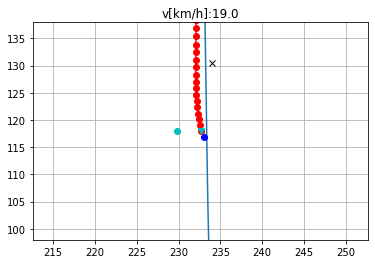

vehicle.get_transform() Transform(Location(x=234.184784, y=37.977230, z=-0.023655), Rotation(pitch=0.234931, yaw=89.127701, roll=0.067584))
vehicleToFollow.get_transform() Transform(Location(x=232.883820, y=117.948494, z=1.231583), Rotation(pitch=3.216411, yaw=90.065079, roll=31.094469))
obsticle_vehicle.get_transform() Transform(Location(x=233.786697, y=75.530518, z=0.058750), Rotation(pitch=0.383802, yaw=87.779785, roll=0.011318))
ego_position:  (229.85113157468496, 118.99704847117368, 0.6917609664429459, 1.5796757722878958)
path.x[1]:  232.52911111767315
path.y[1]:  119.02082806952423
s:  88.52167552060355


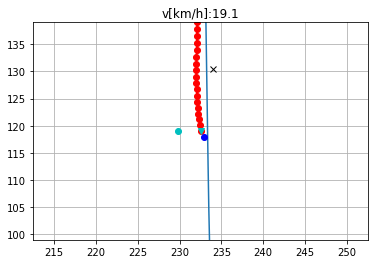

vehicle.get_transform() Transform(Location(x=234.188705, y=38.309418, z=-0.023710), Rotation(pitch=0.243209, yaw=89.189842, roll=0.066217))
vehicleToFollow.get_transform() Transform(Location(x=232.778732, y=119.006401, z=1.263380), Rotation(pitch=3.140903, yaw=90.019234, roll=31.440893))
obsticle_vehicle.get_transform() Transform(Location(x=233.786697, y=75.530518, z=0.058750), Rotation(pitch=0.383802, yaw=87.779785, roll=0.011318))
ego_position:  (229.84202758829704, 120.06030838462486, 0.7134681974482777, 1.5791699604096585)
path.x[1]:  232.4212326755897
path.y[1]:  120.08190620784238
s:  89.58342600258155


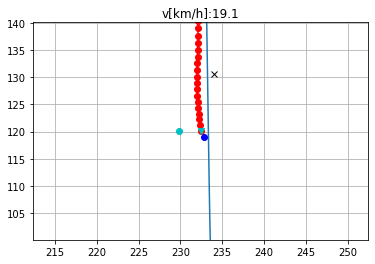

vehicle.get_transform() Transform(Location(x=234.192261, y=38.641411, z=-0.023730), Rotation(pitch=0.248489, yaw=89.252747, roll=0.064592))
vehicleToFollow.get_transform() Transform(Location(x=232.681778, y=120.066315, z=1.294981), Rotation(pitch=3.038874, yaw=89.975456, roll=31.730492))
obsticle_vehicle.get_transform() Transform(Location(x=233.786697, y=75.530518, z=0.058750), Rotation(pitch=0.383802, yaw=87.779785, roll=0.011318))
ego_position:  (229.83317732702022, 121.12455518734694, 0.7353939399480779, 1.5790431299428604)
path.x[1]:  232.3241172485526
path.y[1]:  121.14509794423802
s:  90.64749162167328


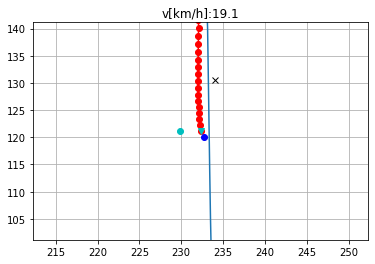

vehicle.get_transform() Transform(Location(x=234.195419, y=38.973198, z=-0.023722), Rotation(pitch=0.251529, yaw=89.316116, roll=0.062697))
vehicleToFollow.get_transform() Transform(Location(x=232.594940, y=121.127907, z=1.326893), Rotation(pitch=2.883193, yaw=89.913254, roll=31.917137))
obsticle_vehicle.get_transform() Transform(Location(x=233.786697, y=75.530518, z=0.058750), Rotation(pitch=0.383802, yaw=87.779785, roll=0.011318))
ego_position:  (229.82434741499026, 122.19138722464898, 0.7574225500724359, 1.5791254287880225)
path.x[1]:  232.23907404984408
path.y[1]:  122.21150019418366
s:  91.71487558301763


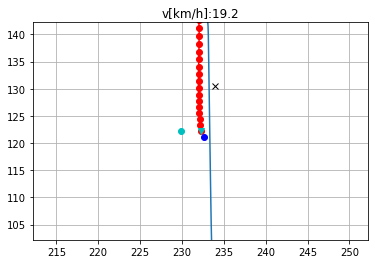

vehicle.get_transform() Transform(Location(x=234.198242, y=39.304790, z=-0.023698), Rotation(pitch=0.252983, yaw=89.379539, roll=0.060547))
vehicleToFollow.get_transform() Transform(Location(x=232.520554, y=122.193008, z=1.357821), Rotation(pitch=2.762484, yaw=89.863174, roll=32.157719))
obsticle_vehicle.get_transform() Transform(Location(x=233.786697, y=75.530518, z=0.058750), Rotation(pitch=0.383802, yaw=87.779785, roll=0.011318))
ego_position:  (229.81537272949583, 123.26107349417708, 0.7794853535589243, 1.5793347919373284)
path.x[1]:  232.1666214355928
path.y[1]:  123.2811500371937
s:  92.78555961350447


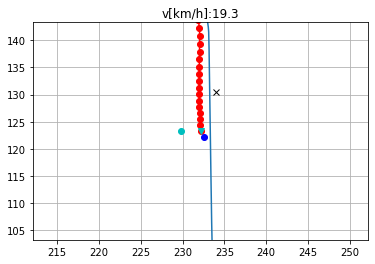

vehicle.get_transform() Transform(Location(x=234.200653, y=39.636189, z=-0.023663), Rotation(pitch=0.253380, yaw=89.442993, roll=0.058529))
vehicleToFollow.get_transform() Transform(Location(x=232.459000, y=123.261566, z=1.387922), Rotation(pitch=2.669019, yaw=89.822670, roll=32.431797))
obsticle_vehicle.get_transform() Transform(Location(x=233.786697, y=75.530518, z=0.058750), Rotation(pitch=0.383802, yaw=87.779785, roll=0.011318))
ego_position:  (229.80610848295814, 124.3343115049129, 0.801571220714463, 1.5794664519427386)
path.x[1]:  232.1066329345857
path.y[1]:  124.35425783961247
s:  93.85952554064818


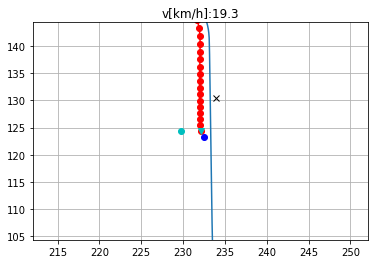

vehicle.get_transform() Transform(Location(x=234.202728, y=39.967827, z=-0.023602), Rotation(pitch=0.250524, yaw=89.506378, roll=0.056665))
vehicleToFollow.get_transform() Transform(Location(x=232.308182, y=124.345619, z=1.233835), Rotation(pitch=0.431122, yaw=87.214119, roll=21.788887))
obsticle_vehicle.get_transform() Transform(Location(x=233.786697, y=75.530518, z=0.058750), Rotation(pitch=0.383802, yaw=87.779785, roll=0.011318))
ego_position:  (229.79661826861422, 125.41010257394781, 0.8236889383954189, 1.5798006618725464)
path.x[1]:  232.05867748559234
path.y[1]:  125.4304714635959
s:  94.93675529203351


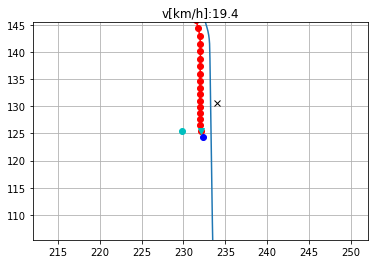

vehicle.get_transform() Transform(Location(x=234.204483, y=40.305511, z=-0.023269), Rotation(pitch=0.217282, yaw=89.570938, roll=0.053564))
vehicleToFollow.get_transform() Transform(Location(x=232.254272, y=125.425858, z=1.257293), Rotation(pitch=0.263331, yaw=87.907791, roll=21.882092))
obsticle_vehicle.get_transform() Transform(Location(x=233.786697, y=75.530518, z=0.058750), Rotation(pitch=0.383802, yaw=87.779785, roll=0.011318))
ego_position:  (229.78678987106383, 126.48918050699974, 0.8458488898436789, 1.580122273146107)
path.x[1]:  232.02179536075892
path.y[1]:  126.51002465258935
s:  96.01723089476461


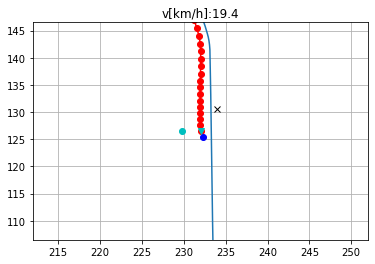

vehicle.get_transform() Transform(Location(x=234.205933, y=40.650761, z=-0.022728), Rotation(pitch=0.163467, yaw=89.636520, roll=0.047006))
vehicleToFollow.get_transform() Transform(Location(x=232.217453, y=126.509460, z=1.280725), Rotation(pitch=0.176533, yaw=88.317436, roll=22.029444))
obsticle_vehicle.get_transform() Transform(Location(x=233.786697, y=75.530518, z=0.058750), Rotation(pitch=0.383802, yaw=87.779785, roll=0.011318))
ego_position:  (229.7766503412564, 127.57216751797053, 0.8680583994418455, 1.580248414477847)
path.x[1]:  231.9956904045248
path.y[1]:  127.593142703879
s:  97.1009344749169


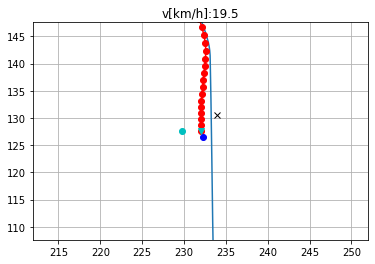

vehicle.get_transform() Transform(Location(x=234.207062, y=41.003277, z=-0.022112), Rotation(pitch=0.104037, yaw=89.702576, roll=0.038836))
vehicleToFollow.get_transform() Transform(Location(x=232.197800, y=127.563042, z=1.304836), Rotation(pitch=-0.770384, yaw=89.783180, roll=26.802433))
obsticle_vehicle.get_transform() Transform(Location(x=233.786697, y=75.530518, z=0.058750), Rotation(pitch=0.383802, yaw=87.779785, roll=0.011318))
ego_position:  (229.7662177625801, 128.6577919511104, 0.8903237350628153, 1.5805373122943824)
path.x[1]:  231.9824765968448
path.y[1]:  128.67938117912664
s:  98.18784825699214


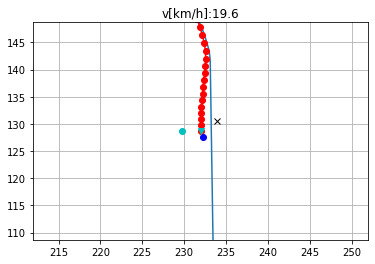

vehicle.get_transform() Transform(Location(x=234.207886, y=41.362778, z=-0.021516), Rotation(pitch=0.047982, yaw=89.768745, roll=0.031243))
vehicleToFollow.get_transform() Transform(Location(x=232.189102, y=128.645172, z=1.345699), Rotation(pitch=-1.190488, yaw=89.701317, roll=27.282784))
obsticle_vehicle.get_transform() Transform(Location(x=233.786697, y=75.530518, z=0.058750), Rotation(pitch=0.383802, yaw=87.779785, roll=0.011318))
ego_position:  (229.7554419336877, 129.74666339410072, 0.9126468985699441, 1.580809584292135)
path.x[1]:  231.983460250367
path.y[1]:  129.76897386087458
s:  99.27795456337638


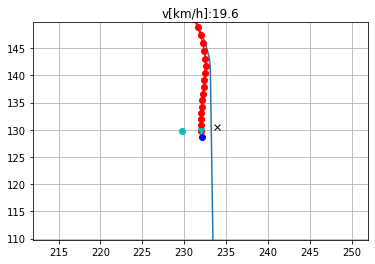

vehicle.get_transform() Transform(Location(x=234.208389, y=41.729027, z=-0.020998), Rotation(pitch=0.000109, yaw=89.834488, roll=0.025527))
vehicleToFollow.get_transform() Transform(Location(x=232.203995, y=129.733261, z=1.401183), Rotation(pitch=-1.232200, yaw=89.729225, roll=29.103325))
obsticle_vehicle.get_transform() Transform(Location(x=233.786697, y=75.530518, z=0.058750), Rotation(pitch=0.383802, yaw=87.779785, roll=0.011318))
ego_position:  (229.7443295120335, 130.83883857259656, 0.9350313126416441, 1.5810439731384616)
path.x[1]:  231.9986861465338
path.y[1]:  130.86194123082768
s:  100.37123581380096


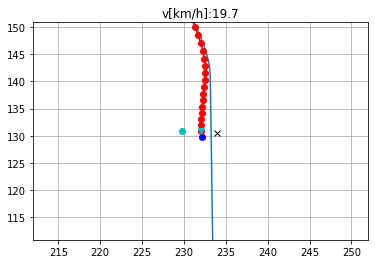

vehicle.get_transform() Transform(Location(x=234.208588, y=42.101791, z=-0.020590), Rotation(pitch=-0.037628, yaw=89.899261, roll=0.022227))
vehicleToFollow.get_transform() Transform(Location(x=232.230362, y=130.823761, z=1.462672), Rotation(pitch=-1.496153, yaw=89.675423, roll=30.975237))
obsticle_vehicle.get_transform() Transform(Location(x=233.786697, y=75.530518, z=0.058750), Rotation(pitch=0.383802, yaw=87.779785, roll=0.011318))
ego_position:  (229.7328939828712, 131.93372026657414, 0.9574579738041638, 1.5814062332274654)
path.x[1]:  232.0272548407086
path.y[1]:  131.95806413406916
s:  101.46767452480648


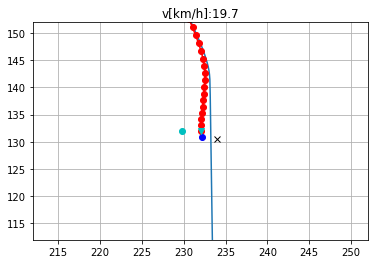

vehicle.get_transform() Transform(Location(x=234.208466, y=42.480854, z=-0.020300), Rotation(pitch=-0.065064, yaw=89.962273, roll=0.020987))
vehicleToFollow.get_transform() Transform(Location(x=232.276550, y=131.915695, z=1.409937), Rotation(pitch=0.439570, yaw=91.777725, roll=30.643492))
obsticle_vehicle.get_transform() Transform(Location(x=233.786697, y=75.530518, z=0.058750), Rotation(pitch=0.383802, yaw=87.779785, roll=0.011318))
ego_position:  (229.72110213660986, 133.03234615010447, 0.9798701187457226, 1.5815951438208424)
path.x[1]:  232.067588913818
path.y[1]:  133.05768641648672
s:  102.56725330920966


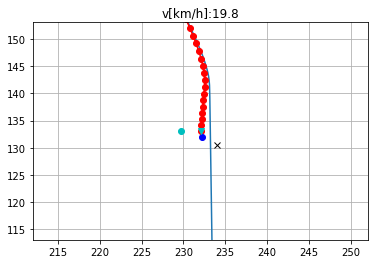

vehicle.get_transform() Transform(Location(x=234.208008, y=42.866024, z=-0.020123), Rotation(pitch=-0.083062, yaw=90.022255, roll=0.020944))
vehicleToFollow.get_transform() Transform(Location(x=232.308319, y=133.000336, z=1.465880), Rotation(pitch=0.170748, yaw=92.411324, roll=33.074020))
obsticle_vehicle.get_transform() Transform(Location(x=233.786697, y=75.530518, z=0.058750), Rotation(pitch=0.383802, yaw=87.779785, roll=0.011318))
ego_position:  (229.7091803470825, 134.13463626033985, 1.0023455516618216, 1.5816288339306235)
path.x[1]:  232.11796776664553
path.y[1]:  134.16073048791884
s:  103.6699548755732


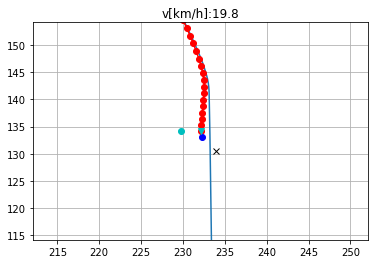

vehicle.get_transform() Transform(Location(x=234.207214, y=43.257114, z=-0.020044), Rotation(pitch=-0.093171, yaw=90.078651, roll=0.021969))
vehicleToFollow.get_transform() Transform(Location(x=232.388977, y=134.145569, z=1.492674), Rotation(pitch=-2.259700, yaw=89.849129, roll=33.952293))
obsticle_vehicle.get_transform() Transform(Location(x=233.786697, y=75.530518, z=0.058750), Rotation(pitch=0.383802, yaw=87.779785, roll=0.011318))
ego_position:  (229.69718438723282, 135.23988543491123, 1.0249090226257607, 1.5817038787980913)
path.x[1]:  232.1762957426361
path.y[1]:  135.26692754339268
s:  104.77576202767851


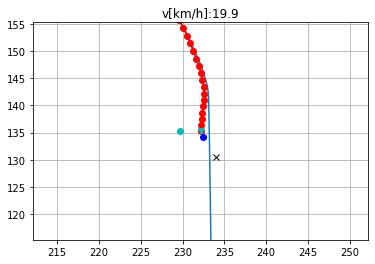

vehicle.get_transform() Transform(Location(x=234.206085, y=43.653969, z=-0.020044), Rotation(pitch=-0.096989, yaw=90.131981, roll=0.024278))
vehicleToFollow.get_transform() Transform(Location(x=232.462891, y=135.229218, z=1.481389), Rotation(pitch=1.022349, yaw=89.935478, roll=37.514107))
obsticle_vehicle.get_transform() Transform(Location(x=233.786697, y=75.530518, z=0.058750), Rotation(pitch=0.383802, yaw=87.779785, roll=0.011318))
ego_position:  (229.68509951060207, 136.3484791261242, 1.0475609584196262, 1.581705219561748)
path.x[1]:  232.24036705829843
path.y[1]:  136.37635537159576
s:  105.88465766400145


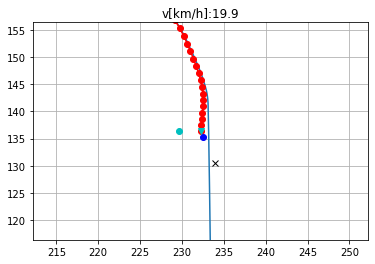

vehicle.get_transform() Transform(Location(x=234.204697, y=44.056438, z=-0.020102), Rotation(pitch=-0.096067, yaw=90.182541, roll=0.027157))
vehicleToFollow.get_transform() Transform(Location(x=232.539307, y=136.340225, z=1.572183), Rotation(pitch=-1.248231, yaw=89.002747, roll=36.697189))
obsticle_vehicle.get_transform() Transform(Location(x=233.786697, y=75.530518, z=0.058750), Rotation(pitch=0.383802, yaw=87.779785, roll=0.011318))
ego_position:  (229.67295453153008, 137.460214772201, 1.0703178271914144, 1.581685861811462)
path.x[1]:  232.3080814286493
path.y[1]:  137.48891121312278
s:  106.99662477719073


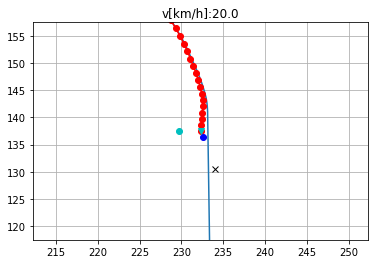

vehicle.get_transform() Transform(Location(x=234.202988, y=44.464394, z=-0.020200), Rotation(pitch=-0.091887, yaw=90.229958, roll=0.029847))
vehicleToFollow.get_transform() Transform(Location(x=232.510040, y=137.356247, z=1.443227), Rotation(pitch=-6.441373, yaw=93.097183, roll=19.985010))
obsticle_vehicle.get_transform() Transform(Location(x=233.786697, y=75.530518, z=0.058750), Rotation(pitch=0.383802, yaw=87.779785, roll=0.011318))
ego_position:  (229.66077264835542, 138.57484268662373, 1.0938525443510303, 1.581708352231852)
path.x[1]:  232.37748071643728
path.y[1]:  138.6044886508478
s:  108.11164645354948


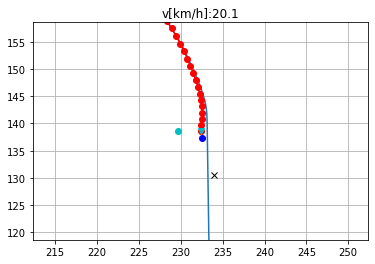

vehicle.get_transform() Transform(Location(x=234.201004, y=44.877705, z=-0.020320), Rotation(pitch=-0.085630, yaw=90.271973, roll=0.030537))
vehicleToFollow.get_transform() Transform(Location(x=232.359741, y=138.551620, z=1.637021), Rotation(pitch=-52.351456, yaw=82.368805, roll=6.144787))
obsticle_vehicle.get_transform() Transform(Location(x=233.786697, y=75.530518, z=0.058750), Rotation(pitch=0.383802, yaw=87.779785, roll=0.011318))
ego_position:  (229.64838763788174, 139.69151774638806, 1.1170001753093444, 1.5820157687150358)
path.x[1]:  232.44661479832035
path.y[1]:  139.72291361083234
s:  109.22970587251946


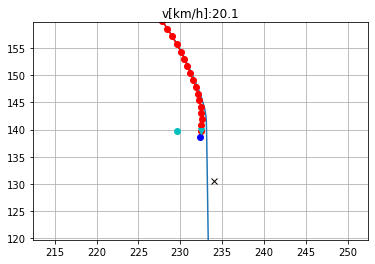

vehicle.get_transform() Transform(Location(x=234.198761, y=45.296268, z=-0.020449), Rotation(pitch=-0.078274, yaw=90.309990, roll=0.031451))
vehicleToFollow.get_transform() Transform(Location(x=232.660248, y=139.597031, z=0.822523), Rotation(pitch=-65.547302, yaw=69.314659, roll=9.358028))
obsticle_vehicle.get_transform() Transform(Location(x=233.786697, y=75.530518, z=0.058750), Rotation(pitch=0.383802, yaw=87.779785, roll=0.011318))
ego_position:  (229.63494126363622, 140.7904780068354, 1.1418730889667346, 1.5882336223487021)
path.x[1]:  232.51284735845783
path.y[1]:  140.84066599279757
s:  110.35078630616813


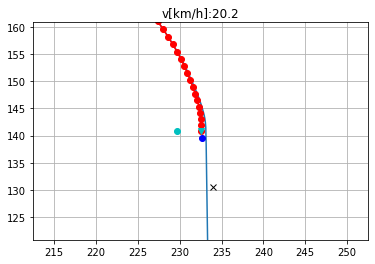

vehicle.get_transform() Transform(Location(x=234.196289, y=45.719994, z=-0.020575), Rotation(pitch=-0.070529, yaw=90.343246, roll=0.031161))
vehicleToFollow.get_transform() Transform(Location(x=232.798492, y=140.363419, z=0.194893), Rotation(pitch=-49.955379, yaw=81.404610, roll=3.074498))
obsticle_vehicle.get_transform() Transform(Location(x=233.786697, y=75.530518, z=0.058750), Rotation(pitch=0.383802, yaw=87.779785, roll=0.011318))
ego_position:  (229.60105925771347, 141.79693254815263, 1.1661858308374118, 1.6215945545836874)
path.x[1]:  232.55265010058065
path.y[1]:  141.94699723297504
s:  111.47487111867866


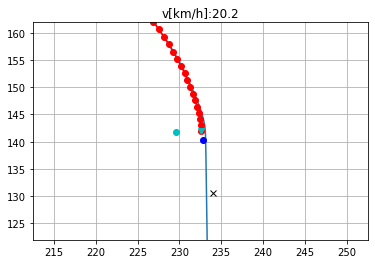

vehicle.get_transform() Transform(Location(x=234.193604, y=46.148785, z=-0.020693), Rotation(pitch=-0.062865, yaw=90.370560, roll=0.029469))
vehicleToFollow.get_transform() Transform(Location(x=232.828934, y=141.468216, z=0.210077), Rotation(pitch=-51.006477, yaw=80.769836, roll=3.291335))
obsticle_vehicle.get_transform() Transform(Location(x=233.786697, y=75.530518, z=0.058750), Rotation(pitch=0.383802, yaw=87.779785, roll=0.011318))
ego_position:  (229.52952366410378, 142.73524716150345, 1.1911555617266818, 1.674642443400374)
path.x[1]:  232.54175618012061
path.y[1]:  143.04918512676562
s:  112.60194376584265


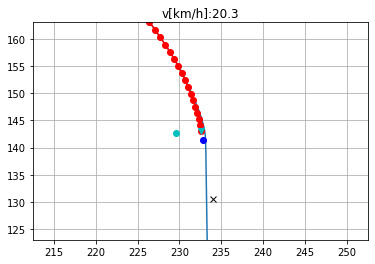

vehicle.get_transform() Transform(Location(x=234.190796, y=46.582558, z=-0.020798), Rotation(pitch=-0.055570, yaw=90.392738, roll=0.027500))
vehicleToFollow.get_transform() Transform(Location(x=232.808777, y=142.569611, z=0.226257), Rotation(pitch=-52.108692, yaw=80.185295, roll=3.352326))
obsticle_vehicle.get_transform() Transform(Location(x=233.786697, y=75.530518, z=0.058750), Rotation(pitch=0.383802, yaw=87.779785, roll=0.011318))
ego_position:  (229.4063591373049, 143.60833974424622, 1.2166175195698108, 1.745454630162648)
path.x[1]:  232.4562303064787
path.y[1]:  144.14650860391637
s:  113.73198779455562


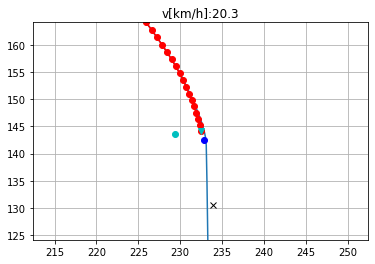

vehicle.get_transform() Transform(Location(x=234.187790, y=47.021244, z=-0.020889), Rotation(pitch=-0.048863, yaw=90.411896, roll=0.026408))
vehicleToFollow.get_transform() Transform(Location(x=232.717026, y=143.665741, z=0.241390), Rotation(pitch=-53.155697, yaw=79.553139, roll=3.793489))
obsticle_vehicle.get_transform() Transform(Location(x=233.786697, y=75.530518, z=0.058750), Rotation(pitch=0.383802, yaw=87.779785, roll=0.011318))
ego_position:  (229.21029436326094, 144.6565501543977, 1.2406575912271602, 1.764411258863625)
path.x[1]:  232.31141365227174
path.y[1]:  145.26459002193084
s:  114.86498684231543


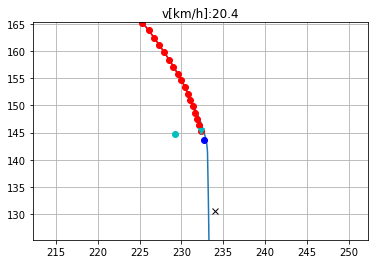

vehicle.get_transform() Transform(Location(x=234.184616, y=47.464779, z=-0.020966), Rotation(pitch=-0.042757, yaw=90.428978, roll=0.025655))
vehicleToFollow.get_transform() Transform(Location(x=232.564819, y=144.783234, z=0.256913), Rotation(pitch=-54.229465, yaw=78.998009, roll=3.904461))
obsticle_vehicle.get_transform() Transform(Location(x=233.786697, y=75.530518, z=0.058750), Rotation(pitch=0.383802, yaw=87.779785, roll=0.011318))
ego_position:  (228.997452809531, 145.65642678507703, 1.2660481917130637, 1.7967924524359715)
path.x[1]:  232.13335981537423
path.y[1]:  146.3774468048034
s:  116.00092463672328


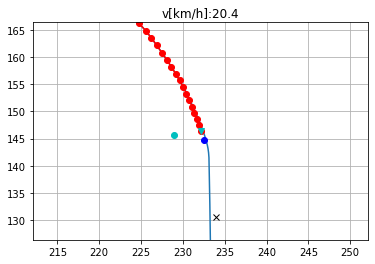

vehicle.get_transform() Transform(Location(x=234.181244, y=47.913109, z=-0.021031), Rotation(pitch=-0.037293, yaw=90.445389, roll=0.025565))
vehicleToFollow.get_transform() Transform(Location(x=232.380478, y=145.896240, z=0.273681), Rotation(pitch=-55.362228, yaw=78.431358, roll=4.105323))
obsticle_vehicle.get_transform() Transform(Location(x=233.786697, y=75.530518, z=0.058750), Rotation(pitch=0.383802, yaw=87.779785, roll=0.011318))
ego_position:  (228.74948062929977, 146.67398146633386, 1.2902211485092645, 1.8228624250817698)
path.x[1]:  231.91567011862958
path.y[1]:  147.48941423302784
s:  117.13978499498758


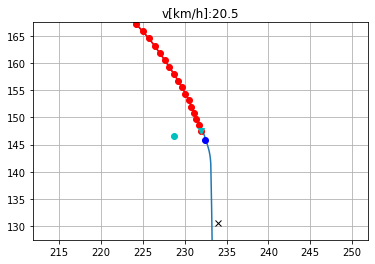

vehicle.get_transform() Transform(Location(x=234.177658, y=48.366169, z=-0.021084), Rotation(pitch=-0.032409, yaw=90.462822, roll=0.026314))
vehicleToFollow.get_transform() Transform(Location(x=232.127731, y=147.074631, z=0.353214), Rotation(pitch=-43.264366, yaw=83.667252, roll=-1.495453))
obsticle_vehicle.get_transform() Transform(Location(x=233.786697, y=75.530518, z=0.058750), Rotation(pitch=0.383802, yaw=87.779785, roll=0.011318))
ego_position:  (228.47014609709143, 147.7186092873448, 1.3157692123190112, 1.8400452830428458)
path.x[1]:  231.66618507039234
path.y[1]:  148.60055539110678
s:  118.28155182343046


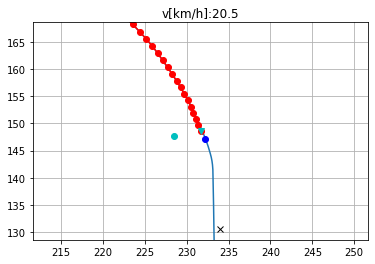

vehicle.get_transform() Transform(Location(x=234.173798, y=48.823914, z=-0.021127), Rotation(pitch=-0.028079, yaw=90.482513, roll=0.027803))
vehicleToFollow.get_transform() Transform(Location(x=231.740250, y=148.572403, z=0.484566), Rotation(pitch=1.082694, yaw=87.063614, roll=-8.797190))
obsticle_vehicle.get_transform() Transform(Location(x=233.786697, y=75.530518, z=0.058750), Rotation(pitch=0.383802, yaw=87.779785, roll=0.011318))
ego_position:  (228.16957792571856, 148.78505044891213, 1.3409537852277182, 1.8504418391669601)
path.x[1]:  231.39501889113146
path.y[1]:  149.71130215501427
s:  119.42620911699713


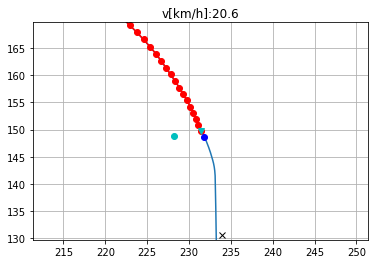

vehicle.get_transform() Transform(Location(x=234.169678, y=49.286304, z=-0.021163), Rotation(pitch=-0.024199, yaw=90.505653, roll=0.029998))
vehicleToFollow.get_transform() Transform(Location(x=231.469040, y=149.683197, z=0.474223), Rotation(pitch=1.086997, yaw=87.063179, roll=-8.797161))
obsticle_vehicle.get_transform() Transform(Location(x=233.786697, y=75.530518, z=0.058750), Rotation(pitch=0.383802, yaw=87.779785, roll=0.011318))
ego_position:  (227.8548517369379, 149.86749072283436, 1.3661734800383263, 1.8561524670573932)
path.x[1]:  231.1084014382829
path.y[1]:  150.8219597180283
s:  120.57374095876777


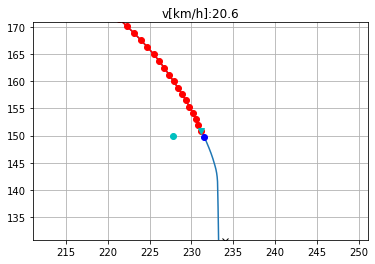

vehicle.get_transform() Transform(Location(x=234.165268, y=49.753277, z=-0.021193), Rotation(pitch=-0.020723, yaw=90.533386, roll=0.032991))
vehicleToFollow.get_transform() Transform(Location(x=231.182343, y=150.793854, z=0.463881), Rotation(pitch=1.090658, yaw=87.062851, roll=-8.797192))
obsticle_vehicle.get_transform() Transform(Location(x=233.786697, y=75.530518, z=0.058750), Rotation(pitch=0.383802, yaw=87.779785, roll=0.011318))
ego_position:  (227.53193209086487, 150.9588301988388, 1.391772717806496, 1.859579046002144)
path.x[1]:  230.8106801280304
path.y[1]:  151.9329055429461
s:  121.72413151947225


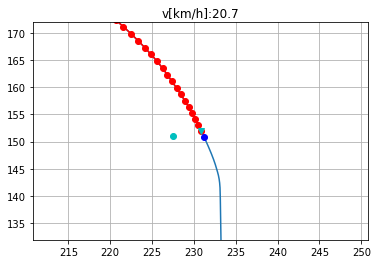

vehicle.get_transform() Transform(Location(x=234.160477, y=50.224792, z=-0.021218), Rotation(pitch=-0.017608, yaw=90.566528, roll=0.036555))
vehicleToFollow.get_transform() Transform(Location(x=230.884567, y=151.904800, z=0.453539), Rotation(pitch=1.093773, yaw=87.062424, roll=-8.797192))
obsticle_vehicle.get_transform() Transform(Location(x=233.786697, y=75.530518, z=0.058750), Rotation(pitch=0.383802, yaw=87.779785, roll=0.011318))
ego_position:  (227.21365114800508, 152.010947216581, 1.4174275735953457, 1.87493124028662)
path.x[1]:  230.50085810799678
path.y[1]:  153.04271159844527
s:  122.87736505700745


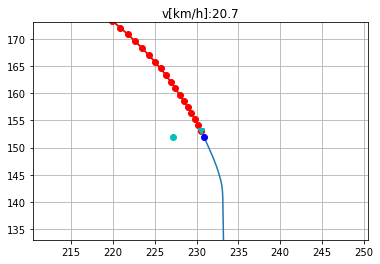

vehicle.get_transform() Transform(Location(x=234.155319, y=50.700832, z=-0.021240), Rotation(pitch=-0.014801, yaw=90.605415, roll=0.040534))
vehicleToFollow.get_transform() Transform(Location(x=230.574707, y=153.014648, z=0.443196), Rotation(pitch=1.096409, yaw=87.062073, roll=-8.797192))
obsticle_vehicle.get_transform() Transform(Location(x=233.786697, y=75.530518, z=0.058750), Rotation(pitch=0.383802, yaw=87.779785, roll=0.011318))
ego_position:  (226.88334411236806, 153.0217036975635, 1.442638860793204, 1.901334017114114)
path.x[1]:  230.1616289136191
path.y[1]:  154.1465676358136
s:  124.0334259159573


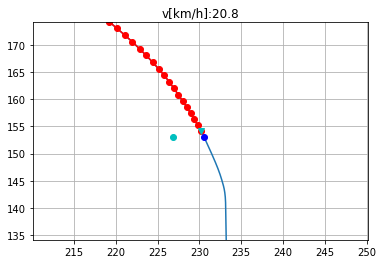

vehicle.get_transform() Transform(Location(x=234.149719, y=51.181347, z=-0.021259), Rotation(pitch=-0.012233, yaw=90.650536, roll=0.045002))
vehicleToFollow.get_transform() Transform(Location(x=230.235428, y=154.118500, z=0.432854), Rotation(pitch=1.098636, yaw=87.061745, roll=-8.797250))
obsticle_vehicle.get_transform() Transform(Location(x=233.786697, y=75.530518, z=0.058750), Rotation(pitch=0.383802, yaw=87.779785, roll=0.011318))
ego_position:  (226.52290353873138, 154.00882901839205, 1.4688117278135755, 1.9320956784624672)
path.x[1]:  229.78060326489248
path.y[1]:  155.23987146324149
s:  125.19229852711531


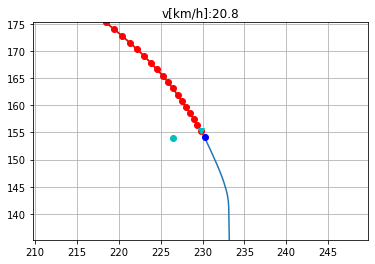

vehicle.get_transform() Transform(Location(x=234.143631, y=51.666313, z=-0.021239), Rotation(pitch=-0.008148, yaw=90.700935, roll=0.041654))
vehicleToFollow.get_transform() Transform(Location(x=229.854324, y=155.211807, z=0.422512), Rotation(pitch=1.100548, yaw=87.061455, roll=-8.797253))
obsticle_vehicle.get_transform() Transform(Location(x=233.786697, y=75.530518, z=0.058750), Rotation(pitch=0.383802, yaw=87.779785, roll=0.011318))
ego_position:  (226.12007145659666, 155.0652916597803, 1.4940985682393655, 1.9408763469554995)
path.x[1]:  229.3790836129763
path.y[1]:  156.32964244679954
s:  126.35396740701


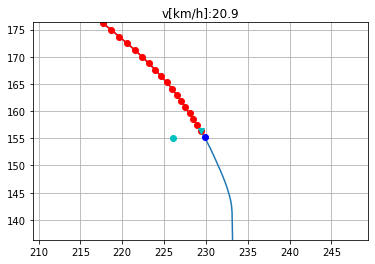

vehicle.get_transform() Transform(Location(x=234.137009, y=52.155701, z=-0.021141), Rotation(pitch=-0.001434, yaw=90.756615, roll=0.029339))
vehicleToFollow.get_transform() Transform(Location(x=229.452774, y=156.301620, z=0.412170), Rotation(pitch=1.102106, yaw=87.061165, roll=-8.797253))
obsticle_vehicle.get_transform() Transform(Location(x=233.786697, y=75.530518, z=0.058750), Rotation(pitch=0.383802, yaw=87.779785, roll=0.011318))
ego_position:  (225.71166641208052, 156.0911666639438, 1.5202602637688147, 1.9580090044862268)
path.x[1]:  228.95786379839285
path.y[1]:  157.41496709492645
s:  127.51841715743267


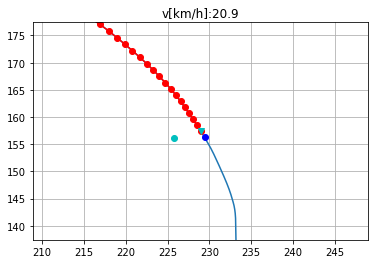

vehicle.get_transform() Transform(Location(x=234.129883, y=52.649475, z=-0.020942), Rotation(pitch=0.009009, yaw=90.818253, roll=0.023924))
vehicleToFollow.get_transform() Transform(Location(x=229.031525, y=157.386932, z=0.401829), Rotation(pitch=1.103458, yaw=87.060921, roll=-8.797253))
obsticle_vehicle.get_transform() Transform(Location(x=233.786697, y=75.530518, z=0.058750), Rotation(pitch=0.383802, yaw=87.779785, roll=0.011318))
ego_position:  (225.28297401543583, 157.1193584856303, 1.5455082949472212, 1.9731380641047378)
path.x[1]:  228.51560256144592
path.y[1]:  158.49502390274483
s:  128.68563246496785


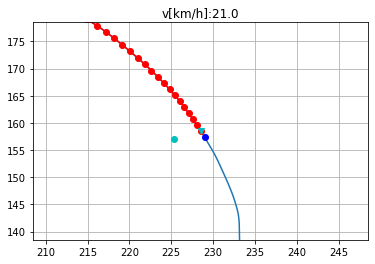

vehicle.get_transform() Transform(Location(x=234.122147, y=53.147610, z=-0.020642), Rotation(pitch=0.023557, yaw=90.886337, roll=0.027285))
vehicleToFollow.get_transform() Transform(Location(x=228.589172, y=158.467010, z=0.391512), Rotation(pitch=1.101354, yaw=87.063118, roll=-8.797251))
obsticle_vehicle.get_transform() Transform(Location(x=233.786697, y=75.530518, z=0.058750), Rotation(pitch=0.383802, yaw=87.779785, roll=0.011318))
ego_position:  (224.83469631356, 158.1546044272803, 1.5716659100076842, 1.9850046590344848)
path.x[1]:  228.05550920969438
path.y[1]:  159.57061454735776
s:  129.85559810052655


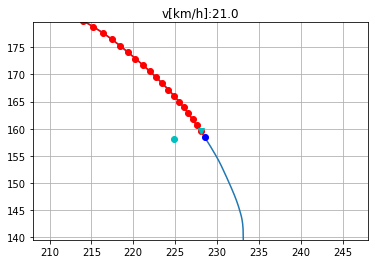

vehicle.get_transform() Transform(Location(x=234.113663, y=53.650063, z=-0.020277), Rotation(pitch=0.040715, yaw=90.963699, roll=0.035722))
vehicleToFollow.get_transform() Transform(Location(x=228.129059, y=159.542618, z=0.381219), Rotation(pitch=1.096505, yaw=87.067581, roll=-8.797100))
obsticle_vehicle.get_transform() Transform(Location(x=233.786697, y=75.530518, z=0.058750), Rotation(pitch=0.383802, yaw=87.779785, roll=0.011318))
ego_position:  (224.36965353706995, 159.19972435255966, 1.5967749897345183, 1.993151774266812)
path.x[1]:  227.5818294153132
path.y[1]:  160.6432784850599
s:  131.02829891888166


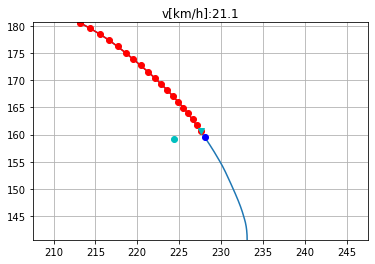

vehicle.get_transform() Transform(Location(x=234.104355, y=54.156807, z=-0.019872), Rotation(pitch=0.059313, yaw=91.051399, roll=0.046080))
vehicleToFollow.get_transform() Transform(Location(x=227.655304, y=160.615280, z=0.370939), Rotation(pitch=1.090494, yaw=87.073578, roll=-8.796885))
obsticle_vehicle.get_transform() Transform(Location(x=233.786697, y=75.530518, z=0.058750), Rotation(pitch=0.383802, yaw=87.779785, roll=0.011318))
ego_position:  (223.89219837560273, 160.25403700667567, 1.6235163286877343, 1.998217862910803)
path.x[1]:  227.09861991016635
path.y[1]:  161.714574527562
s:  132.20371985820637


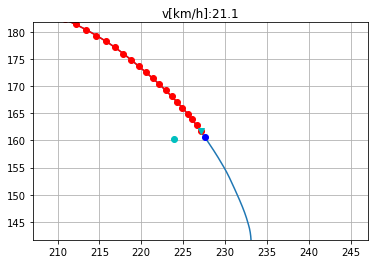

vehicle.get_transform() Transform(Location(x=234.094070, y=54.667797, z=-0.019416), Rotation(pitch=0.077407, yaw=91.149147, roll=0.054387))
vehicleToFollow.get_transform() Transform(Location(x=227.172028, y=161.686584, z=0.360669), Rotation(pitch=1.084204, yaw=87.080513, roll=-8.796703))
obsticle_vehicle.get_transform() Transform(Location(x=233.786697, y=75.530518, z=0.058750), Rotation(pitch=0.383802, yaw=87.779785, roll=0.011318))
ego_position:  (223.41692733817902, 161.28705217082455, 1.6488908724370865, 2.0098592263006605)
path.x[1]:  226.60660689162506
path.y[1]:  162.78504127563488
s:  133.38184593961475


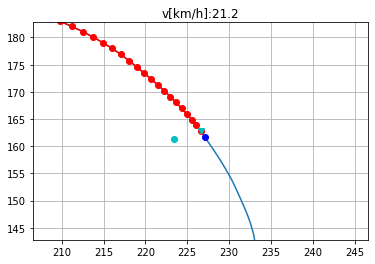

vehicle.get_transform() Transform(Location(x=234.082809, y=55.183006, z=-0.018882), Rotation(pitch=0.093027, yaw=91.256805, roll=0.058575))
vehicleToFollow.get_transform() Transform(Location(x=226.679993, y=162.757080, z=0.350406), Rotation(pitch=1.078241, yaw=87.087822, roll=-8.796426))
obsticle_vehicle.get_transform() Transform(Location(x=233.786697, y=75.530518, z=0.058750), Rotation(pitch=0.383802, yaw=87.779785, roll=0.011318))
ego_position:  (222.94038328700213, 162.2722514388617, 1.6754182642055864, 2.0344587811562946)
path.x[1]:  226.0918667890996
path.y[1]:  163.84805167148076
s:  134.56266226670508


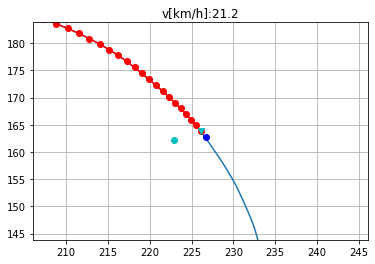

vehicle.get_transform() Transform(Location(x=234.070480, y=55.702393, z=-0.018227), Rotation(pitch=0.103785, yaw=91.373878, roll=0.065833))
vehicleToFollow.get_transform() Transform(Location(x=226.165207, y=163.820068, z=0.340148), Rotation(pitch=1.072961, yaw=87.095451, roll=-8.796154))
obsticle_vehicle.get_transform() Transform(Location(x=233.786697, y=75.530518, z=0.058750), Rotation(pitch=0.383802, yaw=87.779785, roll=0.011318))
ego_position:  (222.45823548433913, 163.19198880306695, 1.7012895340651077, 2.0758003033912193)
path.x[1]:  225.5408927202092
path.y[1]:  164.89613644127752
s:  135.74615402510565


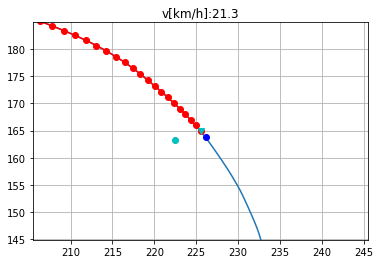

vehicle.get_transform() Transform(Location(x=234.057022, y=56.225933, z=-0.017452), Rotation(pitch=0.109631, yaw=91.500320, roll=0.075646))
vehicleToFollow.get_transform() Transform(Location(x=225.614182, y=164.868164, z=0.329894), Rotation(pitch=1.068419, yaw=87.103096, roll=-8.795848))
obsticle_vehicle.get_transform() Transform(Location(x=233.786697, y=75.530518, z=0.058750), Rotation(pitch=0.383802, yaw=87.779785, roll=0.011318))
ego_position:  (221.9043401893666, 164.1649635037622, 1.7270943188301073, 2.094735747274179)
path.x[1]:  224.95273753822815
path.y[1]:  165.92634136740458
s:  136.93230648202302


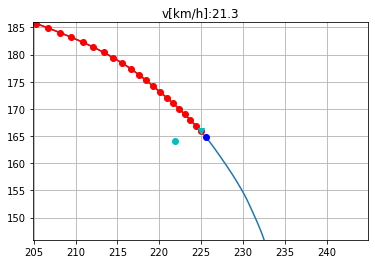

vehicle.get_transform() Transform(Location(x=234.042313, y=56.753601, z=-0.016595), Rotation(pitch=0.112131, yaw=91.635574, roll=0.085474))
vehicleToFollow.get_transform() Transform(Location(x=225.025970, y=165.898376, z=0.319645), Rotation(pitch=1.064765, yaw=87.110703, roll=-8.795604))
obsticle_vehicle.get_transform() Transform(Location(x=233.786697, y=75.530518, z=0.058750), Rotation(pitch=0.383802, yaw=87.779785, roll=0.011318))
ego_position:  (221.3335974080442, 165.13424067357292, 1.7532878831066239, 2.1129259165654237)
path.x[1]:  224.34773599913368
path.y[1]:  166.94974108273516
s:  138.12110498579278


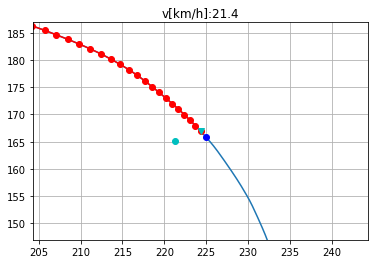

vehicle.get_transform() Transform(Location(x=234.026260, y=57.285381, z=-0.015687), Rotation(pitch=0.112541, yaw=91.779968, roll=0.095374))
vehicleToFollow.get_transform() Transform(Location(x=224.420914, y=166.921814, z=0.309399), Rotation(pitch=1.061855, yaw=87.118187, roll=-8.795299))
obsticle_vehicle.get_transform() Transform(Location(x=233.786697, y=75.530518, z=0.058750), Rotation(pitch=0.383802, yaw=87.779785, roll=0.011318))
ego_position:  (220.74537458945454, 166.08844051344258, 1.7793450093208225, 2.1329808404279955)
path.x[1]:  223.72063861626037
path.y[1]:  167.96284758102757
s:  139.31253496543283


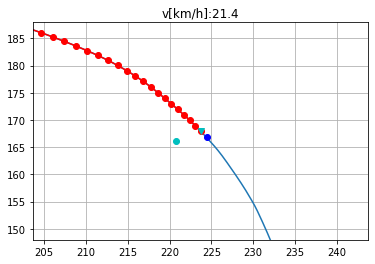

vehicle.get_transform() Transform(Location(x=234.008820, y=57.821243, z=-0.014749), Rotation(pitch=0.111749, yaw=91.932281, roll=0.104492))
vehicleToFollow.get_transform() Transform(Location(x=223.793777, y=167.934952, z=0.299159), Rotation(pitch=1.059690, yaw=87.125587, roll=-8.795054))
obsticle_vehicle.get_transform() Transform(Location(x=233.786697, y=75.530518, z=0.058750), Rotation(pitch=0.383802, yaw=87.779785, roll=0.011318))
ego_position:  (220.13344336898717, 167.03986455970875, 1.8050897576112457, 2.1508475711988595)
path.x[1]:  223.07283902027302
path.y[1]:  168.96587913990416
s:  140.5065819301991


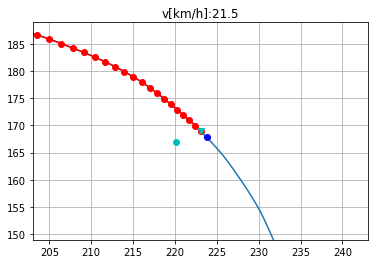

vehicle.get_transform() Transform(Location(x=233.989883, y=58.361172, z=-0.013799), Rotation(pitch=0.110424, yaw=92.092514, roll=0.113784))
vehicleToFollow.get_transform() Transform(Location(x=223.145950, y=168.937988, z=0.288923), Rotation(pitch=1.058201, yaw=87.132797, roll=-8.794812))
obsticle_vehicle.get_transform() Transform(Location(x=233.786697, y=75.530518, z=0.058750), Rotation(pitch=0.383802, yaw=87.779785, roll=0.011318))
ego_position:  (219.49951543043508, 167.9936202420409, 1.8317821499439555, 2.1654565648068584)
path.x[1]:  222.40858566884486
path.y[1]:  169.96110085358788
s:  141.7032314691437


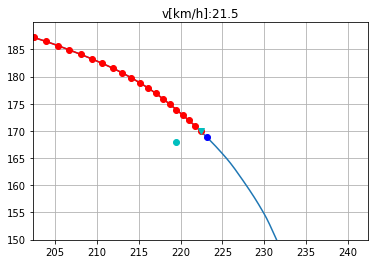

vehicle.get_transform() Transform(Location(x=233.969315, y=58.905132, z=-0.012848), Rotation(pitch=0.109030, yaw=92.261665, roll=0.124026))
vehicleToFollow.get_transform() Transform(Location(x=222.481613, y=169.933197, z=0.278693), Rotation(pitch=1.057272, yaw=87.139931, roll=-8.794568))
obsticle_vehicle.get_transform() Transform(Location(x=233.786697, y=75.530518, z=0.058750), Rotation(pitch=0.383802, yaw=87.779785, roll=0.011318))
ego_position:  (218.87208271132562, 168.8959498019259, 1.858051066179302, 2.193996432903275)
path.x[1]:  221.7220549054982
path.y[1]:  170.94437067132603
s:  142.90246925067544


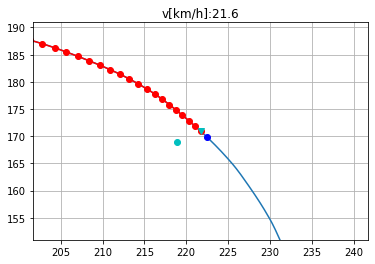

vehicle.get_transform() Transform(Location(x=233.947006, y=59.453091, z=-0.011904), Rotation(pitch=0.107856, yaw=92.440376, roll=0.135301))
vehicleToFollow.get_transform() Transform(Location(x=221.795029, y=170.916473, z=0.268469), Rotation(pitch=1.056780, yaw=87.146904, roll=-8.794353))
obsticle_vehicle.get_transform() Transform(Location(x=233.786697, y=75.530518, z=0.058750), Rotation(pitch=0.383802, yaw=87.779785, roll=0.011318))
ego_position:  (218.19103129605847, 169.8234220092488, 1.8841655496089995, 2.208526295027695)
path.x[1]:  221.00930036564222
path.y[1]:  171.91181957663932
s:  144.10428102212282


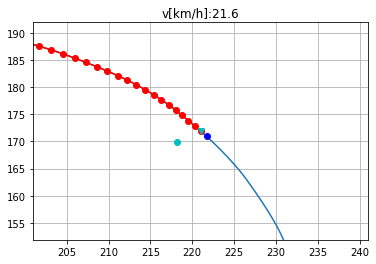

vehicle.get_transform() Transform(Location(x=233.922882, y=60.005032, z=-0.010968), Rotation(pitch=0.107077, yaw=92.629311, roll=0.147540))
vehicleToFollow.get_transform() Transform(Location(x=221.082245, y=171.883896, z=0.258251), Rotation(pitch=1.056739, yaw=87.153816, roll=-8.794140))
obsticle_vehicle.get_transform() Transform(Location(x=233.786697, y=75.530518, z=0.058750), Rotation(pitch=0.383802, yaw=87.779785, roll=0.011318))
ego_position:  (217.49111092630343, 170.75959481391814, 1.9104184018241133, 2.218580272976205)
path.x[1]:  220.2867520736734
path.y[1]:  172.87509432091827
s:  145.30865260929963


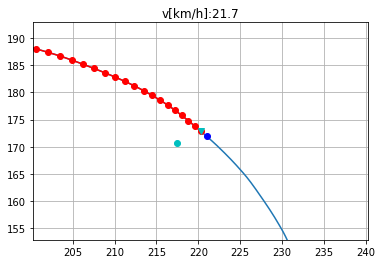

vehicle.get_transform() Transform(Location(x=233.896866, y=60.560921, z=-0.010043), Rotation(pitch=0.106701, yaw=92.826508, roll=0.158925))
vehicleToFollow.get_transform() Transform(Location(x=220.359604, y=172.847229, z=0.248185), Rotation(pitch=1.066370, yaw=87.158936, roll=-8.750562))
obsticle_vehicle.get_transform() Transform(Location(x=233.786697, y=75.530518, z=0.058750), Rotation(pitch=0.383802, yaw=87.779785, roll=0.011318))
ego_position:  (216.78198555904117, 171.68603562806646, 1.9367033198280383, 2.229992383977561)
path.x[1]:  219.55198191526418
path.y[1]:  173.8322773546634
s:  146.5155699160725


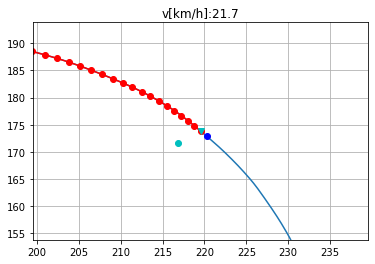

vehicle.get_transform() Transform(Location(x=233.868927, y=61.119236, z=-0.009200), Rotation(pitch=0.114734, yaw=93.029190, roll=0.169882))
vehicleToFollow.get_transform() Transform(Location(x=219.624786, y=173.804398, z=0.238350), Rotation(pitch=1.088657, yaw=87.161942, roll=-8.693067))
obsticle_vehicle.get_transform() Transform(Location(x=233.786697, y=75.530518, z=0.058750), Rotation(pitch=0.383802, yaw=87.779785, roll=0.011318))
ego_position:  (216.05887991021842, 172.60989172521363, 1.962571414464084, 2.2402698718385596)
path.x[1]:  218.80552483459257
path.y[1]:  174.783580032735
s:  147.72501892393134


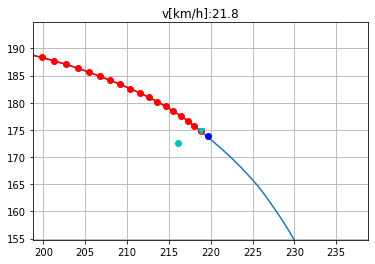

vehicle.get_transform() Transform(Location(x=233.839096, y=61.677559, z=-0.008514), Rotation(pitch=0.138243, yaw=93.234398, roll=0.181854))
vehicleToFollow.get_transform() Transform(Location(x=218.878250, y=174.755737, z=0.228573), Rotation(pitch=1.110944, yaw=87.165161, roll=-8.711008))
obsticle_vehicle.get_transform() Transform(Location(x=233.786697, y=75.530518, z=0.058750), Rotation(pitch=0.383802, yaw=87.779785, roll=0.011318))
ego_position:  (215.34096603187461, 173.50339534442617, 1.9896644687489626, 2.258973162737951)
path.x[1]:  218.0455095018541
path.y[1]:  175.7272755588747
s:  148.93698569156172


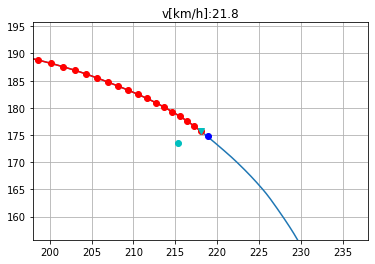

vehicle.get_transform() Transform(Location(x=233.807404, y=62.235439, z=-0.007929), Rotation(pitch=0.170488, yaw=93.440811, roll=0.194576))
vehicleToFollow.get_transform() Transform(Location(x=218.118179, y=175.699448, z=0.218987), Rotation(pitch=1.141728, yaw=87.168266, roll=-8.770092))
obsticle_vehicle.get_transform() Transform(Location(x=233.786697, y=75.530518, z=0.058750), Rotation(pitch=0.383802, yaw=87.779785, roll=0.011318))
ego_position:  (214.6277186150361, 174.34691875784998, 2.0154438147553106, 2.290262703696444)
path.x[1]:  217.26057661789756
path.y[1]:  176.65362944775774
s:  150.1514563544198


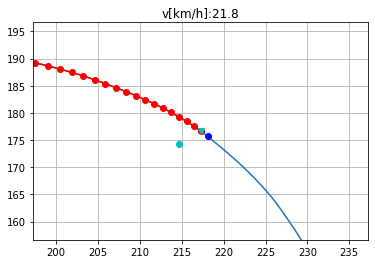

vehicle.get_transform() Transform(Location(x=233.773758, y=62.792812, z=-0.007386), Rotation(pitch=0.205070, yaw=93.648018, roll=0.206929))
vehicleToFollow.get_transform() Transform(Location(x=217.333176, y=176.625824, z=0.209458), Rotation(pitch=1.173618, yaw=87.171425, roll=-8.804241))
obsticle_vehicle.get_transform() Transform(Location(x=233.786697, y=75.530518, z=0.058750), Rotation(pitch=0.383802, yaw=87.779785, roll=0.011318))
ego_position:  (213.9003546634716, 175.14778788508445, 2.041635309360679, 2.3287667029424512)
path.x[1]:  216.4418452712991
path.y[1]:  177.5535522008068
s:  151.3684171243096


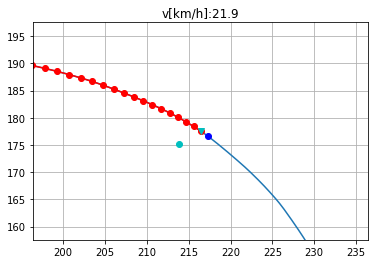

vehicle.get_transform() Transform(Location(x=233.738174, y=63.349655, z=-0.006837), Rotation(pitch=0.237895, yaw=93.855583, roll=0.217896))
vehicleToFollow.get_transform() Transform(Location(x=216.514435, y=177.525711, z=0.199965), Rotation(pitch=1.181158, yaw=87.176888, roll=-8.764385))
obsticle_vehicle.get_transform() Transform(Location(x=233.786697, y=75.530518, z=0.058750), Rotation(pitch=0.383802, yaw=87.779785, roll=0.011318))
ego_position:  (213.16358899922872, 175.88733796716795, 2.067680267026627, 2.37881170746697)
path.x[1]:  215.58108594796965
path.y[1]:  178.41673906562275
s:  152.58785428896263


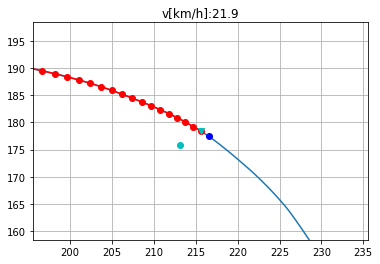

vehicle.get_transform() Transform(Location(x=233.700439, y=63.905922, z=-0.006254), Rotation(pitch=0.266855, yaw=94.073883, roll=0.234274))
vehicleToFollow.get_transform() Transform(Location(x=215.653595, y=178.388947, z=0.190505), Rotation(pitch=1.172409, yaw=87.183891, roll=-8.735425))
obsticle_vehicle.get_transform() Transform(Location(x=233.786697, y=75.530518, z=0.058750), Rotation(pitch=0.383802, yaw=87.779785, roll=0.011318))
ego_position:  (212.3344392995053, 176.6588595803418, 2.0933534447464672, 2.404250680774962)
path.x[1]:  214.68647271891453
path.y[1]:  179.24855672715879
s:  153.8097542116197


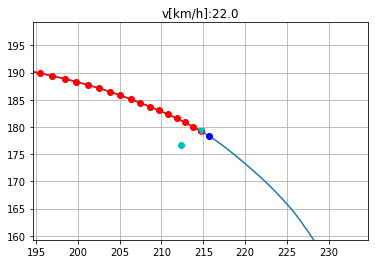

vehicle.get_transform() Transform(Location(x=233.660324, y=64.461586, z=-0.005625), Rotation(pitch=0.291130, yaw=94.307022, roll=0.252157))
vehicleToFollow.get_transform() Transform(Location(x=214.758942, y=179.220779, z=0.181080), Rotation(pitch=1.154971, yaw=87.192261, roll=-8.766979))
obsticle_vehicle.get_transform() Transform(Location(x=233.786697, y=75.530518, z=0.058750), Rotation(pitch=0.383802, yaw=87.779785, roll=0.011318))
ego_position:  (211.50117410082575, 177.39207834092377, 2.120135747436203, 2.4368478615778595)
path.x[1]:  213.7673199544438
path.y[1]:  180.0567780838991
s:  155.0341033306151


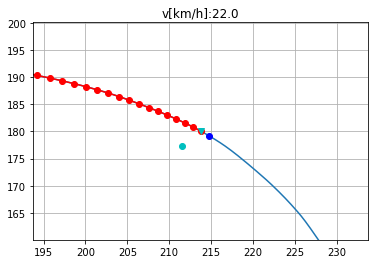

vehicle.get_transform() Transform(Location(x=233.617828, y=65.016624, z=-0.004942), Rotation(pitch=0.310487, yaw=94.553345, roll=0.267840))
vehicleToFollow.get_transform() Transform(Location(x=213.839737, y=180.029007, z=0.171974), Rotation(pitch=1.138005, yaw=87.200478, roll=-8.761120))
obsticle_vehicle.get_transform() Transform(Location(x=233.786697, y=75.530518, z=0.058750), Rotation(pitch=0.383802, yaw=87.779785, roll=0.011318))
ego_position:  (210.65056233414194, 178.0916183562325, 2.1459757237356656, 2.472607715942492)
path.x[1]:  212.8198428621286
path.y[1]:  180.83544762809788
s:  156.26088815896318


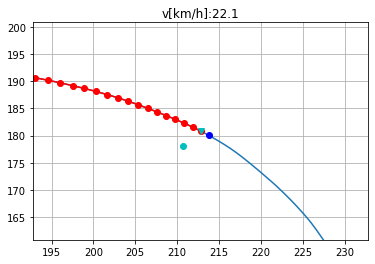

vehicle.get_transform() Transform(Location(x=233.572891, y=65.571037, z=-0.004204), Rotation(pitch=0.325213, yaw=94.811806, roll=0.281270))
vehicleToFollow.get_transform() Transform(Location(x=212.892227, y=180.807648, z=0.162982), Rotation(pitch=1.140061, yaw=87.206322, roll=-8.755718))
obsticle_vehicle.get_transform() Transform(Location(x=233.786697, y=75.530518, z=0.058750), Rotation(pitch=0.383802, yaw=87.779785, roll=0.011318))
ego_position:  (209.78048047776338, 178.7489427824893, 2.17240399453742, 2.512151179322482)
path.x[1]:  211.83951639882528
path.y[1]:  181.57628048304005
s:  157.49009528394703


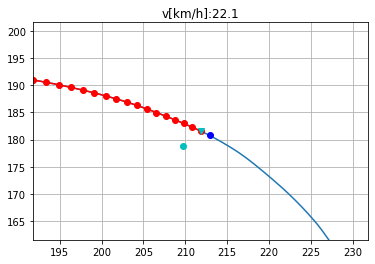

vehicle.get_transform() Transform(Location(x=233.525436, y=66.124794, z=-0.003415), Rotation(pitch=0.335875, yaw=95.081421, roll=0.292816))
vehicleToFollow.get_transform() Transform(Location(x=211.911835, y=181.548492, z=0.154061), Rotation(pitch=1.169082, yaw=87.208710, roll=-8.756236))
obsticle_vehicle.get_transform() Transform(Location(x=233.786697, y=75.530518, z=0.058750), Rotation(pitch=0.383802, yaw=87.779785, roll=0.011318))
ego_position:  (208.85163569104583, 179.40617075489072, 2.1988089165352025, 2.538853507454157)
path.x[1]:  210.83442728636984
path.y[1]:  182.28744196507768
s:  158.7217113667095


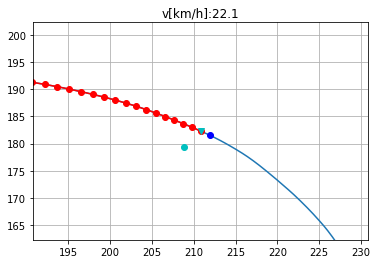

vehicle.get_transform() Transform(Location(x=233.475403, y=66.677879, z=-0.002583), Rotation(pitch=0.343217, yaw=95.361855, roll=0.303462))
vehicleToFollow.get_transform() Transform(Location(x=210.906677, y=182.259659, z=0.145161), Rotation(pitch=1.215487, yaw=87.208786, roll=-8.756114))
obsticle_vehicle.get_transform() Transform(Location(x=233.786697, y=75.530518, z=0.058750), Rotation(pitch=0.383802, yaw=87.779785, roll=0.011318))
ego_position:  (207.8951000158671, 180.04737667857768, 2.2249763469907697, 2.56232452190672)
path.x[1]:  209.80974323059266
path.y[1]:  182.9744155059388
s:  159.9557231418466


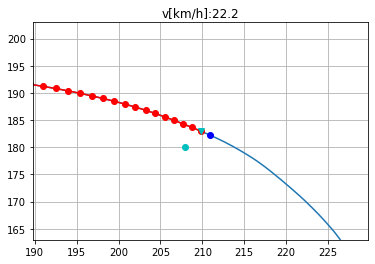

vehicle.get_transform() Transform(Location(x=233.422668, y=67.230286, z=-0.001717), Rotation(pitch=0.347957, yaw=95.652542, roll=0.313576))
vehicleToFollow.get_transform() Transform(Location(x=209.881897, y=182.946716, z=0.136402), Rotation(pitch=1.266952, yaw=87.207863, roll=-8.732159))
obsticle_vehicle.get_transform() Transform(Location(x=233.786697, y=75.530518, z=0.058750), Rotation(pitch=0.383802, yaw=87.779785, roll=0.011318))
ego_position:  (206.91174168612588, 180.6759701478914, 2.2517606368042498, 2.582035702327053)
path.x[1]:  208.76836904402046
path.y[1]:  183.64025401801047
s:  161.19211741700275


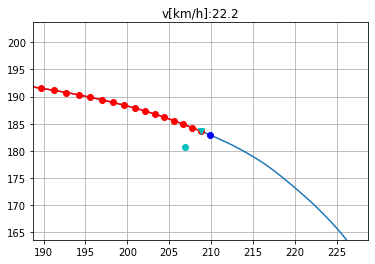

vehicle.get_transform() Transform(Location(x=233.367218, y=67.781982, z=-0.000826), Rotation(pitch=0.350764, yaw=95.953224, roll=0.323660))
vehicleToFollow.get_transform() Transform(Location(x=208.840439, y=183.612549, z=0.127975), Rotation(pitch=1.311533, yaw=87.207748, roll=-8.705089))
obsticle_vehicle.get_transform() Transform(Location(x=233.786697, y=75.530518, z=0.058750), Rotation(pitch=0.383802, yaw=87.779785, roll=0.011318))
ego_position:  (205.90255498772044, 181.29682463462612, 2.2781918568188226, 2.5973505525516445)
path.x[1]:  207.71363773730607
path.y[1]:  184.28930759825457
s:  162.43088107246888


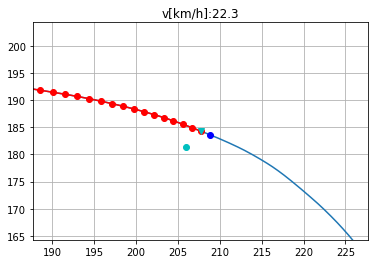

vehicle.get_transform() Transform(Location(x=233.308914, y=68.332939, z=0.000082), Rotation(pitch=0.352246, yaw=96.263924, roll=0.334028))
vehicleToFollow.get_transform() Transform(Location(x=207.785660, y=184.261581, z=0.120046), Rotation(pitch=1.340384, yaw=87.209999, roll=-8.707470))
obsticle_vehicle.get_transform() Transform(Location(x=233.786697, y=75.530518, z=0.058750), Rotation(pitch=0.383802, yaw=87.779785, roll=0.011318))
ego_position:  (204.87199273954883, 181.91192023606564, 2.3045445970108394, 2.6089698632276397)
path.x[1]:  206.6482666039063
path.y[1]:  184.92538536519862
s:  163.6720010607821


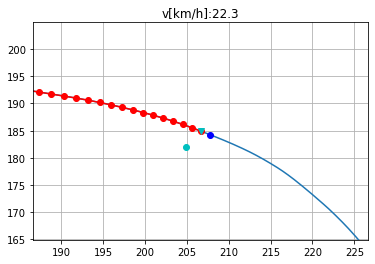

vehicle.get_transform() Transform(Location(x=233.247833, y=68.883171, z=0.001187), Rotation(pitch=0.362540, yaw=96.585571, roll=0.383653))
vehicleToFollow.get_transform() Transform(Location(x=206.720215, y=184.897690, z=0.112420), Rotation(pitch=1.358395, yaw=87.213928, roll=-8.708048))
obsticle_vehicle.get_transform() Transform(Location(x=233.786697, y=75.530518, z=0.058750), Rotation(pitch=0.383802, yaw=87.779785, roll=0.011318))
ego_position:  (203.84123061506304, 182.51128397557153, 2.330560402010812, 2.6235135156969682)
path.x[1]:  205.5735823641501
path.y[1]:  185.55042262355903
s:  164.91553643929333


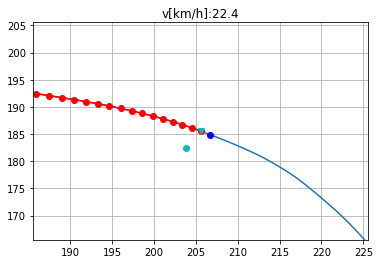

vehicle.get_transform() Transform(Location(x=233.183594, y=69.434532, z=0.002630), Rotation(pitch=0.374868, yaw=96.918304, roll=0.463854))
vehicleToFollow.get_transform() Transform(Location(x=205.645462, y=185.522690, z=0.104988), Rotation(pitch=1.369063, yaw=87.218941, roll=-8.708447))
obsticle_vehicle.get_transform() Transform(Location(x=233.786697, y=75.530518, z=0.058750), Rotation(pitch=0.383802, yaw=87.779785, roll=0.011318))
ego_position:  (202.81993156995958, 183.07831985379397, 2.357091651107639, 2.6456926668043157)
path.x[1]:  204.48454979099864
path.y[1]:  186.15530101004734
s:  166.1616150562007


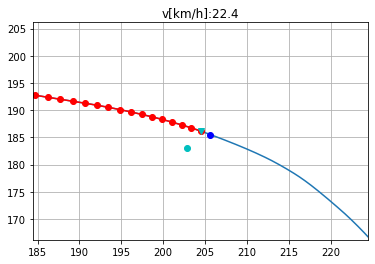

vehicle.get_transform() Transform(Location(x=233.115402, y=69.990982, z=0.004311), Rotation(pitch=0.362840, yaw=97.265251, roll=0.494517))
vehicleToFollow.get_transform() Transform(Location(x=204.556396, y=186.127594, z=0.097675), Rotation(pitch=1.374869, yaw=87.224701, roll=-8.708689))
obsticle_vehicle.get_transform() Transform(Location(x=233.786697, y=75.530518, z=0.058750), Rotation(pitch=0.383802, yaw=87.779785, roll=0.011318))
ego_position:  (201.81102212895692, 183.60570326388253, 2.3822545952354726, 2.677088944425096)
path.x[1]:  203.3783185979194
path.y[1]:  186.73359885355345
s:  167.410221625323


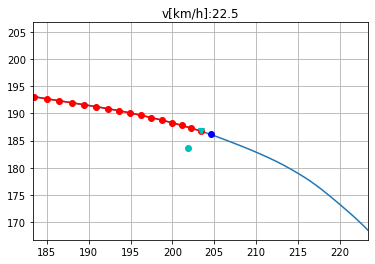

vehicle.get_transform() Transform(Location(x=233.043106, y=70.552612, z=0.006302), Rotation(pitch=0.344399, yaw=97.630043, roll=0.450647))
vehicleToFollow.get_transform() Transform(Location(x=203.450119, y=186.705978, z=0.090434), Rotation(pitch=1.377485, yaw=87.230980, roll=-8.708902))
obsticle_vehicle.get_transform() Transform(Location(x=233.786697, y=75.530518, z=0.058750), Rotation(pitch=0.383802, yaw=87.779785, roll=0.011318))
ego_position:  (200.79694426835607, 184.08868655944022, 2.408603799109936, 2.7135369355389938)
path.x[1]:  202.24930024728687
path.y[1]:  187.27179378909153
s:  168.6613409523569


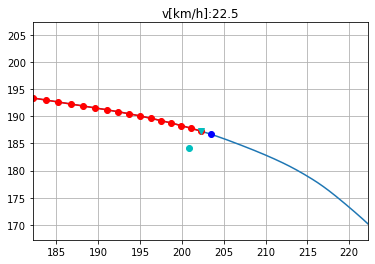

vehicle.get_transform() Transform(Location(x=232.966736, y=71.119133, z=0.008479), Rotation(pitch=0.325971, yaw=98.012650, roll=0.387269))
vehicleToFollow.get_transform() Transform(Location(x=202.321045, y=187.244171, z=0.083233), Rotation(pitch=1.378107, yaw=87.237595, roll=-8.708996))
obsticle_vehicle.get_transform() Transform(Location(x=233.786697, y=75.530518, z=0.058750), Rotation(pitch=0.383802, yaw=87.779785, roll=0.011318))
ego_position:  (199.70674138474612, 184.57636983721278, 2.4346295855664026, 2.7304022186890626)
path.x[1]:  201.10528389128447
path.y[1]:  187.78368854650196
s:  169.91495793432472


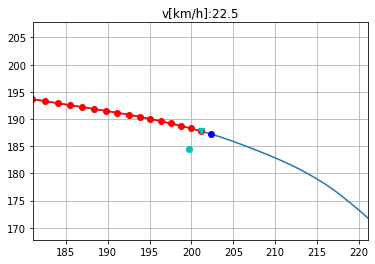

vehicle.get_transform() Transform(Location(x=232.876282, y=71.377190, z=-0.014801), Rotation(pitch=2.088098, yaw=97.419800, roll=1.601441))
vehicleToFollow.get_transform() Transform(Location(x=201.177002, y=187.756058, z=0.076066), Rotation(pitch=1.378073, yaw=87.244423, roll=-8.711772))
obsticle_vehicle.get_transform() Transform(Location(x=233.782104, y=75.527603, z=0.069181), Rotation(pitch=-0.618467, yaw=87.755981, roll=-0.741394))
ego_position:  (198.62646840387103, 185.0326020385605, 2.4605480228577163, 2.754159451885957)
path.x[1]:  199.94849248931234
path.y[1]:  188.27239999897543
s:  171.17105755902554


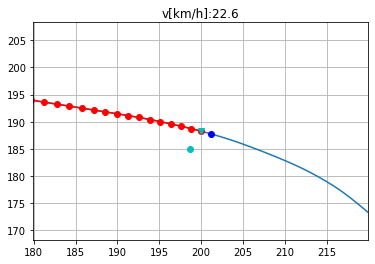

vehicle.get_transform() Transform(Location(x=232.785873, y=71.310379, z=-0.011508), Rotation(pitch=2.727089, yaw=96.520851, roll=-0.102539))
vehicleToFollow.get_transform() Transform(Location(x=200.020096, y=188.244781, z=0.069018), Rotation(pitch=1.382294, yaw=87.250679, roll=-8.732065))
obsticle_vehicle.get_transform() Transform(Location(x=233.782639, y=75.517426, z=0.086885), Rotation(pitch=-2.247774, yaw=87.772408, roll=-1.644806))
ego_position:  (197.5384899222941, 185.45996699314733, 2.4872030302613464, 2.7796898588844745)
path.x[1]:  198.77743574548543
path.y[1]:  188.73260770591648
s:  172.4296249044895


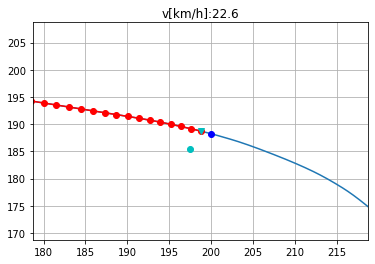

vehicle.get_transform() Transform(Location(x=232.725754, y=71.259964, z=-0.003383), Rotation(pitch=2.693724, yaw=96.312988, roll=-0.587677))
vehicleToFollow.get_transform() Transform(Location(x=198.849014, y=188.704956, z=0.062292), Rotation(pitch=1.404259, yaw=87.253967, roll=-8.720255))
obsticle_vehicle.get_transform() Transform(Location(x=233.784592, y=75.511940, z=0.098966), Rotation(pitch=-3.293059, yaw=87.837044, roll=-1.996033))
ego_position:  (196.41025492417435, 185.87525456540408, 2.513375365125111, 2.796404472665853)
path.x[1]:  197.59437841361148
path.y[1]:  189.16828224180205
s:  173.6906451384355


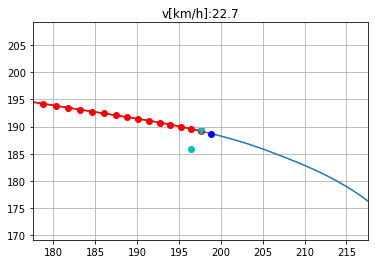

vehicle.get_transform() Transform(Location(x=232.685791, y=71.227249, z=0.003841), Rotation(pitch=2.404677, yaw=96.561890, roll=-1.053894))
vehicleToFollow.get_transform() Transform(Location(x=197.665894, y=189.140656, z=0.055888), Rotation(pitch=1.443437, yaw=87.254333, roll=-8.703654))
obsticle_vehicle.get_transform() Transform(Location(x=233.785812, y=75.510330, z=0.105958), Rotation(pitch=-3.847684, yaw=87.874527, roll=-2.011780))
ego_position:  (195.26750334132367, 186.27595486899494, 2.5396798470190673, 2.811321324647984)
path.x[1]:  196.4024170241096
path.y[1]:  189.58640060634687
s:  174.95410351773222


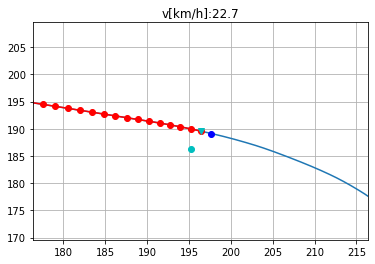

vehicle.get_transform() Transform(Location(x=232.664520, y=71.213531, z=0.010132), Rotation(pitch=1.981588, yaw=96.956512, roll=-1.471619))
vehicleToFollow.get_transform() Transform(Location(x=196.473846, y=189.558823, z=0.049715), Rotation(pitch=1.495210, yaw=87.252769, roll=-8.693247))
obsticle_vehicle.get_transform() Transform(Location(x=233.786621, y=75.511864, z=0.108459), Rotation(pitch=-3.996883, yaw=87.887825, roll=-1.812012))
ego_position:  (194.12365718442098, 186.65717050862557, 2.566314252804117, 2.8284331432057317)
path.x[1]:  195.20179422936138
path.y[1]:  189.98665761616374
s:  176.2199853878621


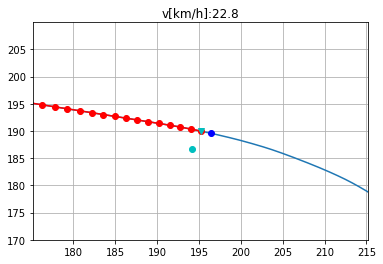

vehicle.get_transform() Transform(Location(x=232.658066, y=71.217957, z=0.015261), Rotation(pitch=1.522347, yaw=97.111328, roll=-1.789795))
vehicleToFollow.get_transform() Transform(Location(x=195.273148, y=189.959122, z=0.043968), Rotation(pitch=1.557563, yaw=87.250252, roll=-8.723858))
obsticle_vehicle.get_transform() Transform(Location(x=233.786987, y=75.516022, z=0.106776), Rotation(pitch=-3.803800, yaw=87.877151, roll=-1.447968))
ego_position:  (192.98014089731132, 187.0155048632735, 2.5926317728588515, 2.8483347402614245)
path.x[1]:  193.99183436731067
path.y[1]:  190.36587948309025
s:  177.4882761823889


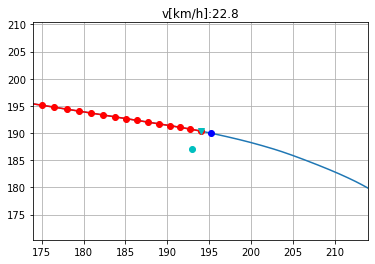

vehicle.get_transform() Transform(Location(x=232.654953, y=71.239655, z=0.019109), Rotation(pitch=1.082974, yaw=97.160248, roll=-1.790893))
vehicleToFollow.get_transform() Transform(Location(x=194.063126, y=190.338348, z=0.038789), Rotation(pitch=1.614657, yaw=87.248764, roll=-8.735057))
obsticle_vehicle.get_transform() Transform(Location(x=233.786789, y=75.521729, z=0.102759), Rotation(pitch=-3.403989, yaw=87.851974, roll=-1.086639))
ego_position:  (191.8253741454489, 187.35156180440708, 2.619119744563101, 2.8676835693385483)
path.x[1]:  192.77207815219168
path.y[1]:  190.72096034878436
s:  178.75896142242817


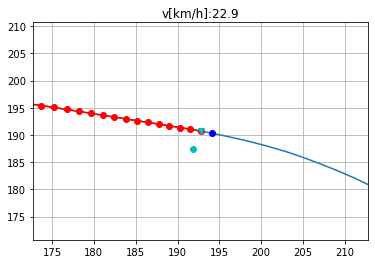

vehicle.get_transform() Transform(Location(x=232.649551, y=71.276703, z=0.021602), Rotation(pitch=0.705033, yaw=97.223488, roll=-1.584076))
vehicleToFollow.get_transform() Transform(Location(x=192.843277, y=190.693436, z=0.034099), Rotation(pitch=1.659599, yaw=87.248482, roll=-8.732005))
obsticle_vehicle.get_transform() Transform(Location(x=233.786652, y=75.528305, z=0.097444), Rotation(pitch=-2.885857, yaw=87.832291, roll=-0.775421))
ego_position:  (190.65838381872595, 187.66757474783316, 2.645318871961661, 2.8859004936974846)
path.x[1]:  191.54357068219983
path.y[1]:  191.05372289143102
s:  180.03202671612112


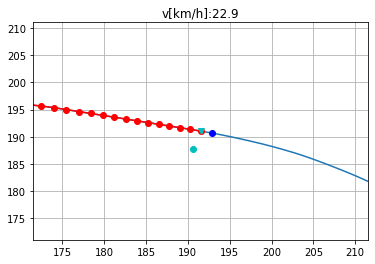

vehicle.get_transform() Transform(Location(x=232.641495, y=71.327423, z=0.022866), Rotation(pitch=0.405918, yaw=97.299591, roll=-1.323731))
vehicleToFollow.get_transform() Transform(Location(x=191.614700, y=191.026199, z=0.029664), Rotation(pitch=1.692562, yaw=87.249092, roll=-8.723309))
obsticle_vehicle.get_transform() Transform(Location(x=233.786591, y=75.535294, z=0.091458), Rotation(pitch=-2.310912, yaw=87.818817, roll=-0.522552))
ego_position:  (189.4604055230345, 187.9723910936991, 2.672621729907847, 2.8970385814210164)
path.x[1]:  190.30783575751133
path.y[1]:  191.36823922884267
s:  181.3074577581114


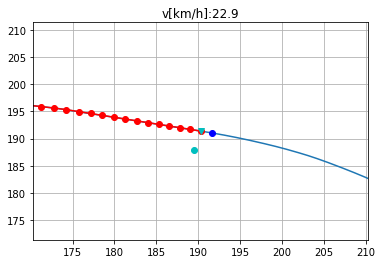

vehicle.get_transform() Transform(Location(x=232.631165, y=71.390190, z=0.023126), Rotation(pitch=0.186908, yaw=97.390709, roll=-1.074524))
vehicleToFollow.get_transform() Transform(Location(x=190.378922, y=191.340714, z=0.025551), Rotation(pitch=1.710751, yaw=87.250549, roll=-8.734416))
obsticle_vehicle.get_transform() Transform(Location(x=233.786621, y=75.542305, z=0.085293), Rotation(pitch=-1.727908, yaw=87.810570, roll=-0.327179))
ego_position:  (188.2338015873702, 188.27456657616634, 2.6995096547201474, 2.9011019565406158)
path.x[1]:  189.06743594441457
path.y[1]:  191.6738695883179
s:  182.5852403290254


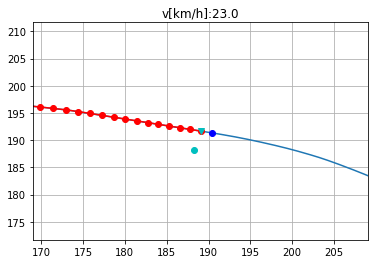

vehicle.get_transform() Transform(Location(x=232.618820, y=71.463394, z=0.022656), Rotation(pitch=0.039451, yaw=97.499321, roll=-0.853729))
vehicleToFollow.get_transform() Transform(Location(x=189.138458, y=191.646423, z=0.021637), Rotation(pitch=1.718052, yaw=87.252426, roll=-8.746837))
obsticle_vehicle.get_transform() Transform(Location(x=233.786713, y=75.549057, z=0.079323), Rotation(pitch=-1.173303, yaw=87.806007, roll=-0.183288))
ego_position:  (186.98867400541832, 188.58032036205768, 2.7247342775188548, 2.90048109347528)
path.x[1]:  187.82442592367363
path.y[1]:  191.97913450974124
s:  183.8654356014765


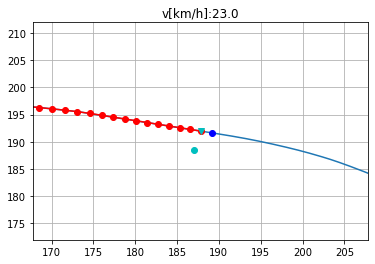

vehicle.get_transform() Transform(Location(x=232.604767, y=71.545570, z=0.021727), Rotation(pitch=-0.049348, yaw=97.621536, roll=-0.664703))
vehicleToFollow.get_transform() Transform(Location(x=187.895432, y=191.951691, z=0.017784), Rotation(pitch=1.719691, yaw=87.253883, roll=-8.753705))
obsticle_vehicle.get_transform() Transform(Location(x=233.786804, y=75.555336, z=0.073810), Rotation(pitch=-0.672391, yaw=87.803879, roll=-0.082642))
ego_position:  (185.74068797420142, 188.88771465081123, 2.749401954602195, 2.8996859927387586)
path.x[1]:  186.5791471037425
path.y[1]:  192.28588379010668
s:  185.14817646890086


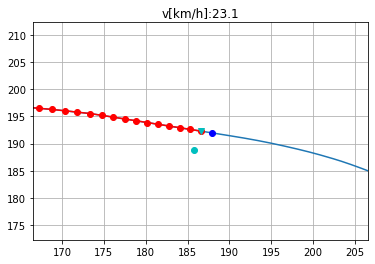

vehicle.get_transform() Transform(Location(x=232.587326, y=71.595421, z=0.016206), Rotation(pitch=0.020976, yaw=97.668755, roll=-0.513580))
vehicleToFollow.get_transform() Transform(Location(x=186.650070, y=192.258453, z=0.013873), Rotation(pitch=1.720367, yaw=87.254936, roll=-8.753672))
obsticle_vehicle.get_transform() Transform(Location(x=233.784760, y=75.592285, z=0.073314), Rotation(pitch=-0.525720, yaw=87.198158, roll=-0.395874))
ego_position:  (184.4946919487389, 189.194807747696, 2.7691122000725743, 2.90021069041031)
path.x[1]:  185.3313711782938
path.y[1]:  192.59342946406832
s:  186.43344616407097


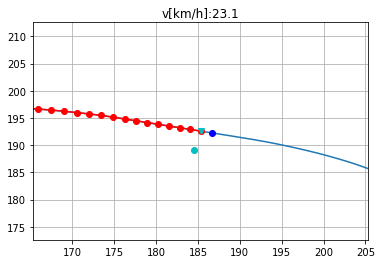

vehicle.get_transform() Transform(Location(x=232.575241, y=71.649742, z=0.011875), Rotation(pitch=0.054341, yaw=97.729797, roll=-0.527710))
vehicleToFollow.get_transform() Transform(Location(x=185.402222, y=192.565994, z=0.009911), Rotation(pitch=1.720169, yaw=87.255783, roll=-8.753521))
obsticle_vehicle.get_transform() Transform(Location(x=233.786179, y=75.632904, z=0.073366), Rotation(pitch=-0.432303, yaw=87.077003, roll=-0.608948))
ego_position:  (183.24462647700994, 189.50250375484143, 2.7885624437773457, 2.9002839564115512)
path.x[1]:  184.08105840154465
path.y[1]:  192.90119367250946
s:  187.72122803020116


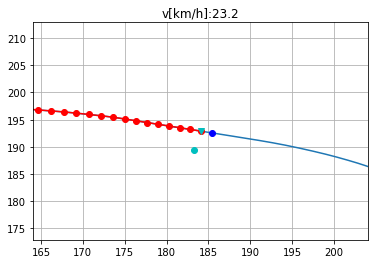

vehicle.get_transform() Transform(Location(x=232.563766, y=71.707764, z=0.008638), Rotation(pitch=0.064607, yaw=97.808083, roll=-0.512665))
vehicleToFollow.get_transform() Transform(Location(x=184.151871, y=192.873764, z=0.005898), Rotation(pitch=1.719486, yaw=87.256523, roll=-8.753398))
obsticle_vehicle.get_transform() Transform(Location(x=233.788269, y=75.676392, z=0.073801), Rotation(pitch=-0.380278, yaw=87.007942, roll=-0.744110))
ego_position:  (181.99319123340146, 189.81016906656404, 2.8051226852196365, 2.9007042404220167)
path.x[1]:  182.8281951369529
path.y[1]:  193.209212127597
s:  189.01150552022003


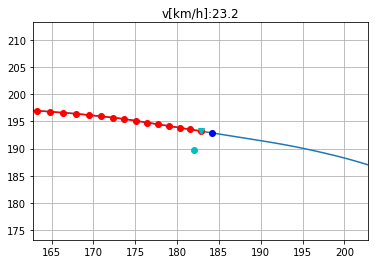

vehicle.get_transform() Transform(Location(x=232.551758, y=71.769058, z=0.006366), Rotation(pitch=0.062735, yaw=97.897713, roll=-0.475769))
vehicleToFollow.get_transform() Transform(Location(x=182.899002, y=193.181793, z=0.001837), Rotation(pitch=1.718482, yaw=87.257019, roll=-8.753337))
obsticle_vehicle.get_transform() Transform(Location(x=233.790527, y=75.722397, z=0.074455), Rotation(pitch=-0.357144, yaw=86.947754, roll=-0.817291))
ego_position:  (180.73728262335212, 190.1189182121571, 2.818299145722473, 2.900528820104621)
path.x[1]:  181.57288228049916
path.y[1]:  193.5178127317254
s:  190.30426219604772


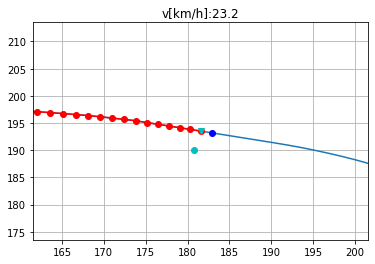

vehicle.get_transform() Transform(Location(x=232.539078, y=71.833282, z=0.004898), Rotation(pitch=0.055837, yaw=97.996017, roll=-0.434967))
vehicleToFollow.get_transform() Transform(Location(x=181.643585, y=193.490448, z=-0.002270), Rotation(pitch=1.717396, yaw=87.257523, roll=-8.753306))
obsticle_vehicle.get_transform() Transform(Location(x=233.792938, y=75.770775, z=0.075210), Rotation(pitch=-0.353455, yaw=86.890556, roll=-0.844452))
ego_position:  (179.4792033669668, 190.42823576579232, 2.829807325352081, 2.900420733848014)
path.x[1]:  180.31516917394475
path.y[1]:  193.82703499226525
s:  191.59948172787813


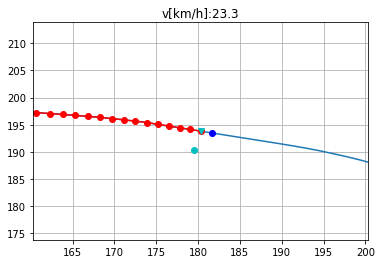

vehicle.get_transform() Transform(Location(x=232.525696, y=71.900261, z=0.004087), Rotation(pitch=0.047074, yaw=98.102722, roll=-0.399383))
vehicleToFollow.get_transform() Transform(Location(x=180.385849, y=193.799683, z=-0.006418), Rotation(pitch=1.716256, yaw=87.257858, roll=-8.753244))
obsticle_vehicle.get_transform() Transform(Location(x=233.795456, y=75.821312, z=0.075982), Rotation(pitch=-0.361720, yaw=86.837456, roll=-0.839538))
ego_position:  (178.22063534226368, 190.7374371613758, 2.8383872864965656, 2.9008904344749933)
path.x[1]:  179.05500290819626
path.y[1]:  194.1366216155161
s:  192.89714789346567


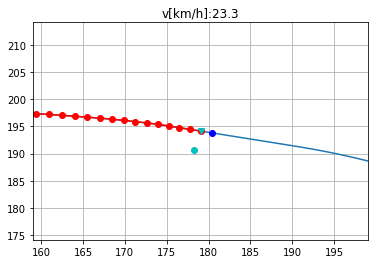

vehicle.get_transform() Transform(Location(x=232.511658, y=71.969856, z=0.003788), Rotation(pitch=0.037976, yaw=98.217384, roll=-0.371185))
vehicleToFollow.get_transform() Transform(Location(x=179.125626, y=194.109253, z=-0.010602), Rotation(pitch=1.715183, yaw=87.258179, roll=-8.753277))
obsticle_vehicle.get_transform() Transform(Location(x=233.798141, y=75.873878, z=0.076719), Rotation(pitch=-0.376521, yaw=86.787811, roll=-0.814575))
ego_position:  (176.9595727080527, 191.04656294642604, 2.8442572910425836, 2.9013719011706076)
path.x[1]:  177.79230152080004
path.y[1]:  194.4461403069699
s:  194.19724457741685


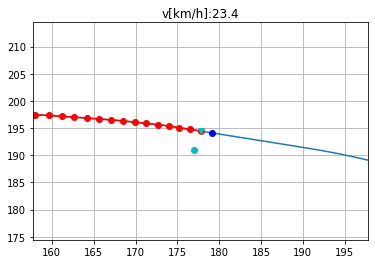

vehicle.get_transform() Transform(Location(x=232.496902, y=72.041885, z=0.003858), Rotation(pitch=0.029903, yaw=98.338905, roll=-0.349579))
vehicleToFollow.get_transform() Transform(Location(x=177.862869, y=194.418777, z=-0.014818), Rotation(pitch=1.714131, yaw=87.258324, roll=-8.753244))
obsticle_vehicle.get_transform() Transform(Location(x=233.800888, y=75.928413, z=0.077397), Rotation(pitch=-0.394382, yaw=86.738159, roll=-0.779572))
ego_position:  (175.6962017167801, 191.35570980385765, 2.8472557078441065, 2.901903989294028)
path.x[1]:  176.52711929284666
path.y[1]:  194.75572058547948
s:  195.49975577048647


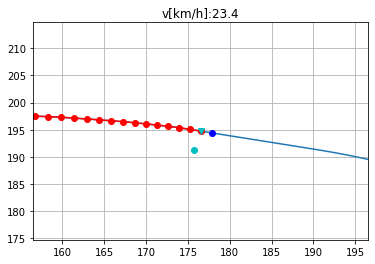

vehicle.get_transform() Transform(Location(x=232.481461, y=72.116341, z=0.004195), Rotation(pitch=0.022444, yaw=98.467773, roll=-0.333954))
vehicleToFollow.get_transform() Transform(Location(x=176.597626, y=194.728348, z=-0.019063), Rotation(pitch=1.713223, yaw=87.258575, roll=-8.753277))
obsticle_vehicle.get_transform() Transform(Location(x=233.803787, y=75.984772, z=0.077994), Rotation(pitch=-0.412284, yaw=86.690712, roll=-0.740662))
ego_position:  (174.42995844960706, 191.66500598494795, 2.8478665753810772, 2.9023149752727098)
path.x[1]:  175.25947629273438
path.y[1]:  195.06534852199394
s:  196.80466556887836


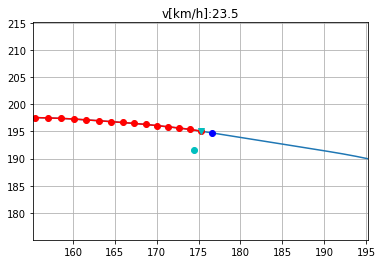

vehicle.get_transform() Transform(Location(x=232.465286, y=72.193207, z=0.004707), Rotation(pitch=0.015552, yaw=98.603989, roll=-0.322968))
vehicleToFollow.get_transform() Transform(Location(x=175.329941, y=195.038010, z=-0.023333), Rotation(pitch=1.712383, yaw=87.258736, roll=-8.753245))
obsticle_vehicle.get_transform() Transform(Location(x=233.806793, y=76.042862, z=0.078508), Rotation(pitch=-0.428553, yaw=86.645447, roll=-0.702393))
ego_position:  (173.21560453819598, 191.95801727266704, 2.8457391494302735, 2.918908096071413)
path.x[1]:  173.98858636053944
path.y[1]:  195.3716459975016
s:  198.11195817355085


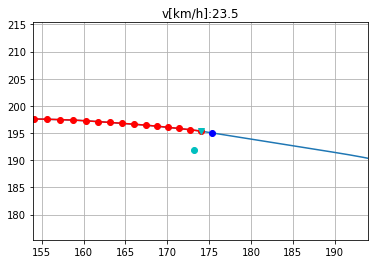

vehicle.get_transform() Transform(Location(x=232.448425, y=72.272560, z=0.005359), Rotation(pitch=0.010874, yaw=98.748825, roll=-0.309112))
vehicleToFollow.get_transform() Transform(Location(x=174.059006, y=195.344376, z=-0.027624), Rotation(pitch=1.711625, yaw=87.258774, roll=-8.753276))
obsticle_vehicle.get_transform() Transform(Location(x=233.810013, y=76.102531, z=0.078899), Rotation(pitch=-0.439024, yaw=86.605782, roll=-0.663086))
ego_position:  (172.10509019000398, 192.17117245450228, 2.840923324267803, 2.9699616293453532)
path.x[1]:  172.7028611792881
path.y[1]:  195.6197906624145
s:  199.42161788952683


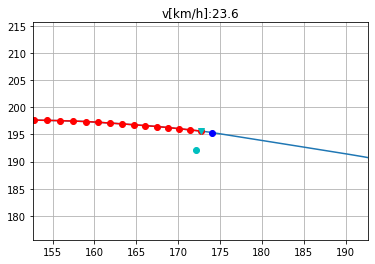

vehicle.get_transform() Transform(Location(x=232.430954, y=72.356010, z=0.006429), Rotation(pitch=0.019350, yaw=98.916245, roll=-0.251892))
vehicleToFollow.get_transform() Transform(Location(x=172.773239, y=195.592514, z=-0.031934), Rotation(pitch=1.710996, yaw=87.258842, roll=-8.753306))
obsticle_vehicle.get_transform() Transform(Location(x=233.813660, y=76.162697, z=0.078625), Rotation(pitch=-0.406219, yaw=86.598457, roll=-0.582733))
ego_position:  (170.8200486325092, 192.39722758404656, 2.83350144426012, 2.972022885810574)
path.x[1]:  171.41070842979747
path.y[1]:  195.84706221042845
s:  200.73362912520827


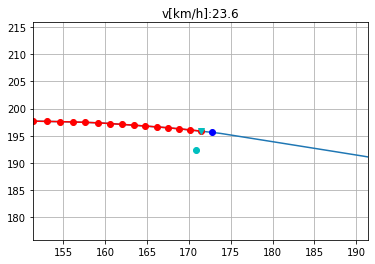

vehicle.get_transform() Transform(Location(x=232.412399, y=72.443665, z=0.007764), Rotation(pitch=0.038058, yaw=99.098602, roll=-0.173981))
vehicleToFollow.get_transform() Transform(Location(x=171.481018, y=195.819778, z=-0.036260), Rotation(pitch=1.710416, yaw=87.258865, roll=-8.753306))
obsticle_vehicle.get_transform() Transform(Location(x=233.817307, y=76.223083, z=0.077755), Rotation(pitch=-0.335328, yaw=86.596718, roll=-0.481140))
ego_position:  (169.56092041537508, 192.6049707426265, 2.823641392493057, 2.9829238704487464)
path.x[1]:  170.1139380453064
path.y[1]:  196.0610313946251
s:  202.04797639169524


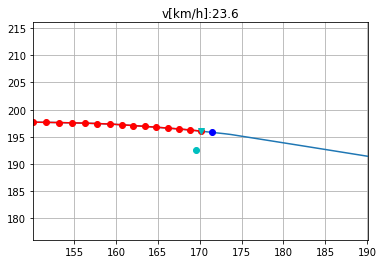

vehicle.get_transform() Transform(Location(x=232.392624, y=72.535378, z=0.009172), Rotation(pitch=0.062701, yaw=99.293251, roll=-0.098419))
vehicleToFollow.get_transform() Transform(Location(x=170.184189, y=196.033752, z=-0.040599), Rotation(pitch=1.709917, yaw=87.258896, roll=-8.753305))
obsticle_vehicle.get_transform() Transform(Location(x=233.820847, y=76.283577, z=0.076491), Rotation(pitch=-0.240566, yaw=86.595543, roll=-0.377319))
ego_position:  (168.276146763504, 192.80659560955993, 2.810750530896457, 2.9875476968098287)
path.x[1]:  168.8131772607705
path.y[1]:  196.26516957990643
s:  203.3647228463491


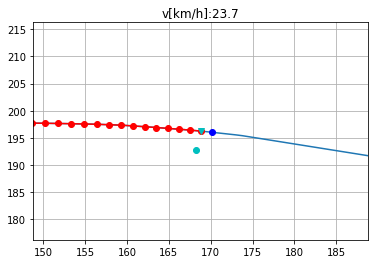

vehicle.get_transform() Transform(Location(x=232.371552, y=72.631050, z=0.010514), Rotation(pitch=0.090199, yaw=99.499435, roll=-0.034851))
vehicleToFollow.get_transform() Transform(Location(x=168.883392, y=196.237885, z=-0.044951), Rotation(pitch=1.709507, yaw=87.258827, roll=-8.753337))
obsticle_vehicle.get_transform() Transform(Location(x=233.824387, y=76.344078, z=0.075008), Rotation(pitch=-0.133783, yaw=86.594597, roll=-0.281982))
ego_position:  (167.08062458663815, 192.97762780754724, 2.794957970203565, 3.019386961195222)
path.x[1]:  167.50742350881401
path.y[1]:  196.45268823709824
s:  204.6840062225401


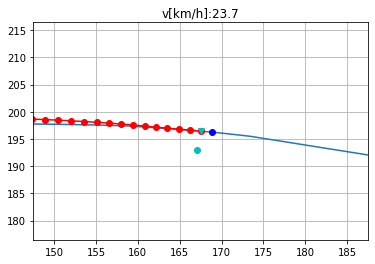

vehicle.get_transform() Transform(Location(x=232.349213, y=72.730606, z=0.011747), Rotation(pitch=0.117705, yaw=99.716980, roll=0.018605))
vehicleToFollow.get_transform() Transform(Location(x=167.577576, y=196.425430, z=-0.049398), Rotation(pitch=1.713571, yaw=87.255539, roll=-8.753459))
obsticle_vehicle.get_transform() Transform(Location(x=233.827881, y=76.404518, z=0.073451), Rotation(pitch=-0.024445, yaw=86.593964, roll=-0.200439))
ego_position:  (165.77178664308494, 193.1382026902259, 2.776726228417532, 3.020057756949935)
path.x[1]:  166.1969914710436
path.y[1]:  196.61958331831462
s:  206.00513104425366


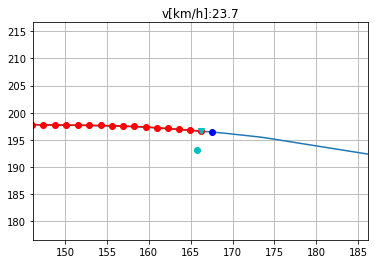

vehicle.get_transform() Transform(Location(x=232.325500, y=72.834007, z=0.012852), Rotation(pitch=0.143584, yaw=99.945747, roll=0.063992))
vehicleToFollow.get_transform() Transform(Location(x=166.267090, y=196.592377, z=-0.053742), Rotation(pitch=1.732184, yaw=87.247025, roll=-8.755046))
obsticle_vehicle.get_transform() Transform(Location(x=233.831406, y=76.464821, z=0.071936), Rotation(pitch=0.080262, yaw=86.593567, roll=-0.134491))
ego_position:  (164.4852481593768, 193.29059833294866, 2.7557840981114103, 3.0274618481356192)
path.x[1]:  164.88590071048426
path.y[1]:  196.78581090832157
s:  207.32674715545426


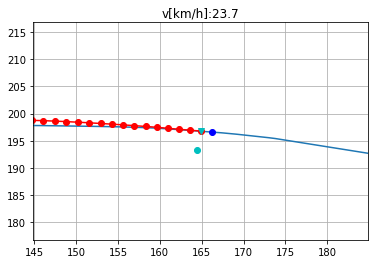

vehicle.get_transform() Transform(Location(x=232.300430, y=72.941185, z=0.013847), Rotation(pitch=0.166117, yaw=100.185364, roll=0.101345))
vehicleToFollow.get_transform() Transform(Location(x=164.955933, y=196.758621, z=-0.057759), Rotation(pitch=1.774640, yaw=87.232620, roll=-8.755381))
obsticle_vehicle.get_transform() Transform(Location(x=233.834900, y=76.524956, z=0.070547), Rotation(pitch=0.175427, yaw=86.593391, roll=-0.083679))
ego_position:  (163.1912927531938, 193.43479301680907, 2.732119923659765, 3.0331546361469)
path.x[1]:  163.574158200474
path.y[1]:  196.9516738919013
s:  208.6488509942931


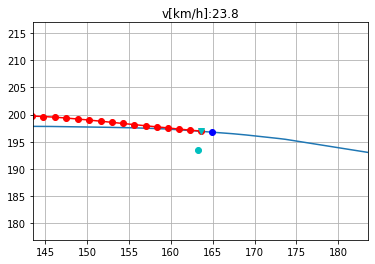

vehicle.get_transform() Transform(Location(x=232.273941, y=73.052109, z=0.014767), Rotation(pitch=0.183951, yaw=100.435974, roll=0.130977))
vehicleToFollow.get_transform() Transform(Location(x=163.644135, y=196.924515, z=-0.061597), Rotation(pitch=1.831775, yaw=87.214302, roll=-8.756054))
obsticle_vehicle.get_transform() Transform(Location(x=233.838379, y=76.584885, z=0.069345), Rotation(pitch=0.257901, yaw=86.593338, roll=-0.046326))
ego_position:  (161.88583226580198, 193.57506494161436, 2.7049612430272347, 3.035817208247725)
path.x[1]:  162.26313994792562
path.y[1]:  197.12881475688243
s:  209.97142414263647


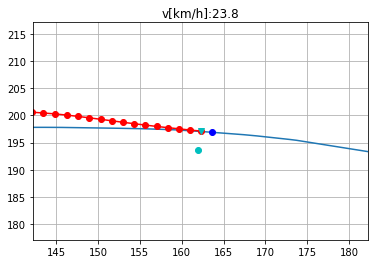

vehicle.get_transform() Transform(Location(x=232.245972, y=73.166748, z=0.015618), Rotation(pitch=0.197556, yaw=100.697456, roll=0.155334))
vehicleToFollow.get_transform() Transform(Location(x=162.333008, y=197.101654, z=-0.065356), Rotation(pitch=1.897351, yaw=87.193565, roll=-8.756907))
obsticle_vehicle.get_transform() Transform(Location(x=233.846237, y=76.667969, z=0.056500), Rotation(pitch=1.211409, yaw=85.798653, roll=1.010520))
ego_position:  (160.57451819233347, 193.71356814389642, 2.6760719759333487, 3.036988792442065)
path.x[1]:  160.9539652977675
path.y[1]:  197.32779542651846
s:  211.29444888104246


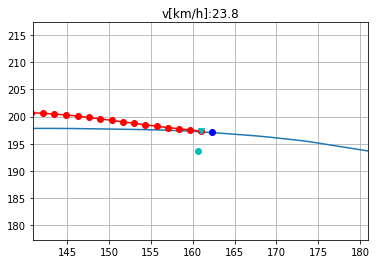

vehicle.get_transform() Transform(Location(x=232.216522, y=73.285072, z=0.016406), Rotation(pitch=0.207604, yaw=100.969879, roll=0.176204))
vehicleToFollow.get_transform() Transform(Location(x=161.023758, y=197.300644, z=-0.068983), Rotation(pitch=1.962170, yaw=87.172180, roll=-8.758860))
obsticle_vehicle.get_transform() Transform(Location(x=233.859344, y=76.780510, z=0.033395), Rotation(pitch=2.922945, yaw=84.960327, roll=2.435632))
ego_position:  (159.32443316551277, 193.83830979041443, 2.645034602188348, 3.056081109344722)
path.x[1]:  159.64255164852412
path.y[1]:  197.5494194775016
s:  212.61795113453948


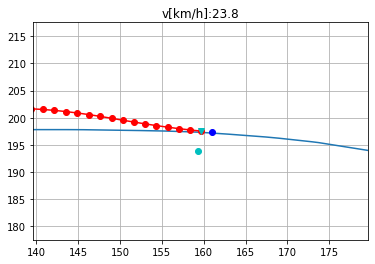

vehicle.get_transform() Transform(Location(x=232.185486, y=73.407082, z=0.017175), Rotation(pitch=0.216278, yaw=101.253372, roll=0.188390))
vehicleToFollow.get_transform() Transform(Location(x=159.712280, y=197.522278, z=-0.072148), Rotation(pitch=2.007297, yaw=87.153397, roll=-8.760173))
obsticle_vehicle.get_transform() Transform(Location(x=233.863358, y=76.886856, z=0.021251), Rotation(pitch=3.821320, yaw=84.721176, roll=2.463262))
ego_position:  (158.10913425026797, 193.91977346238573, 2.613670967681259, 3.086422928792608)
path.x[1]:  158.32155893199223
path.y[1]:  197.76625121558453
s:  213.9426045244764


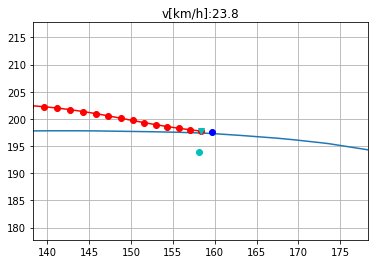

vehicle.get_transform() Transform(Location(x=232.152802, y=73.532730, z=0.017969), Rotation(pitch=0.225294, yaw=101.547943, roll=0.190392))
vehicleToFollow.get_transform() Transform(Location(x=158.391220, y=197.739197, z=-0.075028), Rotation(pitch=2.037029, yaw=87.136841, roll=-8.761119))
obsticle_vehicle.get_transform() Transform(Location(x=233.867569, y=76.986588, z=0.019883), Rotation(pitch=3.981481, yaw=84.658936, roll=1.788639))
ego_position:  (156.80081627050967, 193.99185588220246, 2.581931694242879, 3.0909289445646966)
path.x[1]:  157.00454798047028
path.y[1]:  198.0096700220584
s:  215.26906042733626


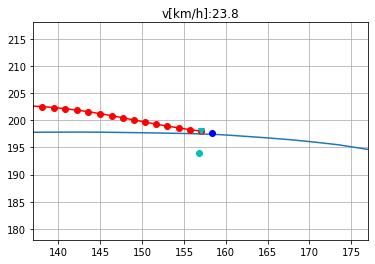

vehicle.get_transform() Transform(Location(x=232.118484, y=73.662018, z=0.018780), Rotation(pitch=0.234084, yaw=101.853210, roll=0.188436))
vehicleToFollow.get_transform() Transform(Location(x=157.074158, y=197.982620, z=-0.077770), Rotation(pitch=2.055805, yaw=87.121902, roll=-8.761974))
obsticle_vehicle.get_transform() Transform(Location(x=233.876129, y=77.084641, z=0.020856), Rotation(pitch=3.937501, yaw=84.592545, roll=1.317021))
ego_position:  (155.515639433323, 194.04939457895426, 2.550147649493574, 3.1023738316552656)
path.x[1]:  155.6818207292915
path.y[1]:  198.28450611472098
s:  216.59596896934485


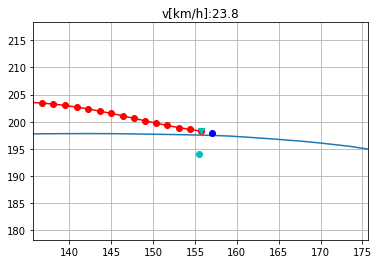

vehicle.get_transform() Transform(Location(x=232.082458, y=73.794922, z=0.019588), Rotation(pitch=0.241796, yaw=102.167870, roll=0.186734))
vehicleToFollow.get_transform() Transform(Location(x=155.751373, y=198.257462, z=-0.080471), Rotation(pitch=2.066924, yaw=87.108162, roll=-8.762677))
obsticle_vehicle.get_transform() Transform(Location(x=233.885345, y=77.180801, z=0.024253), Rotation(pitch=3.693575, yaw=84.558876, roll=0.922900))
ego_position:  (154.21618248193164, 194.0946495125775, 2.51911161649067, 3.1102093119676635)
path.x[1]:  154.35739818854347
path.y[1]:  198.59287482858957
s:  217.92400395220164


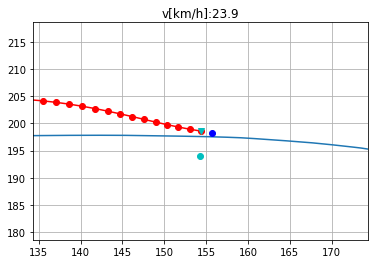

vehicle.get_transform() Transform(Location(x=232.044647, y=73.931435, z=0.020389), Rotation(pitch=0.248585, yaw=102.492317, roll=0.186061))
vehicleToFollow.get_transform() Transform(Location(x=154.426880, y=198.565842, z=-0.083197), Rotation(pitch=2.072675, yaw=87.095436, roll=-8.763317))
obsticle_vehicle.get_transform() Transform(Location(x=233.894699, y=77.275726, z=0.029372), Rotation(pitch=3.318741, yaw=84.537674, roll=0.610535))
ego_position:  (152.90266950288304, 194.13274625609668, 2.4888612220728166, 3.1146100195237865)
path.x[1]:  153.03245683573934
path.y[1]:  198.94161084822002
s:  219.25381693143274


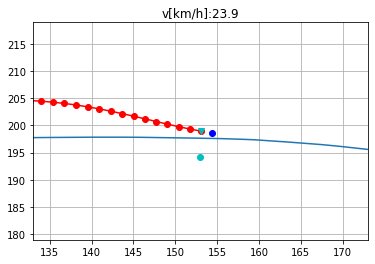

destroying actors.
done.


AttributeError: 'NoneType' object has no attribute 'x'

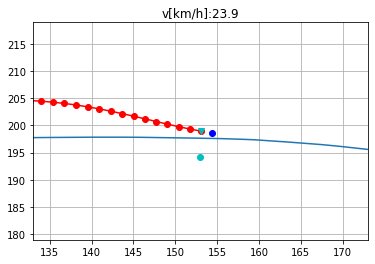

In [54]:
for fileName in drivesFileNames:
    main(optimalDistance=optimalDistance,followDrivenPath=followDrivenPath,chaseMode=chaseMode, evaluateChasingCar=evaluateChasingCar,driveName=os.path.join(drivesDir,fileName),record=record,followMode=followMode)
